## Lending Club Loan Data Analysis and Prediction

Outlines:

#### 1. Define goal 

    a.Identify most important attributes separating bad loans and good loans 
    b.Build Xgboost model to make prediction
    
#### 2. EDA

    a.Data first impression
      -available predicting variables
      -data distribution
      -missing values
    b.Split dataset in to training and test set
    c.correlation analysis and remove multicollinearity
    d.Data Visualization to explore relationship between target and predicting variables
    
#### 3. Data cleansing and Feature Engineering

    a. Impute missing values
    b. Transform any characteristics or categorical variables into numeric
    c. Create new features from existing features

#### 4. Feature Selections
    a. Remove variables according to correlation analysis
    b. Logistic regression with L1 regularization (coeffecients not zero)
    c. Random Forest model built-in feature importance
    
####  Data Preprocessing

#### 5. Build Model and evaluate model performance with validation set 
    a. Logistic regression with L1 regularization model
    b. Random Forest model 
    c. Xgboost model
        -hyperparameters Tuning
        

 
#### 6. Assess any additional feature engineering or feature selection opportunity based on model results

#### 7. Choose the best model and run prediction on test dataset

#### 8. Evaluate final model performance 

#### 9. Areas of improvements

 
Data Source : https://www.kaggle.com/wordsforthewise/lending-club

In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
matplotlib.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv("accepted_2007_to_2018Q4.csv")

In [3]:
data.shape

(2260701, 151)

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(data.info(verbose =True, max_cols = True,null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
id                                            2260701 non-null object
member_id                                     0 non-null float64
loan_amnt                                     2260668 non-null float64
funded_amnt                                   2260668 non-null float64
funded_amnt_inv                               2260668 non-null float64
term                                          2260668 non-null object
int_rate                                      2260668 non-null float64
installment                                   2260668 non-null float64
grade                                         2260668 non-null object
sub_grade                                     2260668 non-null object
emp_title                                     2093699 non-null object
emp_length                                    2113761 non-null object
home_ownership                                

In [6]:
# Loading in the data dictionary
xls = pd.ExcelFile('LCDataDictionary.xlsx')
dict1 = pd.read_excel(xls, 'LoanStats')
dict2 = pd.read_excel(xls, 'browseNotes')

In [7]:
# Column Names in the data dictionary
print(dict1.columns.tolist())
print(dict2.columns.tolist())

['LoanStatNew', 'Description']
['BrowseNotesFile', 'Description']


In [8]:
dict1.loc[dict1['LoanStatNew'].isnull(),:]

,LoanStatNew,Description
151,NaN,NaN
152,NaN,* Employer Title replaces Employer Name for al...


In [9]:
dict2.loc[dict2['BrowseNotesFile'].isnull(),:]

,BrowseNotesFile,Description
120,NaN,NaN
121,NaN,* Employer Title replaces Employer Name for al...


In [10]:
# Remove NaN from data dictionary LoanStatNew
dict1.dropna(axis=0, subset=['LoanStatNew'], inplace= True)

In [11]:
# Remove NaN from data dictionary LoanStatNew
dict2.dropna(axis=0, subset=['BrowseNotesFile'], inplace= True)

In [12]:
print('Number of Features in LoanStatNew:' ,dict1.shape[0])
print('Number of Features in BrowseNotesFile:', dict2.shape[0])

Number of Features in LoanStatNew: 151
Number of Features in BrowseNotesFile: 120


In [13]:
# available columns in data dictionary LoanStatNew
dict1['LoanStatNew'].tolist() 

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_amnt',
 'loan_status',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mth

In [14]:
# available columns in data dictionary LoanStatNew
dict2['BrowseNotesFile'].tolist() 

['acceptD',
 'accNowDelinq',
 'accOpenPast24Mths',
 'addrState',
 'all_util',
 'annual_inc_joint',
 'annualInc',
 'application_type',
 'avg_cur_bal',
 'bcOpenToBuy',
 'bcUtil',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'creditPullD',
 'delinq2Yrs',
 'delinqAmnt',
 'desc',
 'dti',
 'dti_joint',
 'earliestCrLine',
 'effective_int_rate',
 'emp_title',
 'empLength',
 'expD',
 'expDefaultRate',
 'ficoRangeHigh',
 'ficoRangeLow',
 'fundedAmnt',
 'grade',
 'homeOwnership',
 'id',
 'il_util',
 'ils_exp_d',
 'initialListStatus',
 'inq_fi',
 'inq_last_12m',
 'inqLast6Mths',
 'installment',
 'intRate',
 'isIncV',
 'listD',
 'loanAmnt',
 'max_bal_bc',
 'memberId',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mortAcc',
 'msa',
 'mths_since_last_major_derog',
 'mths_since_oldest_il_open',
 'mths_since_rcnt_il',
 'mthsSinceLastDelinq',
 'mthsSinceLastRecord',
 'mthsSinceMostRecentInq',
 'mthsSinceRecentBc',
 'mthsSinceRecentLoanDelinq',
 'mthsSinceRecentR

In [15]:
#  All columns in the dataset
data.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

Noted that some of the columns/features in the dataset are not available at the moment of investing until the loans have been issued. So these features should be removed, otherwise they would leek information from the future. We can use the variables that are in the data dictionary BrowseNoteFile, which lists all information available to investors when they are deciding whether to invest to any loans.

Noted that some features were named slightly different between the data dictionary sheet and the column names in the dataset but they referred to the same thing, so we will need to match the format between these column names.

In [16]:
# Noted format differences between data dictionary BrowseNote and columns name in the dataset
index2 = [x not in dict2['BrowseNotesFile'].tolist() for x in data.columns.tolist()]
pd.Series(data.columns.tolist())[index2].head()

1          member_id
2          loan_amnt
3        funded_amnt
4    funded_amnt_inv
6           int_rate
dtype: object

In [17]:
# Match the format of data dictionary to the columns names in the dataset
dictionary = dict2['BrowseNotesFile'].dropna().values
dictionary = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in dictionary]

In [18]:
# Find features that are in dataset but not in the BrowseNote
index3 = [x not in dictionary for x in data.columns.tolist()]
pd.Series(data.columns.tolist())[index3].head()

4         funded_amnt_inv
14    verification_status
15                issue_d
16            loan_status
17             pymnt_plan
dtype: object

In [19]:
# # The features that are in the BrowseNote but not in dataset
index4 = [x not in data.columns.tolist()for x in dictionary]
pd.Series(dictionary)[index4]

0                           accept_d
13                     credit_pull_d
20                effective_int_rate
23                             exp_d
24                  exp_default_rate
32                         ils_exp_d
39                          is_inc_v
40                            list_d
48                               msa
50         mths_since_oldest_il_open
54        mths_since_most_recent_inq
56     mths_since_recent_loan_delinq
84                     review_status
85                   review_status_d
88                  service_fee_rate
104            verified_status_joint
dtype: object

In [20]:
# Manually match the spelling between column names in dataset and data dictionary 'BrowseNote'
uni_dict = ['is_inc_v','mths_since_oldest_il_open','mths_since_most_recent_inq',
             'mths_since_recent_loan_delinq','verified_status_joint']

uni_dataset = ['verification_status', 'mo_sin_old_il_acct','mths_since_recent_inq',
           'mths_since_recent_bc_dlq', 'verification_status_joint']


dictionary = np.setdiff1d(dictionary, uni_dict)
dictionary = np.append(dictionary,uni_dataset)

Create a list containing all features that are available in the dataset and also available to investors at the moment of investing

In [21]:
dictionary = np.intersect1d(dictionary, data.columns.tolist())

In [22]:
# Skim through the available features 
dictionary

array(['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util',
       'annual_inc', 'annual_inc_joint', 'application_type',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'delinq_amnt', 'desc', 'disbursement_method', 'dti',
       'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title',
       'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade',
       'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi',
       'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate',
       'loan_amnt', 'max_bal_bc', 'member_id', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revo

Noted that Issue_d is the only column in the dataset that reveals when the loan was originated. Althought it's the date when the loan was issued (information from the future), we are going to extract the year and month of the issue date, which would represent the time period when investors were making investing decisions about that loans. 


In [23]:
# Adding back the target variable 'loan status' and 'issue_d' to the dictionary list
dictionary = np.append(dictionary, np.array(['loan_status', 'issue_d' ]))

In [24]:
# Drop features that are not available at the moment of investing,except for loan_status(target variable)
cols_to_remove = [x not in dictionary for x in data.columns.tolist()]
cols_to_remove = pd.Series(data.columns.tolist())[cols_to_remove]
data.drop(columns=cols_to_remove, inplace = True)

Now we have a dataset with all features that are available to investors at the moment of investing after removing features that leeks information from the future.


In [25]:
data.shape

(2260701, 111)

In [26]:
# Check if there is any missing values in the target variable, loan status
data.loan_status.isnull().sum()

33

In [27]:
#Check data where loan status is NaN. Noted there is no loan information for any of these rows.
data.loc[data.loan_status.isnull(),:].head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528961,Total amount funded in policy code 1: 1741781700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528962,Total amount funded in policy code 2: 564202131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651664,Total amount funded in policy code 1: 1791201400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# remove rows where loan status is missing 
data.dropna(axis=0, subset=['loan_status'], inplace= True)

In [29]:
# Let's check the distribution of target variable, loan status 
data.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

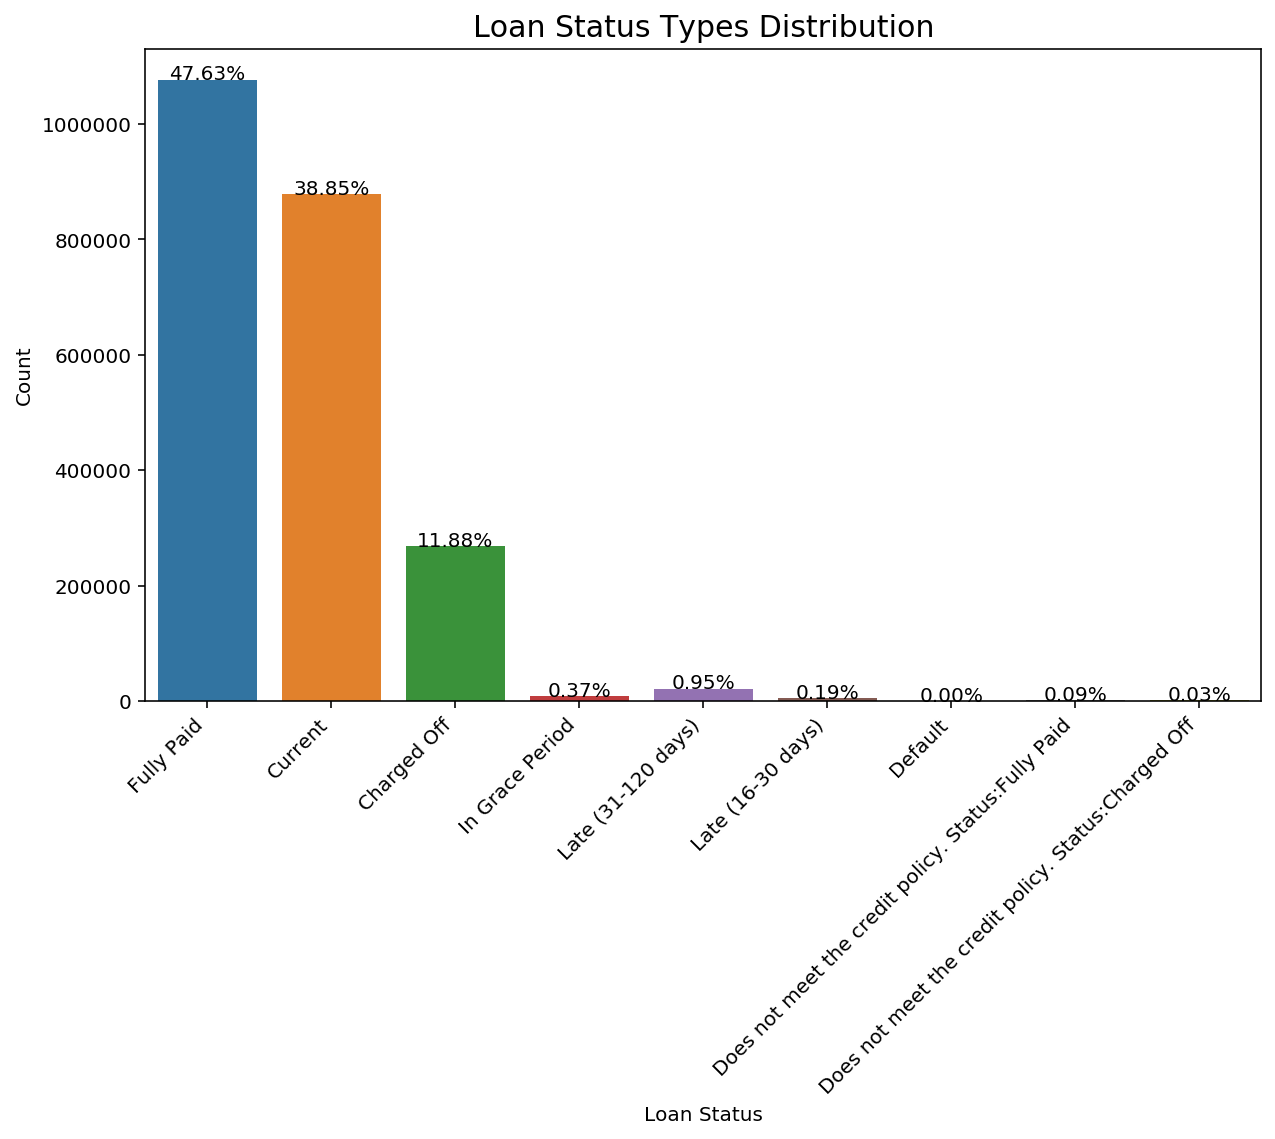

In [30]:
# Loan status distribution
plt.figure(figsize = (10,6))
ax = sns.countplot(x="loan_status", data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Loan Status", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Loan Status Types Distribution", fontsize=15)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2%}'.format(height/len(data)),
            ha="center", fontsize=10) 

In [31]:
# define bad_indicators
bad_indicators  =  ["Charged Off ",
                    "Charged Off",
                    "Default",
                    "Does not meet the credit policy. Status:Charged Off",
                    "In Grace Period",
                    "Default Receiver",
                    "Late (16-30 days)",
                    "Late (31-120 days)"]


In [32]:
# Creat a new target variable
data['target'] = data['loan_status'].isin(bad_indicators).astype(int)

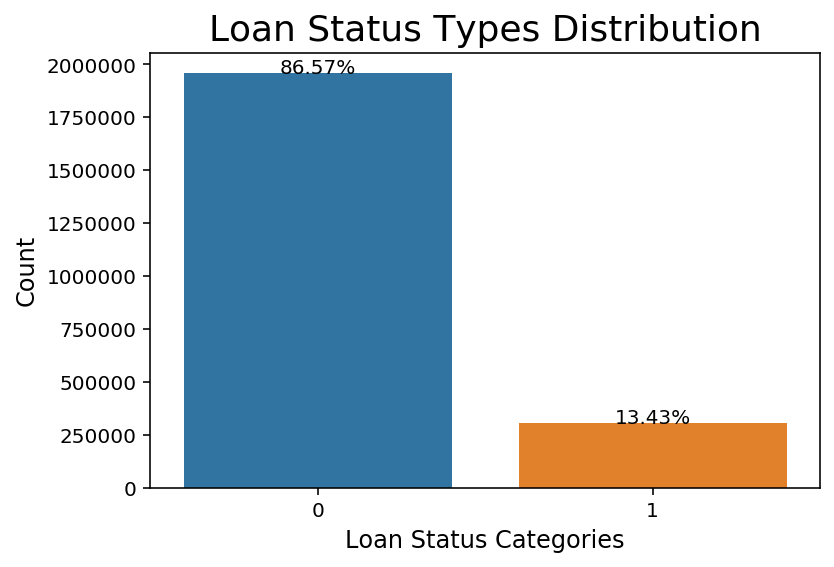

In [33]:
# "Good" and "Bad" Loans Distribution
ax = sns.countplot(x="target", data=data)
ax.set_xlabel("Loan Status Categories", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Loan Status Types Distribution", fontsize=18)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2%}'.format(height/len(data)),
            ha="center", fontsize=10) 

Noted the dataset is imbalanced with the minority group consisting of 13.43% of the population compared to the majarity group of 86.57%.

### Split Train Test Dataset

In [34]:

y = data['target']

# Split the dataset into training and test dataset with random sampling
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size=0.20, 
                                                random_state=1, stratify=y)


In [35]:
#Make sure the training and test set have similar distribution of majority and minority group 
ytrain.mean() 

0.13430214748520072

In [36]:
ytest.mean()

0.13430089309806384

# EDA

#### Overview of Loans 

Let's get some basic information about the loans of lending club. I will be focusing on the followings:

- loan amount vs funded amount

- Interest rate

- loans terms

- loan issue year

#### Loan Amount vs Funded Amount

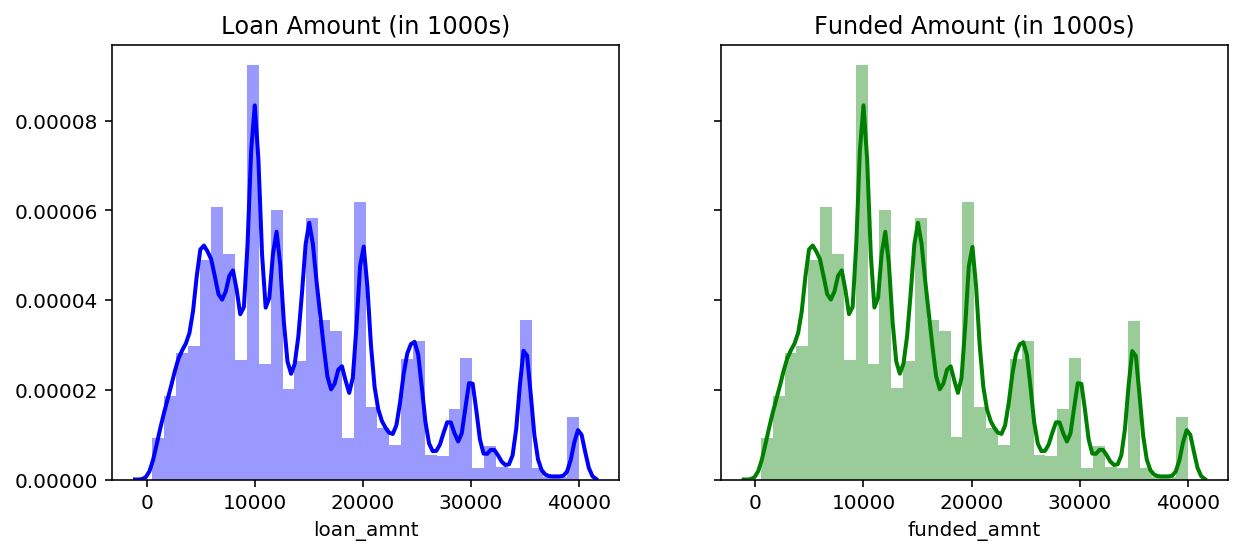

Loan Amount
Skewness: 0.777848
Kurtosis: -0.119390
Funded Amount
Skewness: 0.778844
Kurtosis: -0.116950
Average Loan Amount : 15044.23


In [37]:
# Compare Loan Amount and Funded Amount
f, axes = plt.subplots(1, 2, figsize=(10, 4),  sharey=True)
sns.distplot(xtrain['loan_amnt'], hist=True, kde=True, 
             bins=int(180/5),  color="b",
             kde_kws={'linewidth': 2}, ax = axes[0])
axes[0].set_title('Loan Amount (in 1000s)')
axes[0].set_xlabel('loan_amnt')


sns.distplot(xtrain['funded_amnt'], hist=True, kde=True, 
             bins=int(180/5),  color="g",
             kde_kws={'linewidth': 2}, ax = axes[1])
axes[1].set_title('Funded Amount (in 1000s)')
axes[1].set_xlabel('funded_amnt')
plt.show()

print("Loan Amount")
print("Skewness: %f" % xtrain['loan_amnt'].skew())
print("Kurtosis: %f" % xtrain['loan_amnt'].kurt())

print("Funded Amount")
print("Skewness: %f" % xtrain['funded_amnt'].skew())
print("Kurtosis: %f" % xtrain['funded_amnt'].kurt())

print("Average Loan Amount : " + str(round(xtrain.loan_amnt.mean(),2)))

#### Interest Rate

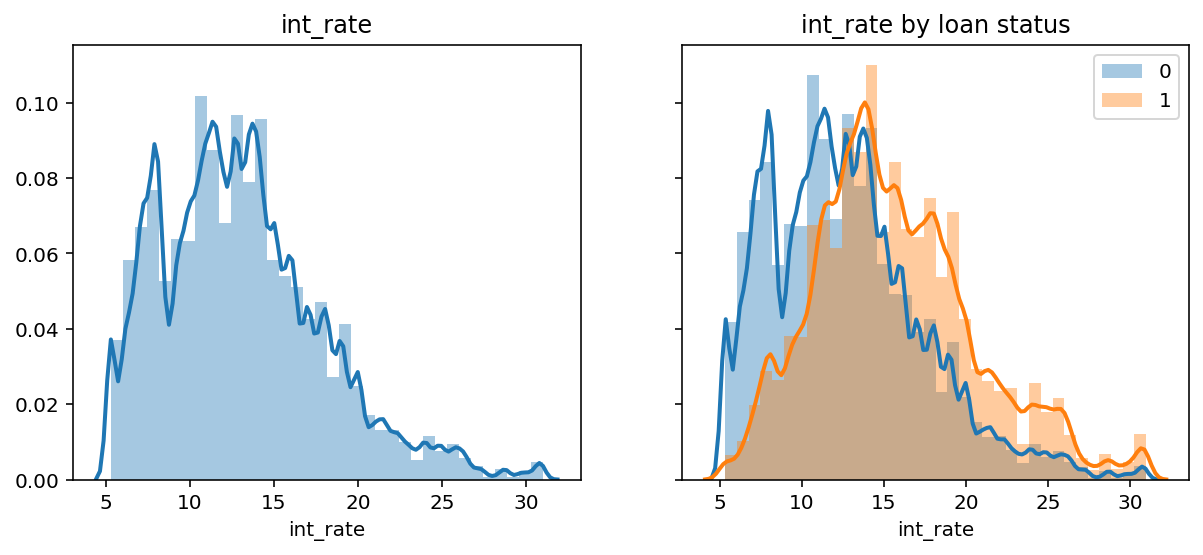

Skewness: 0.769178
Kurtosis: 0.597467


In [38]:
# Check distribution of loan interest rate
f, axes = plt.subplots(1, 2, figsize=(10, 4),  sharey=True)


sns.distplot(xtrain['int_rate'], hist=True, kde=True, 
             bins=int(180/5), 
             kde_kws={'linewidth': 2},ax = axes[0])
axes[0].set_xlabel('int_rate')
axes[0].set_title('int_rate')



sns.distplot(xtrain.loc[xtrain['target']==0,'int_rate'], hist=True, kde=True, 
             bins=int(180/5), label='0',
             kde_kws={'linewidth': 2},ax = axes[1])
sns.distplot(xtrain.loc[xtrain['target']==1,'int_rate'], hist=True, kde=True, 
             bins=int(180/5),  label='1',
             kde_kws={'linewidth': 2},ax = axes[1])
axes[1].set_xlabel('int_rate')
axes[1].set_title('int_rate by loan status')



plt.legend()
plt.show()

print("Skewness: %f" % xtrain['int_rate'].skew())
print("Kurtosis: %f" % xtrain['int_rate'].kurt())

In [39]:
print('Average Loan Interest Rate : ')
print('Good Loans:', xtrain.loc[xtrain['target']==0,'int_rate'].mean())
print('Bad Loans:', xtrain.loc[xtrain['target']==1,'int_rate'].mean())

Average Loan Interest Rate : 
Good Loans: 12.689932877459434
Bad Loans: 15.694198443769201


Based on the distribution plot and mean statistics, bad loans tend to have a high interest rate than good loans of lending club.

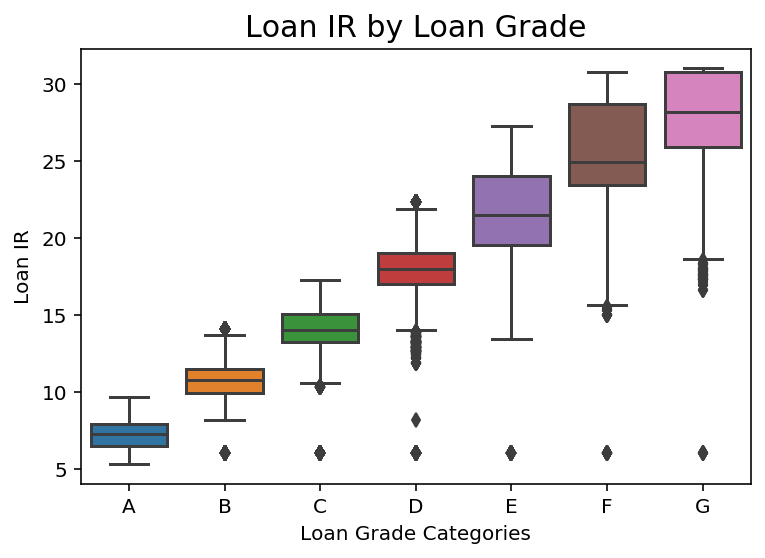

In [40]:
# Loan interest rate by loan grade
ax = sns.boxplot(x="grade", y="int_rate", data=xtrain, order=["A","B","C","D","E","F","G"])
                 
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("Loan Grade Categories", fontsize=10)
ax.set_ylabel("Loan IR", fontsize=10)
ax.set_title("Loan IR by Loan Grade", fontsize=15)
plt.show()

#### loans Terms


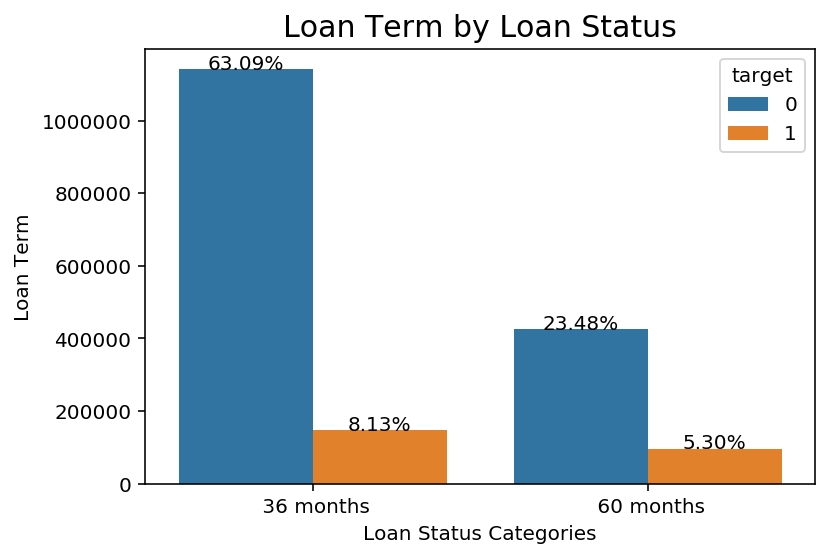

In [41]:
# Loan term by loan status
ax = sns.countplot( x="term",   hue="target", data=xtrain)               
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("Loan Status Categories", fontsize=10)
ax.set_ylabel("Loan Term", fontsize=10)
ax.set_title("Loan Term by Loan Status", fontsize=15)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/len(xtrain)*100),
            ha="center", fontsize=10) 



#### Loan Issue Year

In [42]:
# Convert issue date to year and month separate variables
xtrain["issue_year"]= pd.to_datetime(xtrain.issue_d).dt.year
#xtrain['issue_y'] = pd.to_datetime(issue_d).dt.year.dropna().astype('int32')

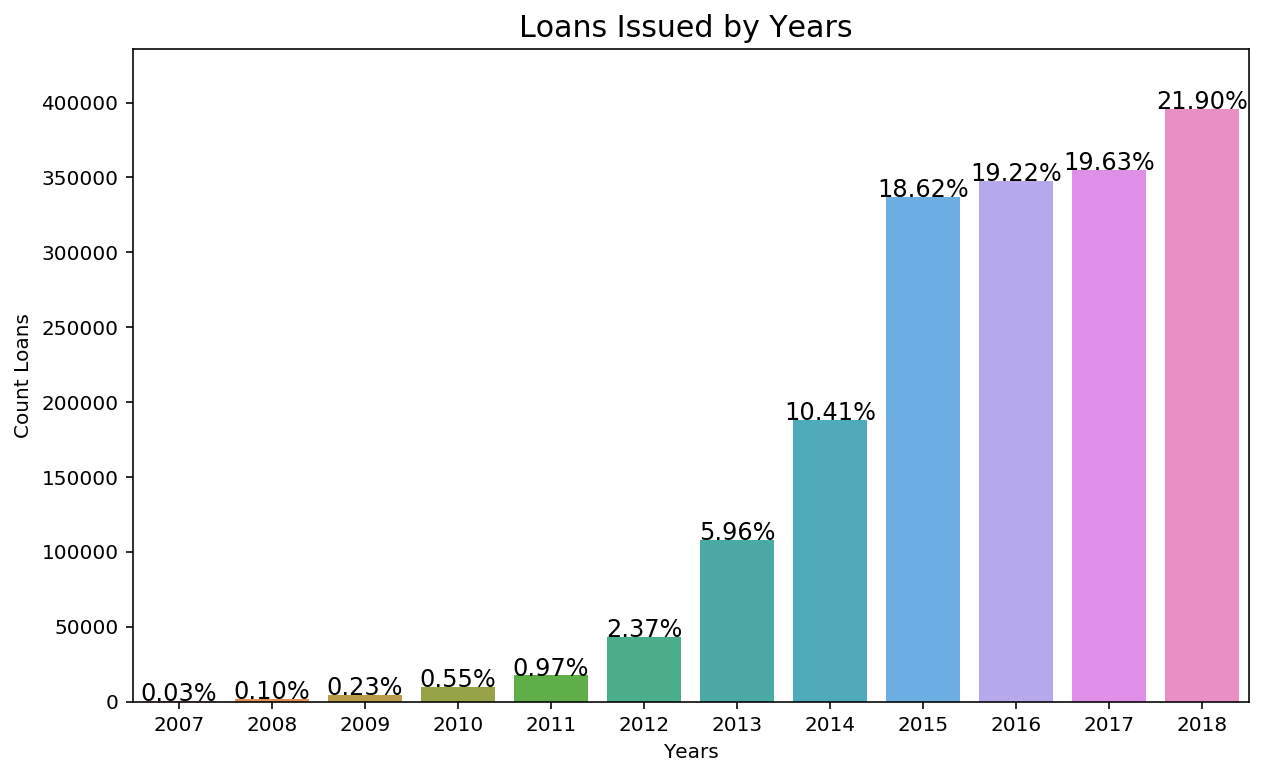

In [43]:
#Total Loans by Years - Good vs Bad
plt.figure(figsize=(10,6))
ax = sns.countplot(x = 'issue_year', data=xtrain)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("Years", fontsize=10)
ax.set_ylabel("Count Loans", fontsize=10)
ax.set_title("Loans Issued by Years ", fontsize=15)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/len(xtrain)*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)
plt.show()



#### Overview of Borrowers

Address (state)

Income

Average length of employment

Loan Grade

Home ownership

debt-to-income

Loan purpose

#### Borrower's Address(states)

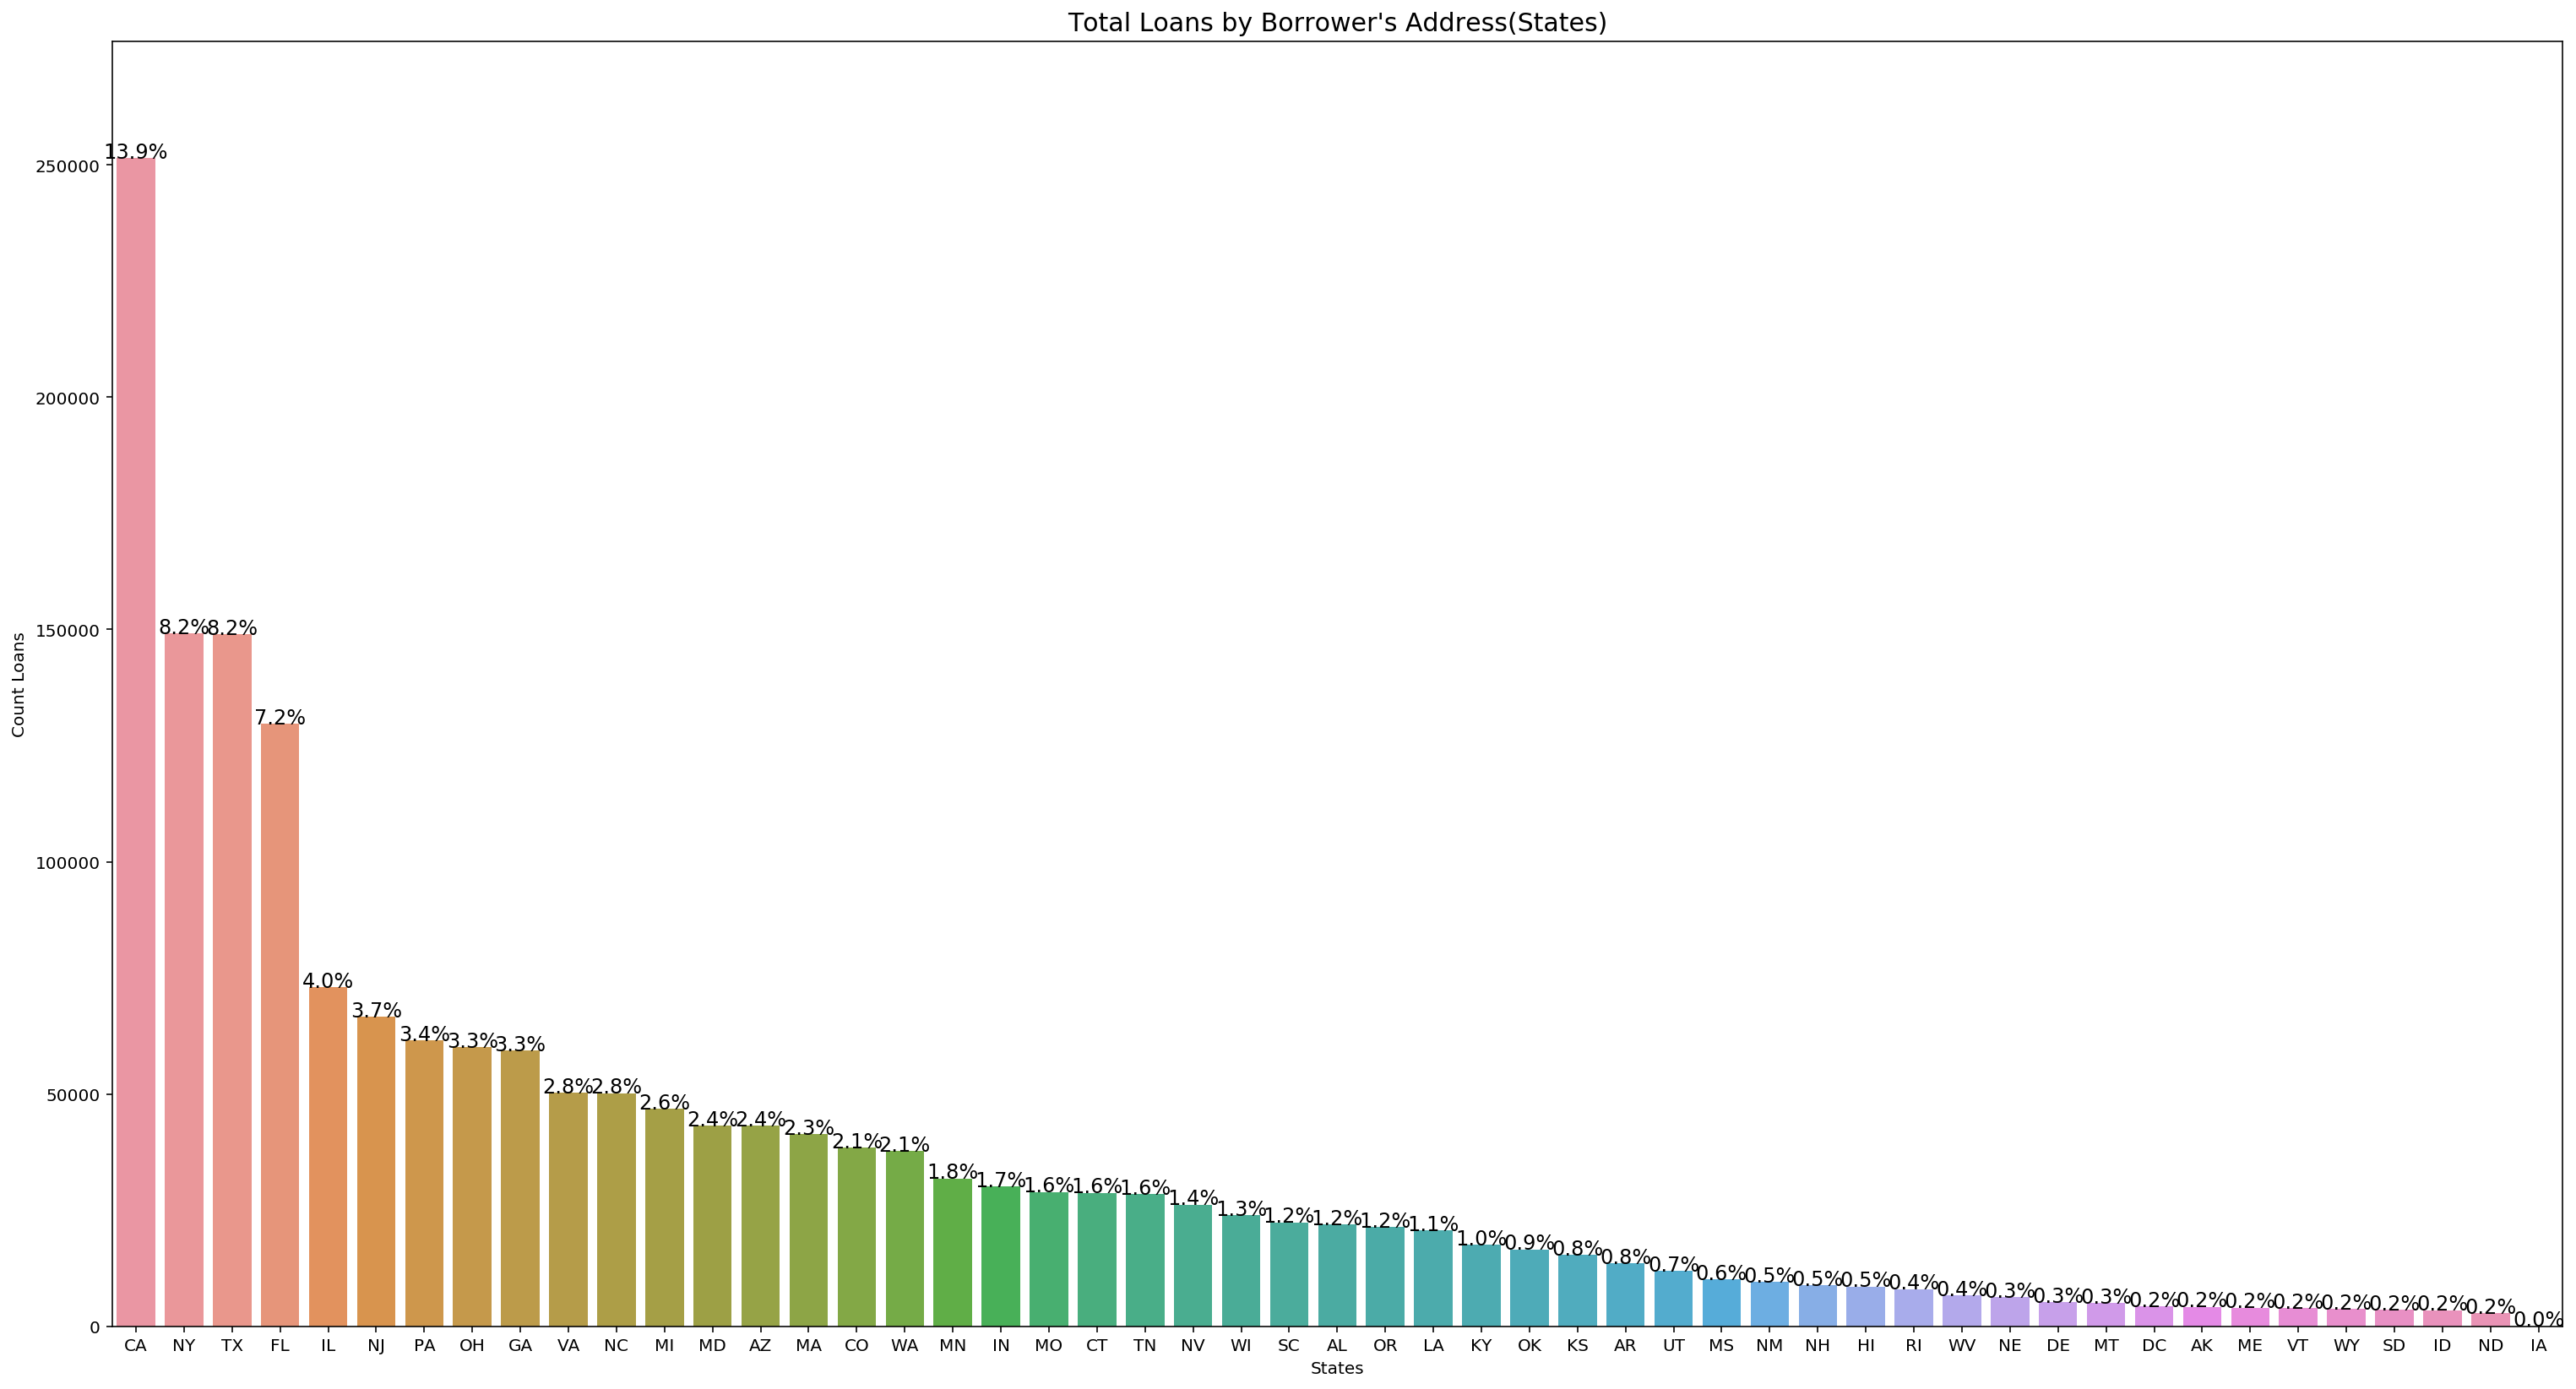

In [44]:
#Total Loans by States - Good vs Bad
plt.figure(figsize=(26,14))
ax = sns.countplot(x='addr_state', data=xtrain, 
                   order = xtrain['addr_state'].value_counts().index)
                   
ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("States", fontsize=10)
ax.set_ylabel("Count Loans", fontsize=10)
ax.set_title("Total Loans by Borrower's Address(States)", fontsize=15)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.1f}%'.format(height/len(xtrain)*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)
plt.show()

In [45]:
# Count good and bad loans by state
state_df = xtrain.groupby(['addr_state', 'target']).size().reset_index().pivot(
    columns='target', index='addr_state', values=0).sort_values(by=1, ascending = False)

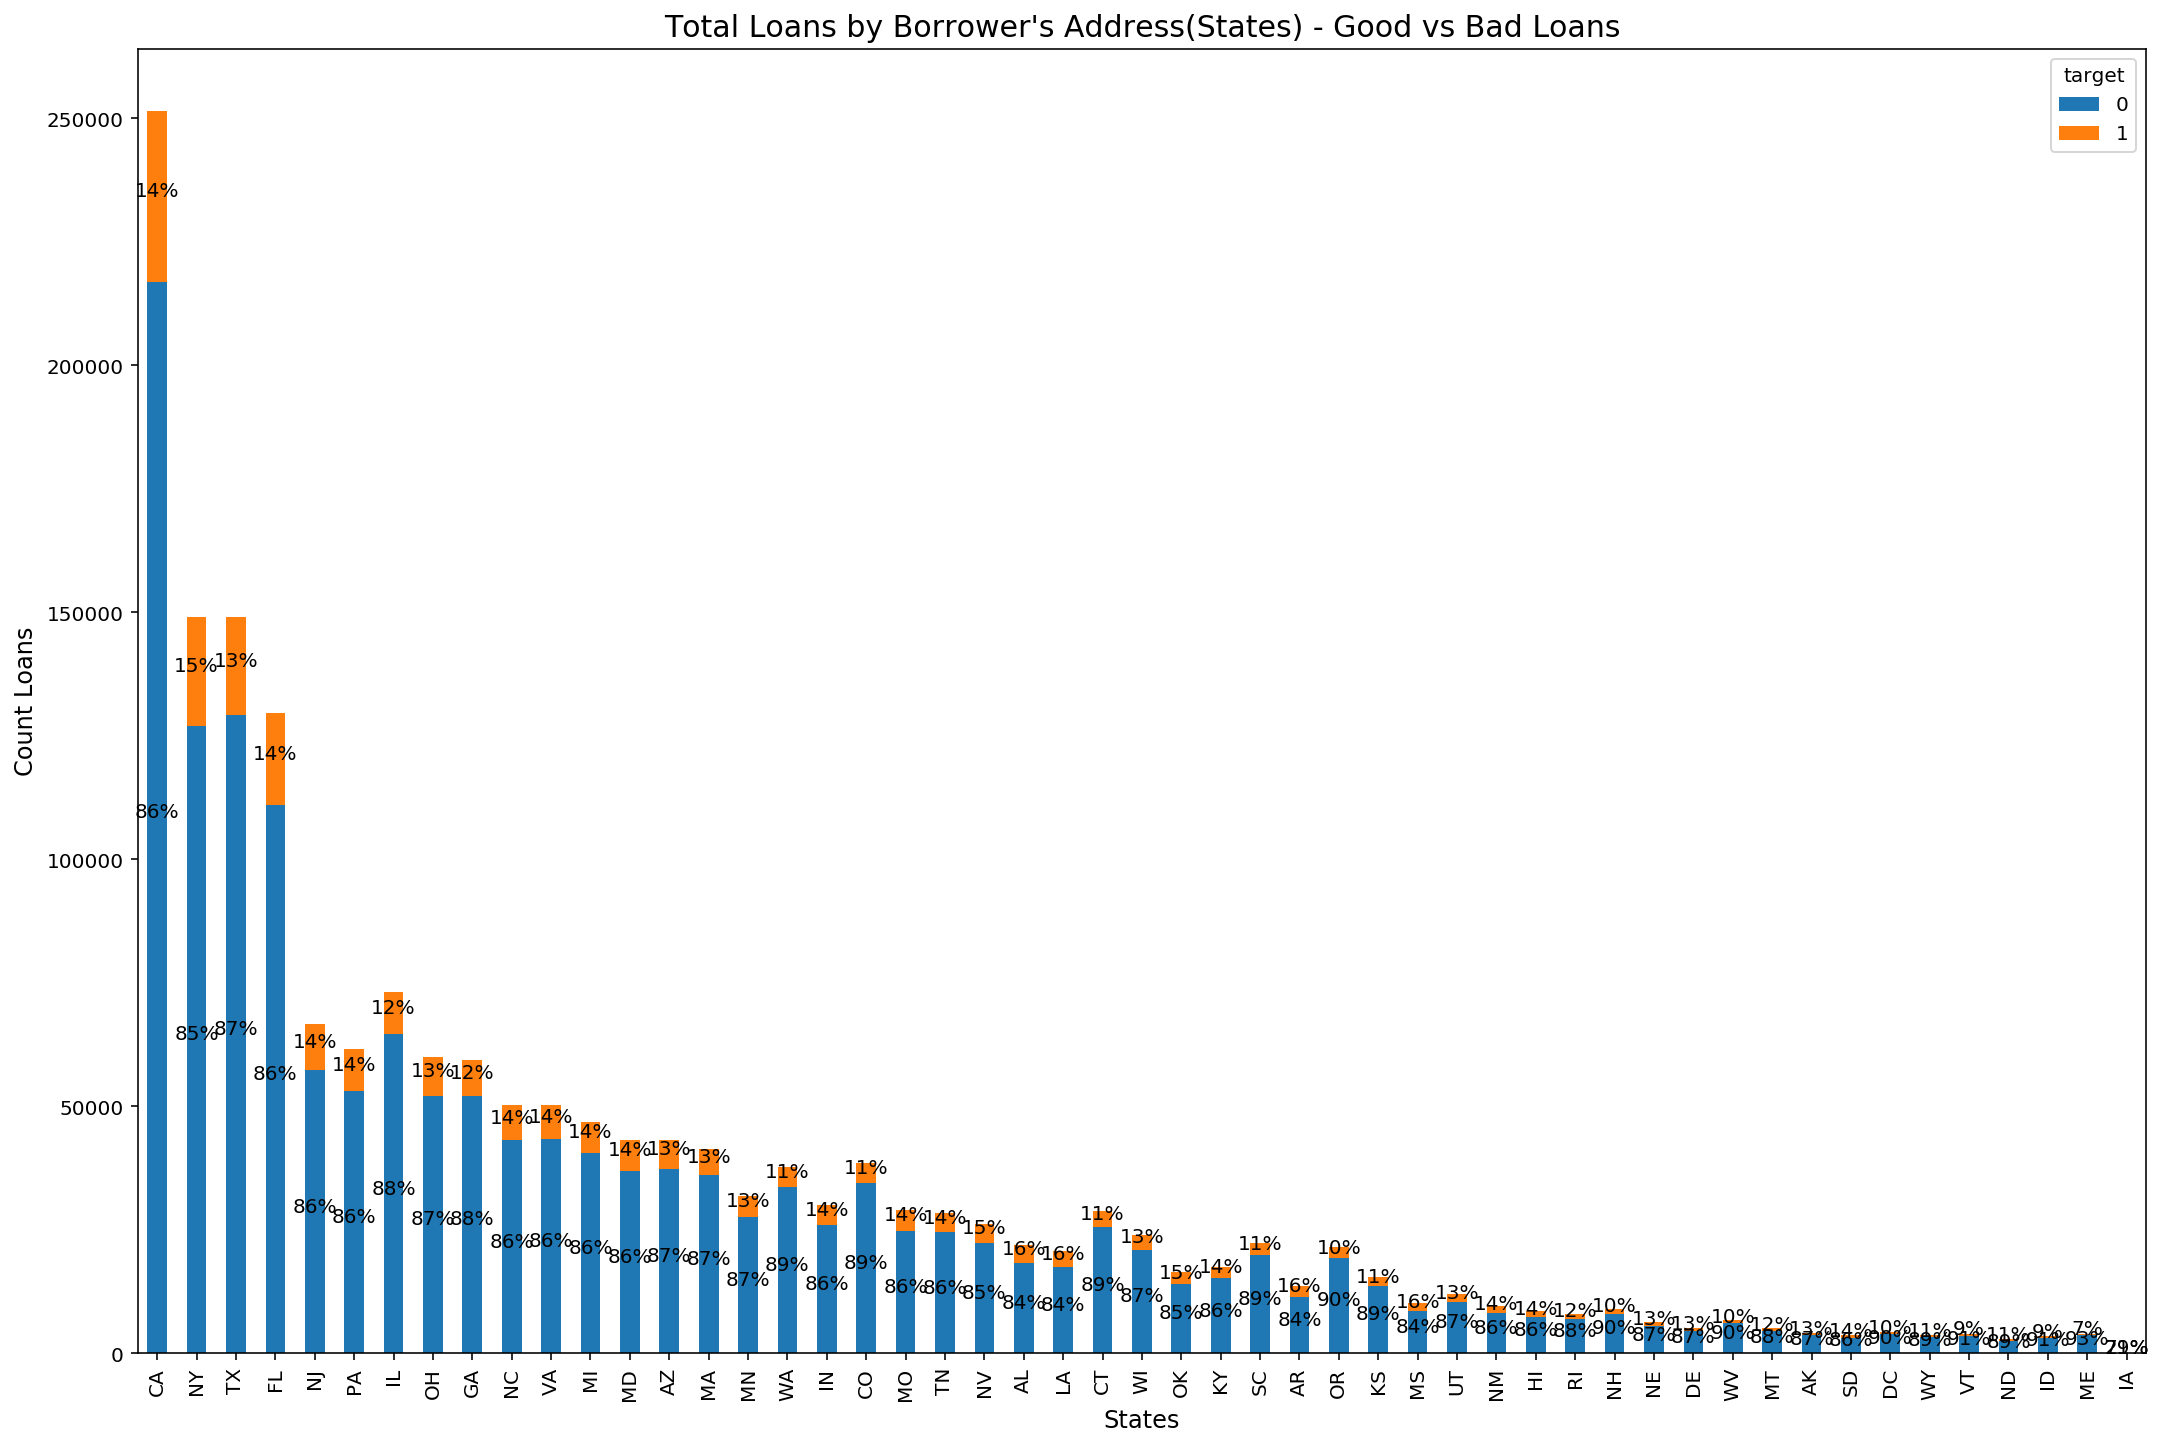

In [46]:
#Total Loans by States - Good vs Bad

ax = state_df.plot.bar(stacked=True ,figsize= (18, 12))
                             
#ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("States", fontsize=12)
ax.set_ylabel("Count Loans", fontsize=12)
ax.set_title("Total Loans by Borrower's Address(States) - Good vs Bad Loans", fontsize=15)
#sizes=[]


for i in range(51):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.0f}%'.format(height/(height + ax.patches[i+51].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(51,102):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.0f}%'.format(height/(height + ax.patches[i-51].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

In [47]:
state_df['default_rate'] =state_df[1]/(state_df[0]+state_df[1])

In [48]:
# Top 10 states with the lowest average default rate
state_df.sort_values(by='default_rate').head(10)

target,0,1,default_rate
addr_state,,,
ME,3701,288,0.072199
ID,3138,308,0.089379
VT,3578,364,0.092339
WV,6028,651,0.097470
NH,8012,873,0.098255
DC,3894,426,0.098611
OR,19270,2139,0.099911
SC,19961,2393,0.107050
CO,34375,4125,0.107143


In [49]:
# Top 10 states with the highest average default rate
state_df.sort_values(by='default_rate', ascending = False).head(10)

target,0,1,default_rate
addr_state,,,
IA,11,3,0.214286
AL,18313,3546,0.162222
AR,11431,2155,0.158619
MS,8481,1591,0.157963
LA,17377,3246,0.157397
OK,14004,2538,0.153428
NY,126976,22138,0.148464
NV,22291,3883,0.148353
FL,110911,18781,0.144812


#### Borrower's Annual Income

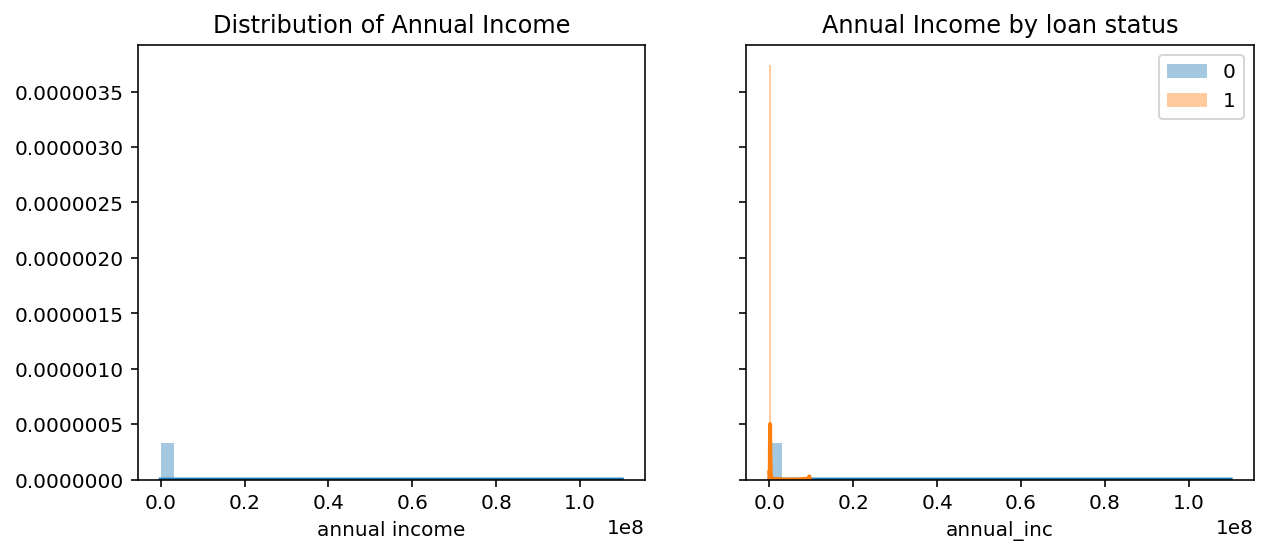

Skewness: 495.671570
Kurtosis: 411316.825794


In [50]:
# Check distribution of Borrower's Annual Income
# These plots are not very understandable becuase of skewness and outliers
f, axes = plt.subplots(1, 2, figsize=(10, 4),  sharey=True)

sns.distplot(xtrain['annual_inc'], hist=True, kde=True, bins=int(180/5), 
             kde_kws={'linewidth': 2},ax = axes[0])
axes[0].set_xlabel('annual income')
axes[0].set_title('Distribution of Annual Income')


sns.distplot(xtrain.loc[xtrain['target']==0,'annual_inc'], hist=True, kde=True, 
             bins=int(180/5), label='0', kde_kws={'linewidth': 2},ax = axes[1])
sns.distplot(xtrain.loc[xtrain['target']==1,'annual_inc'], hist=True, kde=True, 
             bins=int(180/5),  label='1', kde_kws={'linewidth': 2},ax = axes[1])
axes[1].set_xlabel('annual_inc')
axes[1].set_title('Annual Income by loan status')

plt.legend()
plt.show()

print("Skewness: %f" % xtrain['annual_inc'].skew())
print("Kurtosis: %f" % xtrain['annual_inc'].kurt())

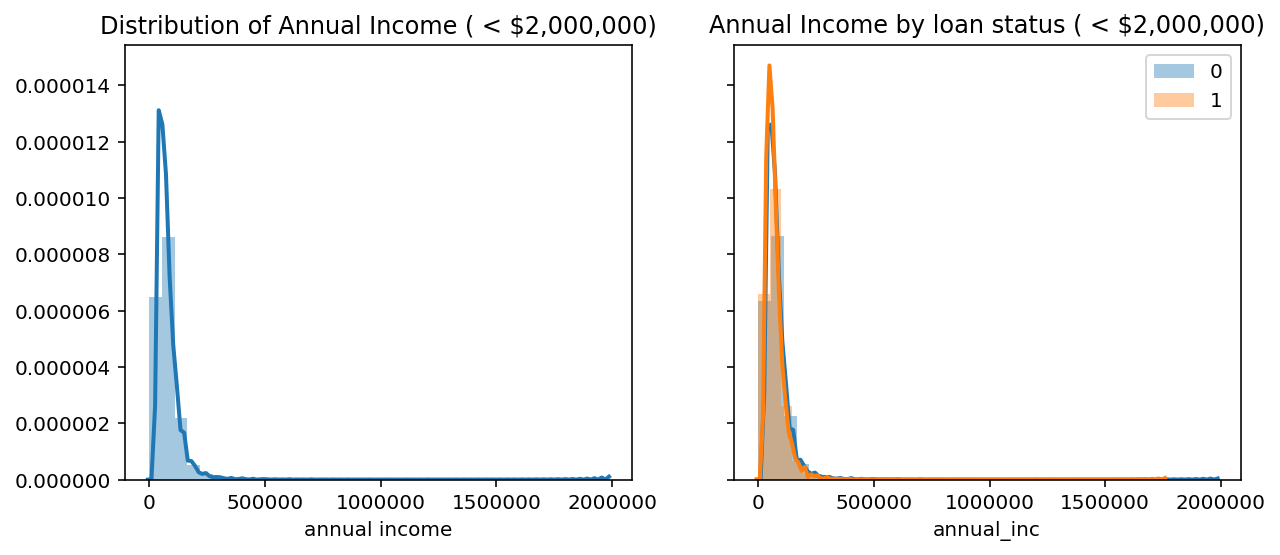

Skewness: 495.671570
Kurtosis: 411316.825794


In [51]:
# Check distribution of Borrower's Annual Income, filtered for annual_inc < $2,000,000
f, axes = plt.subplots(1, 2, figsize=(10, 4),  sharey=True)

sns.distplot(xtrain.loc[xtrain['annual_inc'] < 2000000,'annual_inc'], hist=True, kde=True, 
             bins=int(180/5), kde_kws={'linewidth': 2},ax = axes[0])
axes[0].set_xlabel('annual income')
axes[0].set_title('Distribution of Annual Income ( < $2,000,000)')

sns.distplot(xtrain.loc[(xtrain['target']==0) & (xtrain['annual_inc'] < 2000000),'annual_inc'], hist=True, kde=True, 
             bins=int(180/5), label='0',kde_kws={'linewidth': 2},ax = axes[1])
sns.distplot(xtrain.loc[(xtrain['target']==1) & (xtrain['annual_inc'] < 2000000),'annual_inc'], hist=True, kde=True, 
             bins=int(180/5),  label='1',kde_kws={'linewidth': 2},ax = axes[1])
axes[1].set_xlabel('annual_inc')
axes[1].set_title('Annual Income by loan status ( < $2,000,000)')

plt.legend()
plt.show()

print("Skewness: %f" % xtrain['annual_inc'].skew())
print("Kurtosis: %f" % xtrain['annual_inc'].kurt())

In [52]:
print('Annual Income Quantiles:')
print("Low Income (below 25%): Annual_Inc <",  np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.25) )
print("Median Income (between 25% and 75%):", np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.25),
       "< Annual_Inc <",
     np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.75))
print("High Income (above 75% below 95%): ", np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.75),
       "< Annual_Inc <",
     np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.95))
print("Extreme high income (Above 95%):  Annual_Inc >",
      np.quantile(np.array(xtrain['annual_inc'].dropna()), 0.95))

Annual Income Quantiles:
Low Income (below 25%): Annual_Inc < 46000.0
Median Income (between 25% and 75%): 46000.0 < Annual_Inc < 93000.0
High Income (above 75% below 95%):  93000.0 < Annual_Inc < 160000.0
Extreme high income (Above 95%):  Annual_Inc > 160000.0


In [53]:
# Count good and bad loans by state
income_df = xtrain[['annual_inc', 'target']]
income_df.loc[income_df['annual_inc'] < 46000.0,'inc_cat'] = 'low_inc'
income_df.loc[(income_df['annual_inc'] >= 46000.0)
              & (income_df['annual_inc'] < 93000.0),'inc_cat'] = 'median_inc'
income_df.loc[(income_df['annual_inc'] >= 93000.0)
              & (income_df['annual_inc'] < 160000.0),'inc_cat'] = 'high_inc'
income_df.loc[income_df['annual_inc'] > 160000.0,'inc_cat'] = 'xhigh_inc'

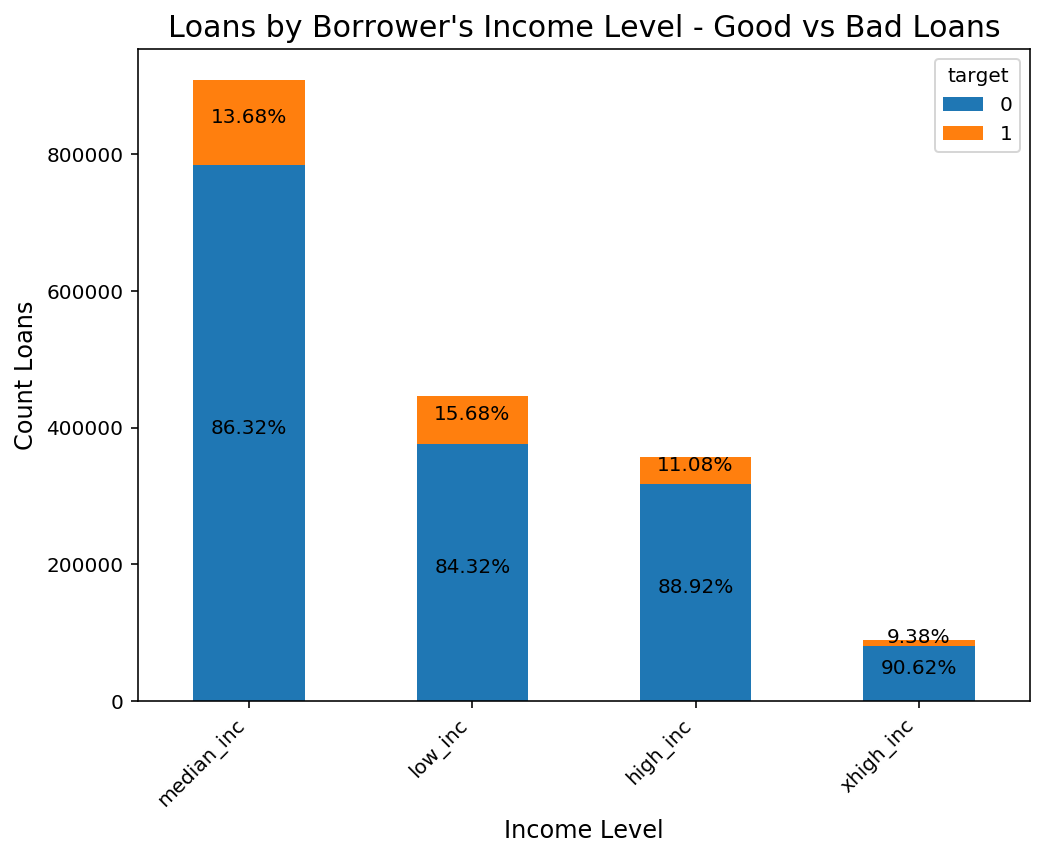

In [54]:
#Good vs Bad Loans by Income Level 
income_table = income_df.groupby(['inc_cat', 'target']).size().reset_index().pivot(
    columns='target', index='inc_cat', values=0).sort_values(by=1, ascending = False)
ax = income_table.plot.bar(stacked=True ,figsize= (8, 6))
                             
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Income Level", fontsize=12)
ax.set_ylabel("Count Loans", fontsize=12)
ax.set_title("Loans by Borrower's Income Level - Good vs Bad Loans", fontsize=15)
#sizes=[]

for i in range(4):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i+4].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(4,8):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i-4].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

We can see from the plot above, the higher the income level, the lower the loan default rate.

#### Borrower's employment length

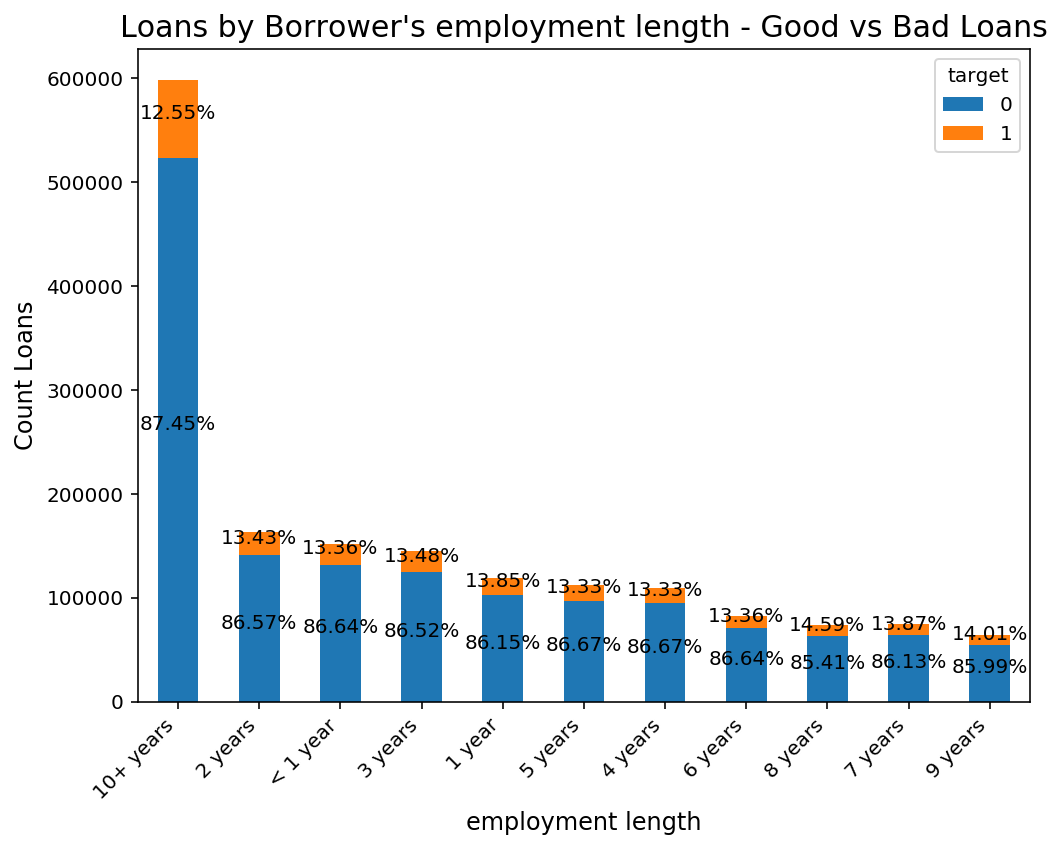

In [55]:
#Good vs Bad Loans by emp_length
emp_length_table = xtrain.groupby(['emp_length', 'target']).size().reset_index().pivot(
    columns='target', index='emp_length', values=0).sort_values(by=1, ascending = False)
ax = emp_length_table.plot.bar(stacked=True ,figsize= (8, 6))
                             
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("employment length", fontsize=12)
ax.set_ylabel("Count Loans", fontsize=12)
ax.set_title("Loans by Borrower's employment length - Good vs Bad Loans", fontsize=15)
#sizes=[]

n = len(ax.patches)
for i in range(int(n/2)):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i+ int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(int(n/2),n):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i- int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

In [56]:
# The employment length of largest two groups of borrowers
print('Percentage of borrowers ')
print('emp_length > 10+ ys: ', round((xtrain.emp_length.value_counts()/len(xtrain)).values[0],4))
print('emp_length <= 3 ys: ', round(sum((xtrain.emp_length.value_counts()/len(xtrain)).values[1:4]),4))

Percentage of borrowers 
emp_length > 10+ ys:  0.3308
emp_length <= 3 ys:  0.2541


There is no clear pattern between loan default and employment length. Noted that both people with long employment length(10+ years) and short employment length(<= 3 years) tend to borrow more. 

#### Loan Grade

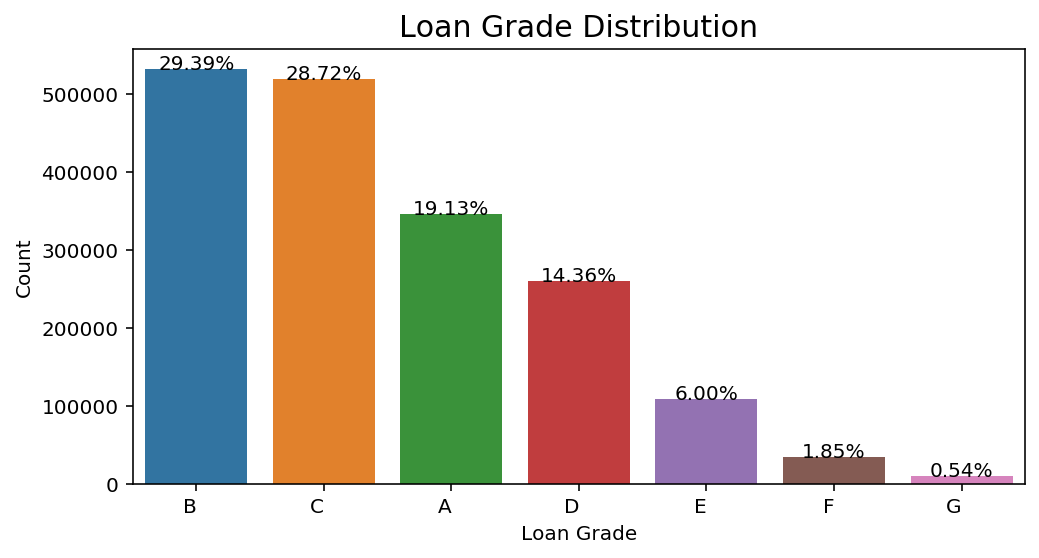

In [57]:
# Loan grade distribution 
plt.figure(figsize = (8,4))
ax = sns.countplot(x="grade", data=xtrain, order= xtrain.grade.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right')
ax.set_xlabel("Loan Grade", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Loan Grade Distribution", fontsize=15)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/len(xtrain)*100),
            ha="center", fontsize=10) 

The majority of the loans are graded as A, B, C

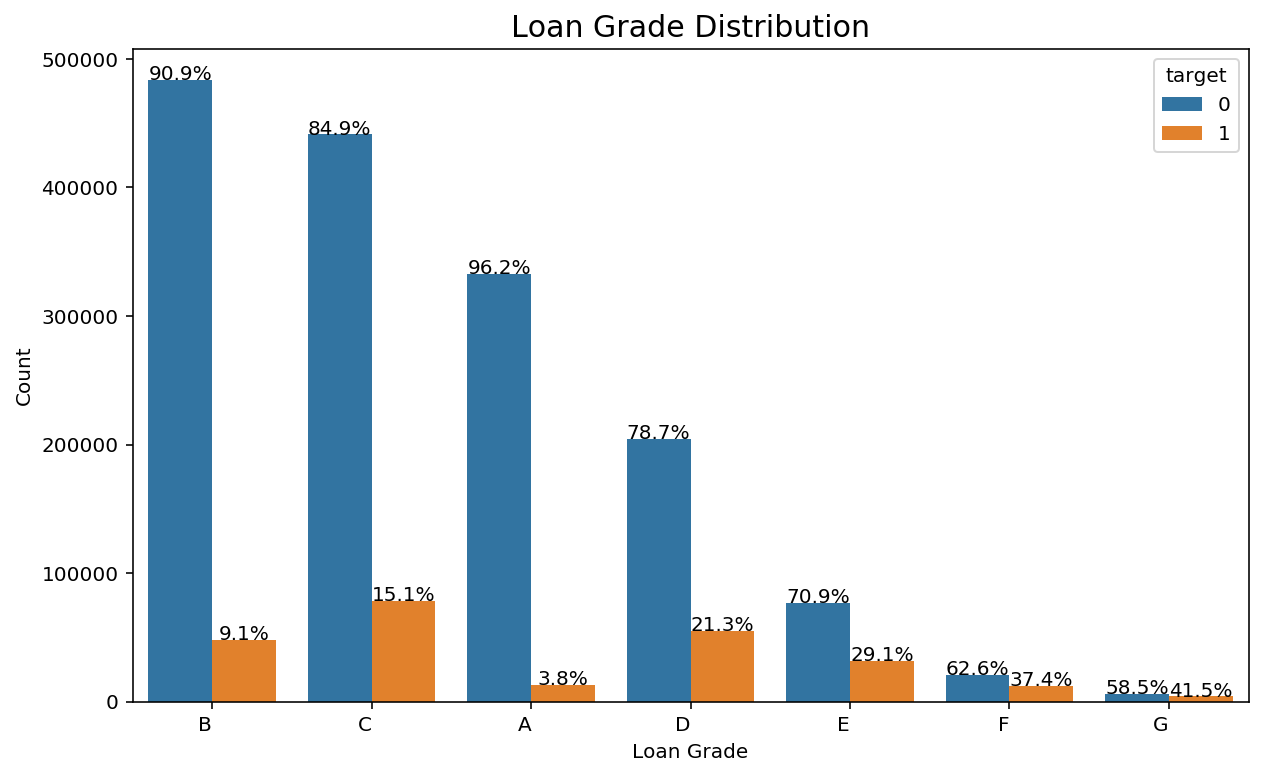

In [58]:
#Loan Grade between 'good' and 'bad' loans
plt.figure(figsize = (10,6))
ax = sns.countplot(x="grade",hue="target", data=xtrain, order = xtrain.grade.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right')
ax.set_xlabel("Loan Grade", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Loan Grade Distribution", fontsize=15)
sizes=[]
n = len(ax.patches)
for i in range(int(n/2)):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height,
            '{:1.1f}%'.format(height/(height + ax.patches[i+ int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(int(n/2),n):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height,
            '{:1.1f}%'.format(height/(height + ax.patches[i- int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

From the plot above, noted that the better the loan grade, the lower the "bad" loan ratios

#### Home ownership

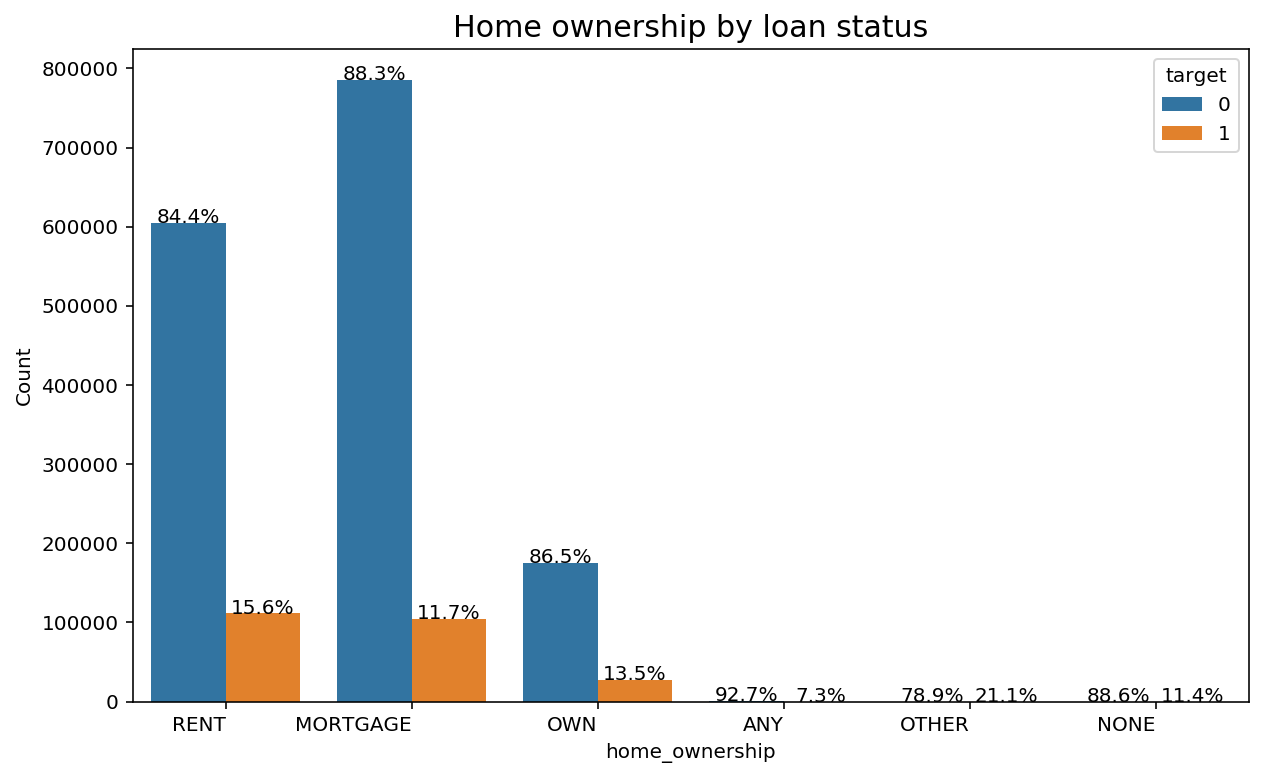

In [59]:
#Homeownership and Loan Status
plt.figure(figsize = (10,6))
ax = sns.countplot(x="home_ownership",hue="target", data=xtrain)
ax.set_xticklabels(ax.get_xticklabels(),horizontalalignment='right')
ax.set_xlabel("home_ownership", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Home ownership by loan status", fontsize=15)
sizes=[]
n = len(ax.patches)
for i in range(int(n/2)):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height,
            '{:1.1f}%'.format(height/(height + ax.patches[i+ int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(int(n/2),n):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height,
            '{:1.1f}%'.format(height/(height + ax.patches[i- int(n/2)].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

#### debt-to-income
A ratio of the borrower’s total monthly debt payments on the total debt obligations divided by the borrower’s self-reported monthly income. This ratio reveals the ability of borrower to repay their loans with their income.

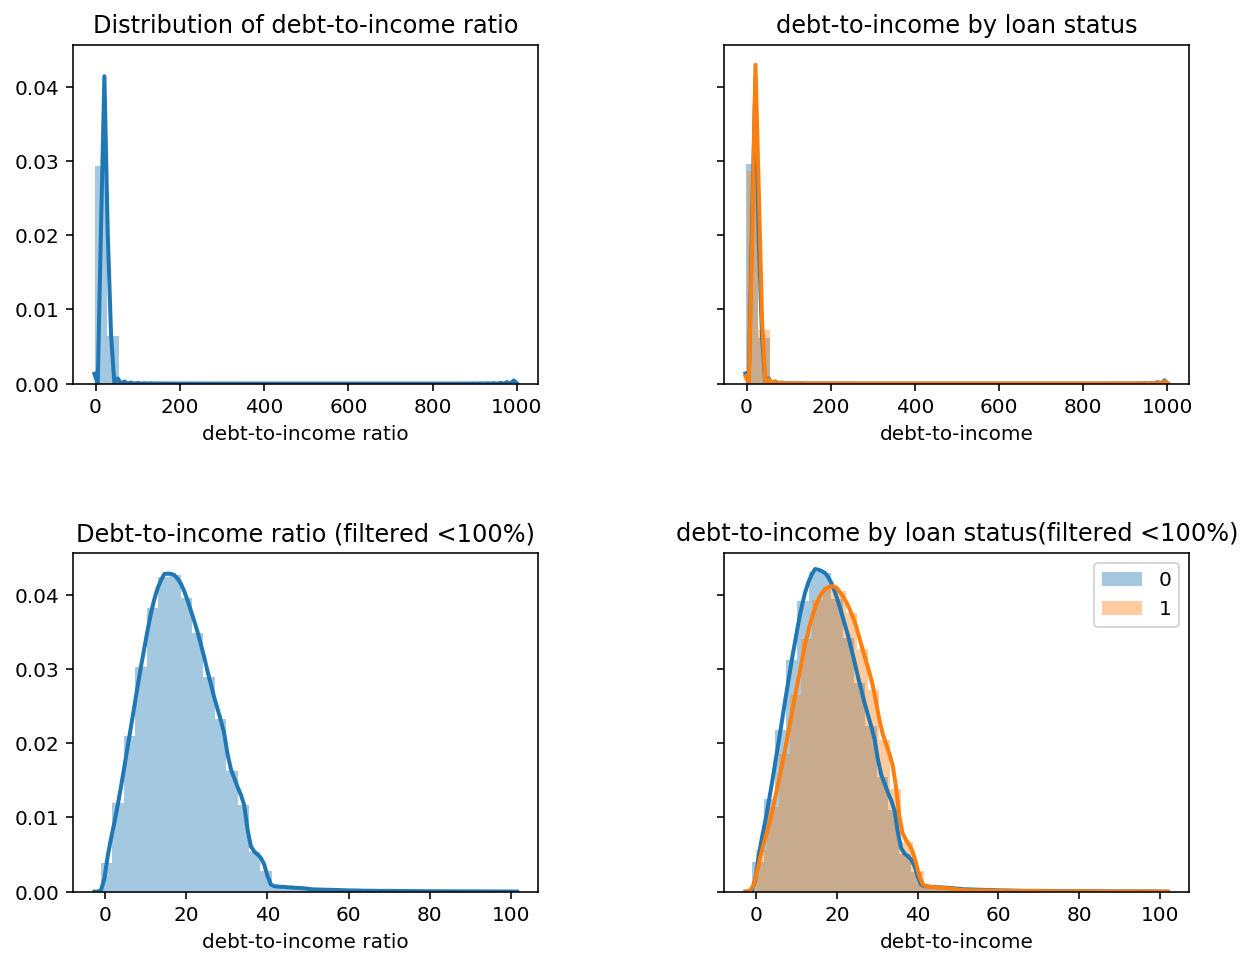

Skewness: 29.252373
Kurtosis: 1750.309492


In [60]:
# Check distribution of loan interest rate
f, axes = plt.subplots(2, 2, figsize=(10, 6),  sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
# Histogram 1 - debt-to-income ratio
sns.distplot(xtrain['dti'], hist=True, kde=True, 
             bins=int(180/5), 
             kde_kws={'linewidth': 2},ax = axes[0, 0])
axes[0,0].set_xlabel('debt-to-income ratio')
axes[0,0].set_title('Distribution of debt-to-income ratio')

# Histogram 2 - debt-to-income ratio between bad and good loans
sns.distplot(xtrain.loc[xtrain['target']==0,'dti'], hist=True, kde=True, 
             bins=int(180/5), label='0',
             kde_kws={'linewidth': 2},ax = axes[0,1 ])
sns.distplot(xtrain.loc[xtrain['target']==1,'dti'], hist=True, kde=True, 
             bins=int(180/5),  label='1',
             kde_kws={'linewidth': 2},ax = axes[0, 1])
axes[0,1].set_xlabel('debt-to-income')
axes[0,1].set_title('debt-to-income by loan status')

# Histogram 3 - debt to income ratio filtered for less-than-100-percent
sns.distplot(xtrain.loc[xtrain['dti']<100,"dti"], hist=True, kde=True, 
             bins=int(180/5), 
             kde_kws={'linewidth': 2},ax = axes[1,0])
axes[1,0].set_xlabel('debt-to-income ratio')
axes[1,0].set_title('Debt-to-income ratio (filtered <100%)')

#Histogram 4 - debt-to-income ratio between good and bad loans filtered for less-than-100-percent
sns.distplot(xtrain.loc[(xtrain['dti']<100) & (xtrain['target']==0),'dti'], 
             hist=True, kde=True, 
             bins=int(180/5), label='0',
             kde_kws={'linewidth': 2},ax = axes[1,1])
sns.distplot(xtrain.loc[(xtrain['dti']<100) & (xtrain['target']==1),'dti'], 
            hist=True, kde=True, 
             bins=int(180/5),  label='1',
             kde_kws={'linewidth': 2},ax = axes[1,1])
axes[1,1].set_xlabel('debt-to-income')
axes[1,1].set_title('debt-to-income by loan status(filtered <100%)')


plt.legend()
plt.show()

print("Skewness: %f" % xtrain['dti'].skew())
print("Kurtosis: %f" % xtrain['dti'].kurt())

In [61]:
print("Debt-to-income ratio")
print("Good loans", xtrain.loc[xtrain['target']==0,'dti'].median())
print("Bad loans", xtrain.loc[xtrain['target']==1,'dti'].median())

Debt-to-income ratio
Good loans 17.56
Bad loans 19.65


Since the debt-to-income ratio is highly right skewed, I filtered for data with debt-to-income less than 100% to get a closer look to the majority of the data. The debt-to-income ratio has a distribution really close to a normal distribution between 0 and 40%. On average, the debt-to-income ratio is higher for the bad loans than the good loans.

In [62]:
print('Debt-to-income(dti) Quantiles:')
print("Low dti (below 25%): dti <",  np.quantile(np.array(xtrain['dti'].dropna()), 0.25) )
print("Median dti (between 25% and 75%):", np.quantile(np.array(xtrain['dti'].dropna()), 0.25),
       "<= dti <",  np.quantile(np.array(xtrain['dti'].dropna()), 0.75))
print("High dti (above 75% below 95%): ", np.quantile(np.array(xtrain['dti'].dropna()), 0.75),
       "<= dti <", np.quantile(np.array(xtrain['dti'].dropna()), 0.95))
print("Extreme high dti (Above 95%): dti >",
      np.quantile(np.array(xtrain['dti'].dropna()), 0.95))

Debt-to-income(dti) Quantiles:
Low dti (below 25%): dti < 11.89
Median dti (between 25% and 75%): 11.89 <= dti < 24.48
High dti (above 75% below 95%):  24.48 <= dti < 33.88
Extreme high dti (Above 95%): dti > 33.88


In [63]:
# Count good and bad loans by state
dti_df = xtrain[['dti', 'target']]
dti_df.loc[dti_df['dti'] < 11.89,'dti_cat'] = 'low'
dti_df.loc[(dti_df['dti'] >= 11.89)
              & (dti_df['dti'] < 24.48),'dti_cat'] = 'median'
dti_df.loc[(dti_df['dti'] >= 24.48)
              & (dti_df['dti'] < 33.88),'dti_cat'] = 'high'
dti_df.loc[dti_df['dti'] > 33.88,'dti_cat'] = 'xhigh'

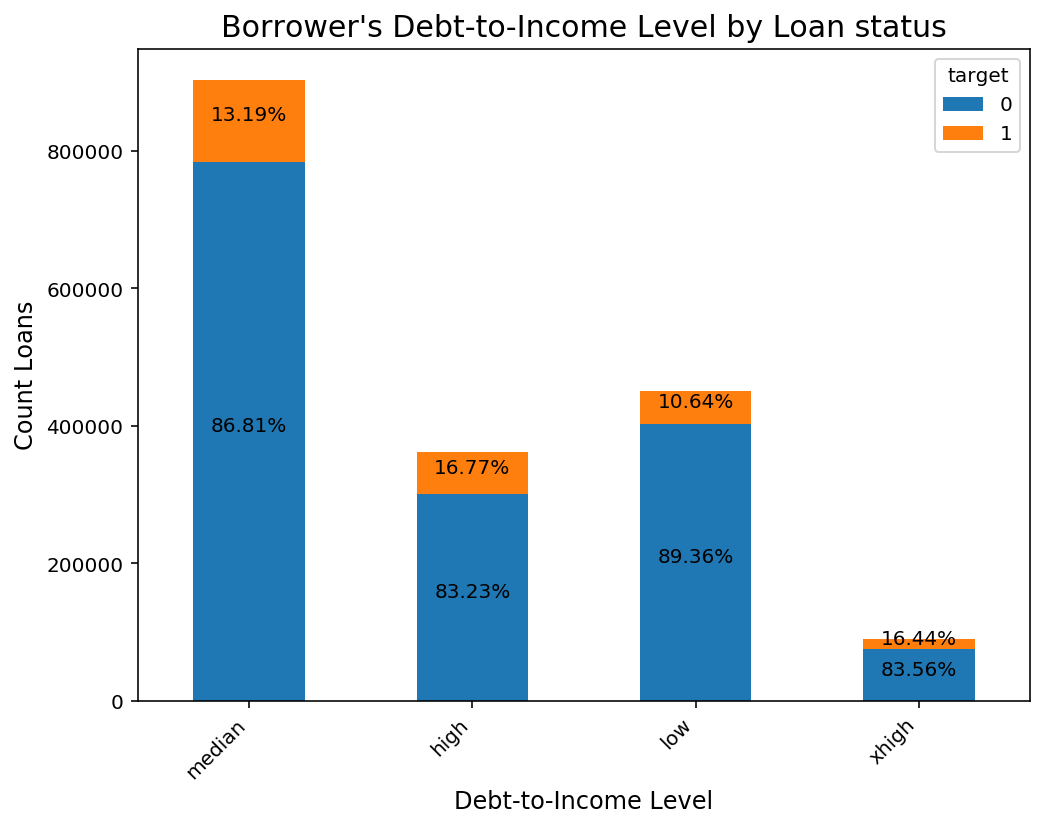

In [64]:
#Good vs Bad Loans by Income Level 
dti_table = dti_df.groupby(['dti_cat', 'target']).size().reset_index().pivot(
    columns='target', index='dti_cat', values=0).sort_values(by=1, ascending = False)
ax = dti_table.plot.bar(stacked=True ,figsize= (8, 6))
                             
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Debt-to-Income Level", fontsize=12)
ax.set_ylabel("Count Loans", fontsize=12)
ax.set_title("Borrower's Debt-to-Income Level by Loan status", fontsize=15)
#sizes=[]

for i in range(4):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i+4].get_height()) *100),
            ha="center", fontsize=10)
    
for i in range(4,8):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2.,
            y + height/2,
            '{:1.2f}%'.format(height/(height + ax.patches[i-4].get_height()) *100),
            ha="center", fontsize=10)
plt.show()

#### Loan Purpose 

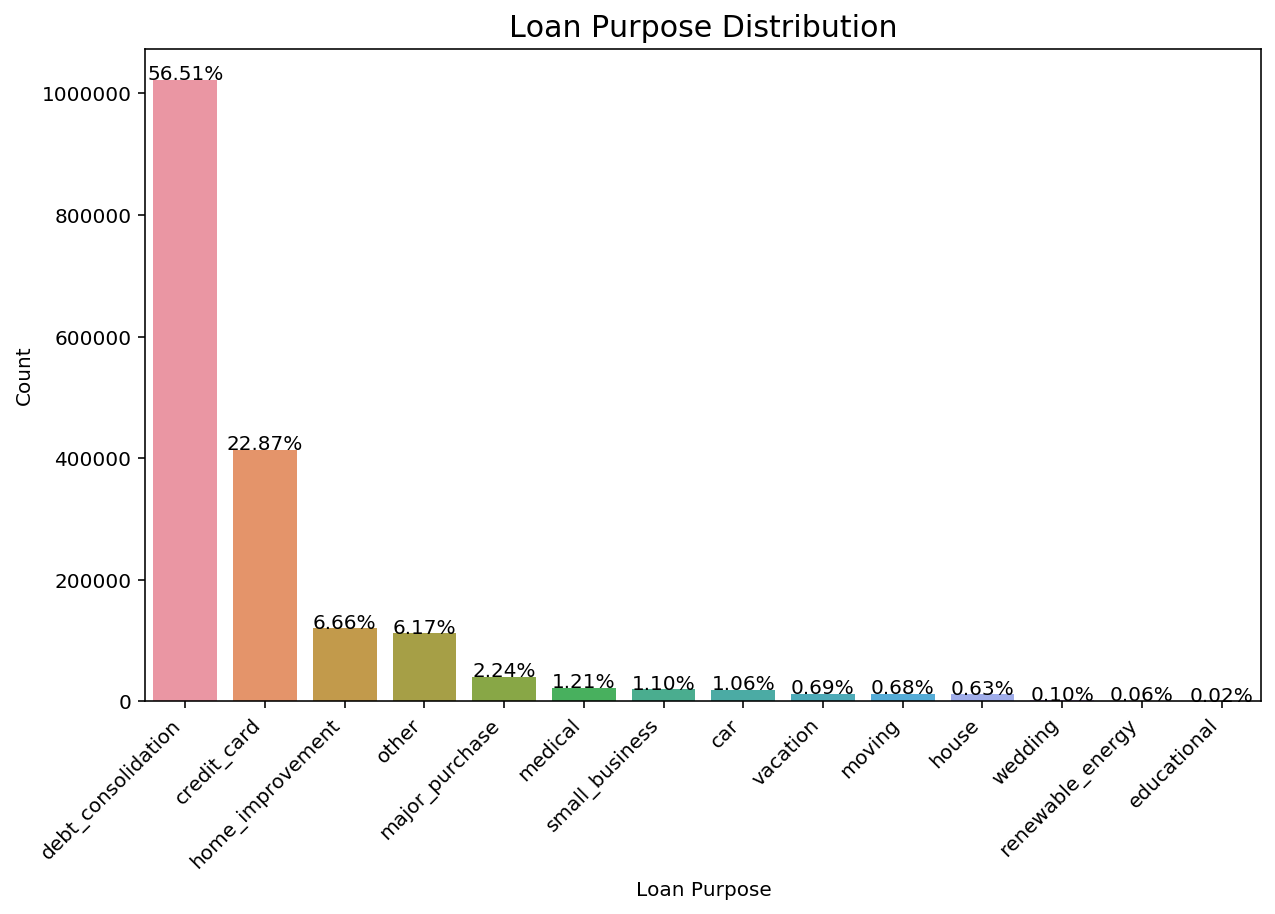

In [65]:
# Loan purpose distribution
plt.figure(figsize = (10,6))
ax = sns.countplot(x="purpose", data=xtrain, order = xtrain.purpose.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Loan Purpose", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Loan Purpose Distribution", fontsize=15)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/len(xtrain)*100),
            ha="center", fontsize=10) 

Noted that about 56% of the loans are used for debt_consolidation, 22.87% for  credit card, and 6.66% for home_improvement. 

### Colinearity

To detect colinearity among variables,  we can simply create a correlation matrix and find variable pairs with large absolute values. However, multicolinearity is much harder to detect with this method as it involves more than 2 variables. Right now, we focus on identifying colinearity within the data. Later, we will apply Variance Inflation Factor (VIF) method to detect multicolinearity. 

In [66]:
# Separate numerica variables and categorical variables
cols = xtrain.columns.tolist()
num_cols = xtrain._get_numeric_data().columns.tolist()
cat_cols = [x for x in cols if x not in num_cols] 

#### Correlation analysis with pearson method

In [67]:
#  Correlation analysis with pearson method
xtrain_pcorr_matrix = xtrain[num_cols].corr(method="pearson")

In [68]:
with open('xtrain_pcorr.pickle', 'wb') as f:
    pickle.dump(xtrain_pcorr_matrix, f)
# with open('xtrain_pcorr.pickle', 'rb') as f:
#     xtrain_pcorr_matrix = pickle.load(f)

In [69]:
# High correlation with target variables using pearson method
pcorr_target = xtrain_pcorr_matrix["target"].abs().sort_values(kind="quicksort", ascending=False)
pcorr_target.head(12)

target                     1.000000
int_rate                   0.211981
sec_app_fico_range_low     0.138020
sec_app_fico_range_high    0.138019
fico_range_low             0.122275
fico_range_high            0.122273
issue_year                 0.116399
sec_app_inq_last_6mths     0.099210
acc_open_past_24mths       0.094778
inq_last_6mths             0.085028
num_tl_op_past_12m         0.083668
bc_open_to_buy             0.082026
Name: target, dtype: float64

In [70]:
# Unstack covariance matrix pairs
xtrain_pcorr_sorted = xtrain_pcorr_matrix.abs().unstack().sort_values(kind="quicksort",
                                                                      ascending=False)

In [71]:
# Table of variable pairs and correlation coefficients - pearson method
pcorr_df = pd.DataFrame([xtrain_pcorr_sorted[xtrain_pcorr_sorted != 1.0].drop_duplicates()]).T.reset_index()
# Sorted for highest correlated variable pairs
pcorr_df.head(10)

,level_0,level_1,0
0,sec_app_fico_range_high,sec_app_fico_range_low,1.000000
1,fico_range_low,fico_range_high,1.000000
2,funded_amnt,loan_amnt,0.999757
3,num_sats,open_acc,0.998965
4,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.983665
5,tot_hi_cred_lim,tot_cur_bal,0.975460
6,total_bal_il,total_il_high_credit_limit,0.952008
7,funded_amnt,installment,0.945992
8,installment,loan_amnt,0.945652
9,total_bal_ex_mort,total_bal_il,0.898994


In [72]:
# Create two lists, one with correlation higher than 0.7 , one with correlation higher than 0.9
# Compare the two variables in each high-correlation pairs, and choose the variable with the higher average correlations with all other variables within the dataset.
pcorr9_cols=set()
pcorr7_cols=set()
for i in range(len(pcorr_df)):
    if pcorr_df[0][i] >= 0.7:
        if xtrain_pcorr_matrix[pcorr_df.level_0[i]].abs().mean()> xtrain_pcorr_matrix[pcorr_df.level_1[i]].abs().mean():
            pcorr7_cols.add(pcorr_df.level_0[i])     
        else :
            pcorr7_cols.add(pcorr_df.level_1[i])
            
    if pcorr_df[0][i] >= 0.9:
        if xtrain_pcorr_matrix[pcorr_df.level_0[i]].abs().mean()> xtrain_pcorr_matrix[pcorr_df.level_1[i]].abs().mean():
            pcorr9_cols.add(pcorr_df.level_0[i])     
        else :
            pcorr9_cols.add(pcorr_df.level_1[i])
            
              

In [73]:
# variables with corr >= 0.7
pcorr7_cols

{'acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc_joint',
 'bc_util',
 'fico_range_low',
 'funded_amnt',
 'loan_amnt',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_recent_bc_dlq',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_op_past_12m',
 'open_acc',
 'open_il_24m',
 'open_rv_24m',
 'revol_util',
 'sec_app_fico_range_high',
 'sec_app_open_acc',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_acc',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'total_rev_hi_lim'}

In [74]:
# variables with corr >=0.9
pcorr9_cols

{'fico_range_low',
 'funded_amnt',
 'loan_amnt',
 'num_actv_rev_tl',
 'open_acc',
 'sec_app_fico_range_high',
 'tot_hi_cred_lim',
 'total_il_high_credit_limit'}

#### Correlation analysis with spearman method

In [75]:
#  Correlation analysis with spearman method
xtrain_spcorr_matrix = xtrain[num_cols].corr(method="spearman")
xtrain_spcorr_sorted = xtrain_spcorr_matrix.abs().unstack().sort_values(kind="quicksort",
                                                                        ascending=False)

In [76]:

with open('xtrain.pickle', 'wb') as f:
    pickle.dump([xtrain_spcorr_matrix, xtrain_spcorr_sorted], f)

In [77]:
# with open('xtrain.pickle', 'rb') as f:
#     xtrain_spcorr_matrix, xtrain_spcorr_sorted = pickle.load(f)

In [78]:
# High correlation with target variables using spearman method
spcorr_target = xtrain_spcorr_matrix["target"].abs().sort_values(kind="quicksort", 
                                                                 ascending=False)
spcorr_target.head(10)

target                     1.000000
int_rate                   0.210503
issue_year                 0.135719
sec_app_fico_range_high    0.131136
sec_app_fico_range_low     0.131136
fico_range_low             0.124864
fico_range_high            0.124864
bc_open_to_buy             0.096619
acc_open_past_24mths       0.095575
sec_app_inq_last_6mths     0.086528
Name: target, dtype: float64

In [79]:
# Table of variable pairs and correlation coefficients - pearson method
spcorr_df = pd.DataFrame([xtrain_spcorr_sorted[xtrain_spcorr_sorted != 1.0].drop_duplicates()]).T.reset_index()
# Sorted for highest correlated variable pairs
spcorr_df.head(10)

,level_0,level_1,0
0,loan_amnt,funded_amnt,0.999777
1,num_sats,open_acc,0.998739
2,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.991042
3,tot_cur_bal,tot_hi_cred_lim,0.972331
4,installment,funded_amnt,0.964788
5,loan_amnt,installment,0.964446
6,total_il_high_credit_limit,total_bal_il,0.956190
7,tot_cur_bal,avg_cur_bal,0.925816
8,mths_since_recent_revol_delinq,mths_since_recent_bc_dlq,0.886944
9,total_bal_ex_mort,total_bal_il,0.882222


In [80]:
# Compare the two variables in each high-correlation pairs, and choose the variable with the higher average correlations with all other variables within the dataset.
spcorr7_cols=set()
for i in range(len(spcorr_df)):
    if spcorr_df[0][i]>=0.7: 
        if xtrain_spcorr_matrix[spcorr_df.level_0[i]].abs().mean()> xtrain_spcorr_matrix[spcorr_df.level_1[i]].abs().mean():
            spcorr7_cols.add(spcorr_df.level_0[i]) 
        else :
            spcorr7_cols.add(spcorr_df.level_1[i])
      
        
spcorr9_cols=set()
for i in range(len(spcorr_df)):
    if spcorr_df[0][i]>=0.9:
        if xtrain_spcorr_matrix[spcorr_df.level_0[i]].abs().mean()> xtrain_spcorr_matrix[spcorr_df.level_1[i]].abs().mean():
            spcorr9_cols.add(spcorr_df.level_0[i]) 
        else :
            spcorr9_cols.add(spcorr_df.level_1[i])

            
          

In [81]:
# variables with correlation coefficients >0.9 (spearman method)
spcorr9_cols

{'funded_amnt',
 'loan_amnt',
 'num_actv_rev_tl',
 'num_sats',
 'tot_cur_bal',
 'tot_hi_cred_lim',
 'total_bal_il'}

In [82]:
# Combine the results of both pearson and spearman method (corr > 0.7)
corr7_vars = list(set(spcorr7_cols.union(pcorr7_cols)))
corr7_vars

['tot_hi_cred_lim',
 'mths_since_recent_revol_delinq',
 'open_acc_6m',
 'delinq_amnt',
 'delinq_2yrs',
 'num_op_rev_tl',
 'num_rev_tl_bal_gt_0',
 'sec_app_open_acc',
 'total_acc',
 'open_acc',
 'mths_since_recent_bc_dlq',
 'loan_amnt',
 'mo_sin_rcnt_tl',
 'pub_rec',
 'mths_since_rcnt_il',
 'total_rev_hi_lim',
 'mo_sin_rcnt_rev_tl_op',
 'funded_amnt',
 'mort_acc',
 'total_bc_limit',
 'annual_inc_joint',
 'num_il_tl',
 'bc_open_to_buy',
 'acc_now_delinq',
 'fico_range_low',
 'total_bal_ex_mort',
 'mths_since_last_delinq',
 'revol_bal',
 'sec_app_fico_range_high',
 'num_sats',
 'total_bal_il',
 'total_il_high_credit_limit',
 'open_rv_12m',
 'open_rv_24m',
 'num_actv_rev_tl',
 'open_il_24m',
 'acc_open_past_24mths',
 'tot_cur_bal',
 'bc_util',
 'revol_util',
 'num_bc_sats',
 'num_rev_accts',
 'num_tl_op_past_12m']

In [83]:
# List of variables with correlation greater than 0.9(combining pearson and spearman method )
corr9_vars = list(set(spcorr9_cols.union(pcorr9_cols)))
corr9_vars

['tot_hi_cred_lim',
 'tot_cur_bal',
 'fico_range_low',
 'loan_amnt',
 'sec_app_fico_range_high',
 'num_sats',
 'total_bal_il',
 'total_il_high_credit_limit',
 'funded_amnt',
 'open_acc',
 'num_actv_rev_tl']

In [84]:
# # Define a function to check any of the pairs in the correlation matrix is removed 
# def pairs_removed(corr_df, corr_vars):
#     pairs_rem= []
#     for i in range(len(corr_df)):
#         var1=corr_df.index.tolist()[i][0]
#         var2=corr_df.index.tolist()[i][1]
#         if (var1 in corr_vars) & (var2 in corr_vars):
#             pairs_rem.append(corr_df.index.tolist()[i])
#     return pairs_rem

# pairs_removed(pcorr_df, corr9_vars)

# pairs_removed(spcorr_df, corr9_vars)

# # compare the average correlation coefficients of 'tot_hi_cred_lim', 'tot_cur_bal'
# xtrain_pcorr_matrix['tot_hi_cred_lim'].abs().mean()> xtrain_pcorr_matrix['tot_cur_bal'].abs().mean()

# # compare the average correlation coefficients of 'total_bal_il', 'total_bal_ex_mort'
# xtrain_pcorr_matrix['total_bal_il'].abs().mean()> xtrain_pcorr_matrix['total_bal_ex_mort'].abs().mean()      

# # Keep at least one of the variable in the correlation pair 
# corr9_vars.remove('tot_cur_bal')
# corr9_vars.remove('total_bal_il')
# corr9_vars

#### Dimension Reduction Consideration
Correlation analysis provides us a good start in understanding how closely variables are related to each other. Data redundancy exists when a dataset has variables that are highly correlated with other variables. We can do dimension reduction with the result from correlation analysis because it not only help us remove data redundancy, speed up processing time, but also reduce model complexity and prevent model overfitting issues. As we are going to investigate multicollinearity issue with Variance Inflation Factor (VIF) method, I am going to perform dimension reduction later by combining the result of both correlation analysis and Variance Inflation Factor analysis.

Pearson and Spearman correlation method only works for calculating correlation between the numeric varibles. For categorical variables, we can test if they are independent with Chi-Squared test of independence. For Categorical vs Numerical Variables, we can perform One-way ANOVA test by calculating in-group variance and intra-group variance and then compare them.


### Data Cleasing, Feature Engineering

In [85]:
# Convert issue date to year and month separate variables
xtrain["issue_year"]= pd.to_datetime(xtrain.issue_d).dt.year
xtrain["issue_month"]= pd.to_datetime(xtrain.issue_d).dt.month
xtrain.drop("issue_d", axis=1,inplace = True)

In [86]:
# Check if any columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]

member_id                              1808534
desc                                   1707518
mths_since_last_delinq                  927012
mths_since_last_record                 1521135
mths_since_last_major_derog            1344285
annual_inc_joint                       1712034
dti_joint                              1712038
verification_status_joint              1715995
mths_since_recent_bc_dlq               1392912
mths_since_recent_revol_delinq         1215903
revol_bal_joint                        1722207
sec_app_fico_range_low                 1722207
sec_app_fico_range_high                1722207
sec_app_earliest_cr_line               1722207
sec_app_inq_last_6mths                 1722207
sec_app_mort_acc                       1722207
sec_app_open_acc                       1722207
sec_app_revol_util                     1723670
sec_app_open_act_il                    1722207
sec_app_num_rev_accts                  1722207
sec_app_chargeoff_within_12_mths       1722207
sec_app_colle

In [87]:
# Check the exact percentage of missing values for the columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]/len(xtrain)

member_id                              1.000000
desc                                   0.944145
mths_since_last_delinq                 0.512576
mths_since_last_record                 0.841087
mths_since_last_major_derog            0.743301
annual_inc_joint                       0.946642
dti_joint                              0.946644
verification_status_joint              0.948832
mths_since_recent_bc_dlq               0.770188
mths_since_recent_revol_delinq         0.672314
revol_bal_joint                        0.952267
sec_app_fico_range_low                 0.952267
sec_app_fico_range_high                0.952267
sec_app_earliest_cr_line               0.952267
sec_app_inq_last_6mths                 0.952267
sec_app_mort_acc                       0.952267
sec_app_open_acc                       0.952267
sec_app_revol_util                     0.953076
sec_app_open_act_il                    0.952267
sec_app_num_rev_accts                  0.952267
sec_app_chargeoff_within_12_mths       0

In [88]:
# remove member_id column as it's just a system generated number
xtrain.drop("member_id",axis=1, inplace= True)

In [89]:
# Create dummy variables for loans with desc and without
xtrain["desc_y"]= np.where(xtrain.desc.notnull(), 1, 0)
xtrain["desc_n"]= np.where(xtrain.desc.isnull(), 1, 0)
xtrain.drop("desc", axis=1, inplace=True)

In [90]:
# Noted there are 84% loans with missing values in mths_since_last_record
print(str(round(xtrain.mths_since_last_record.isnull().sum()/len(xtrain),4))+ " of total loans have no values of mths_since_last_record")
#Create dummy variables to indicate a loan with mths_since_last_record and without
xtrain["pub_record_y"]= np.where(xtrain.mths_since_last_record.notnull(), 1, 0)
xtrain["pub_record_n"]= np.where(xtrain.mths_since_last_record.isnull(), 1, 0)


0.8411 of total loans have no values of mths_since_last_record


In [91]:
# percentage of individual and joint application
data.application_type.value_counts()/len(data)

Individual    0.946604
Joint App     0.053396
Name: application_type, dtype: float64

The following columns measures the combined values of joint borrowers: <br>
- annual_inc_joint                       
- dti_joint                              
- verification_status_joint  
- revol_bal_joint                        
                   


Since the missing values in the 4 joint-related variables are for those 94.7% individual applicants, impute to fill missing value are not reasonable. Instead, I combine the values of these 4 joint-related variables into the their respective variables measuring the individual applicants, and the remove these 4 joint-related variables. Therefore we won't lose any information about the joint application and eliminate any data duplicate problem. 

In [92]:
# Obtain the combined values of joint borrowers for those joint loan applications
joint_ann_inc = xtrain.loc[xtrain.application_type=="Joint App","annual_inc_joint"].values
join_dti = xtrain.loc[xtrain.application_type=="Joint App","dti_joint"].values
joint_ver = xtrain.loc[xtrain.application_type=="Joint App","verification_status_joint"].values
joint_revo_bal = xtrain.loc[xtrain.application_type=="Joint App","revol_bal_joint"].values

In [93]:
# Combine joint variables into the their respective variables measuring individual borrowers
xtrain.loc[xtrain.application_type=="Joint App","annual_inc"]= joint_ann_inc
xtrain.loc[xtrain.application_type=="Joint App","dti"]= join_dti 
xtrain.loc[xtrain.application_type=="Joint App","verification_status"]= joint_ver
xtrain.loc[xtrain.application_type=="Joint App","revol_bal"]= joint_revo_bal

The following variables are related to loans that has secondary applicant: 

- sec_app_fico_range_low                 
- sec_app_fico_range_high                
- sec_app_earliest_cr_line               
- sec_app_inq_last_6mths                 
- sec_app_mort_acc                       
- sec_app_open_acc                       
- sec_app_revol_util                     
- sec_app_open_act_il                    
- sec_app_num_rev_accts                  
- sec_app_chargeoff_within_12_mths       
- sec_app_collections_12_mths_ex_med     
- sec_app_mths_since_last_major_derog

Since there are only 4.78% of loans have secondary applicant, it's not appropriate to fill the missing values for loans without secondary applicants. Noted there are high correlations between three secondary-related variables(including sec_app_fico_range_low,sec_app_fico_range_high, sec_app_inq_last_6mth) and the target variable. I am generating dummy variables to indicate the number of inquires last 6mth of secondary applicant and removed all the other secondary-applicant related columns. For the FICO-score variables, I am using the following ratings to convert numeric FICO score to categorical variable. <br>

 \>= 800  Exceptional <br>
 740-799  Very Good <br>
 670-739  Good <br>
 580-669  Fair <br>
 < 580	  Very Poor <br>

In [94]:
print(str(round(xtrain.sec_app_earliest_cr_line.notnull().sum()/len(xtrain),4))+" of loans have secondary applicant")

0.0477 of loans have secondary applicant


In [95]:
# Convert sec_app_fico_range_low from a numeric variable to a categorical variable
xtrain["sec_app_fico_no"] = np.where(xtrain.sec_app_fico_range_low.isnull(),1,0)
xtrain["sec_app_fico_range_low_exceptional"] = np.where(xtrain.sec_app_fico_range_low >= 800,1,0)
xtrain["sec_app_fico_range_low_verygood"] = np.where((xtrain.sec_app_fico_range_low >=740) & (xtrain.sec_app_fico_range_low <= 799), 1,0)
xtrain["sec_app_fico_range_low_good"] = np.where((xtrain.sec_app_fico_range_low >=670) & (xtrain.sec_app_fico_range_low <= 739), 1,0)
xtrain["sec_app_fico_range_low_fair"] = np.where((xtrain.sec_app_fico_range_low >=580) & (xtrain.sec_app_fico_range_low <= 669), 1,0)
xtrain["sec_app_fico_range_low_verypoor"] = np.where(xtrain.sec_app_fico_range_low < 580,1,0)


In [96]:
#Convert sec_app_fico_range_high from a numeric variable to a categorical variable
xtrain["sec_app_fico_range_high_exceptional"] = np.where(xtrain.sec_app_fico_range_high >= 800,1,0)
xtrain["sec_app_fico_range_high_verygood"] = np.where((xtrain.sec_app_fico_range_high >=740) & (xtrain.sec_app_fico_range_high <= 799), 1,0)
xtrain["sec_app_fico_range_high_good"] = np.where((xtrain.sec_app_fico_range_high >=670) & (xtrain.sec_app_fico_range_high <= 739), 1,0)
xtrain["sec_app_fico_range_high_fair"] = np.where((xtrain.sec_app_fico_range_high >=580) & (xtrain.sec_app_fico_range_high <= 669), 1,0)
xtrain["sec_app_fico_range_high_verypoor"] = np.where(xtrain.sec_app_fico_range_high < 580,1,0)


0.0    52250
1.0    21450
2.0     7751
3.0     2941
4.0     1205
5.0      519
6.0      211
Name: sec_app_inq_last_6mths, dtype: int64

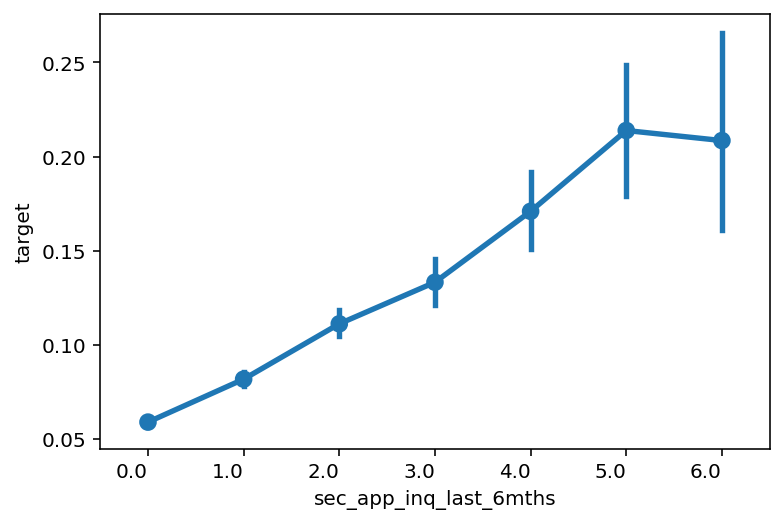

In [97]:
# Check the loan status between different sec_app_inq_last_6mths
plt.figure(figsize=(6,4))
chart = sns.pointplot(x = "sec_app_inq_last_6mths", y = 'target', data = xtrain)
chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right')
xtrain.sec_app_inq_last_6mths.value_counts()

In [98]:
# Create dummies for loan's sec_app_inq_last_6mths
xtrain["no_sec_app"] = np.where(xtrain.sec_app_inq_last_6mths.isnull(),1,0)
sec_app_inq= pd.get_dummies(xtrain.sec_app_inq_last_6mths, prefix="sec_app_inq_")
xtrain = pd.concat([xtrain, sec_app_inq], axis=1)


#### Delinquent related features

In [99]:
deli_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog",
            "mths_since_recent_inq"]


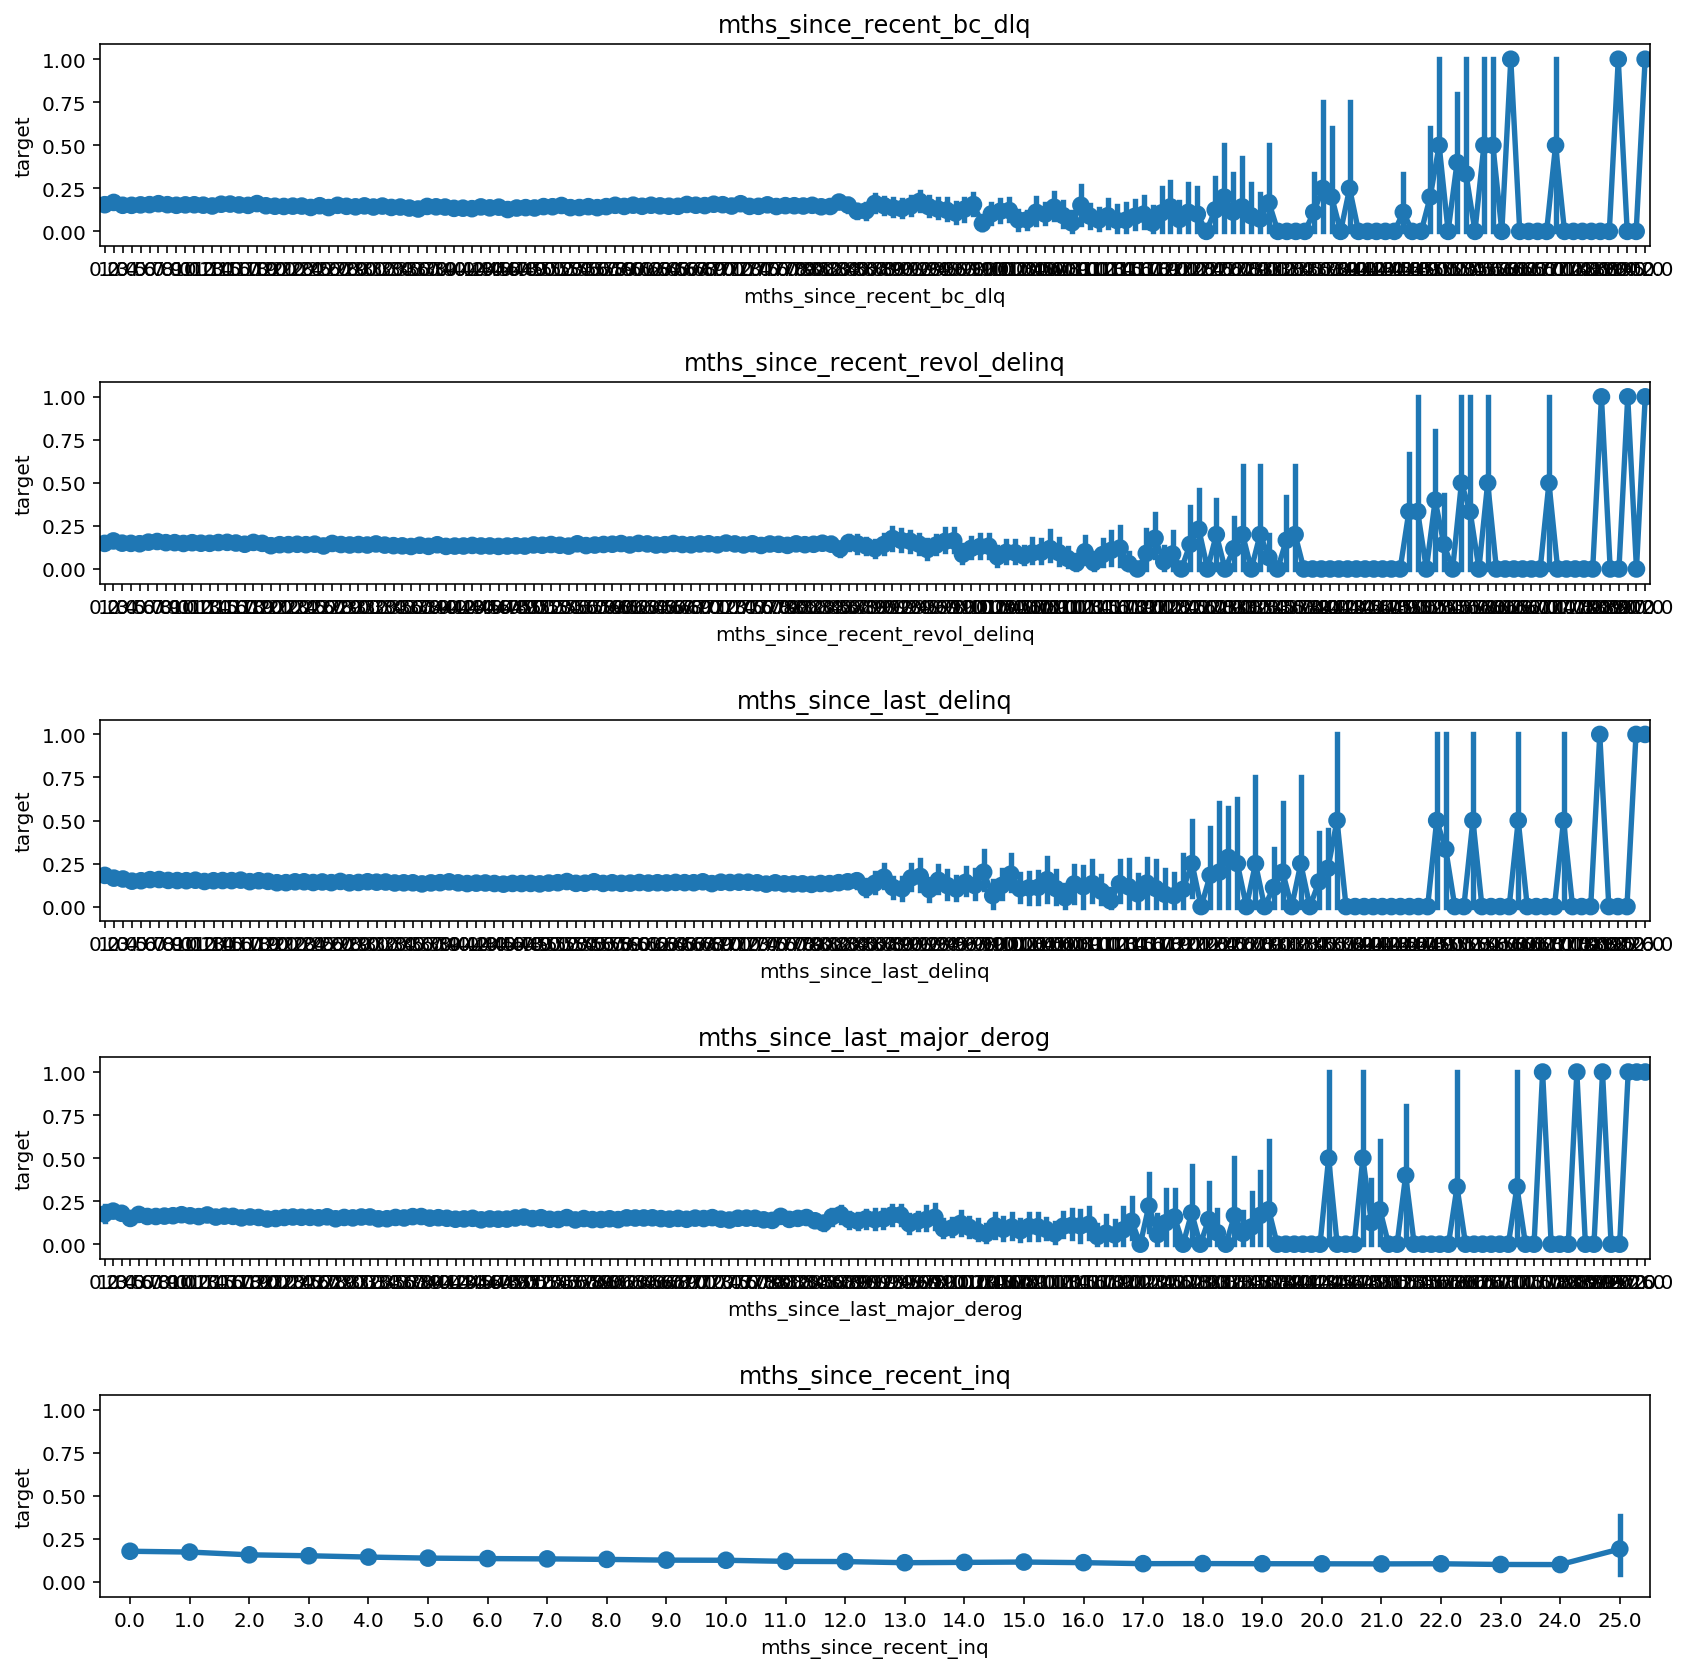

In [100]:
# Check distribution 
f, axes = plt.subplots(5, 1, figsize=(12, 12),  sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(5):
    chart = sns.pointplot(x = deli_cols[i], y = 'target', data = xtrain, ax = axes[i])
    axes[i].set_title(deli_cols[i])
    
f.tight_layout(pad=2.0)
plt.show()
    


Based on the plots above, we can see that the longer time since last delinquent, the less likely a loan is in trouble status. <br>
A consistent pattern is presented in all deliquent related features: as the number of months since last deliquency gets larger, the likelihood of a loan turning to default decrease. This is reasonable in business sense as we can assume that borrowers who have been consistently paying their loan repayment for a period of time are more likely to continue paying, which indicating good loans. 

In [101]:
def check_diff(col):
    print(col)
    print(round( xtrain.loc[xtrain[col].isnull(),"target"].mean(),4))
    print(round( xtrain.loc[xtrain[col].notnull(),"target"].mean(),4))

In [102]:
del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog"]

for i in del_cols:
    check_diff(i)

mths_since_recent_bc_dlq
0.1308
0.1459
mths_since_recent_revol_delinq
0.1303
0.1425
mths_since_last_delinq
0.1269
0.1421
mths_since_last_major_derog
0.1284
0.1515


In [103]:
# Use Weighted Average method for delinquent related missing values

def fill_delinq(col):
    # Summary ratio of bad loans by variable of interest
    df = xtrain.loc[:,[col,"target"]].groupby([col]).agg(['mean', 'count'])
    
    # The ratio of bad loans in the missing value group
    target_mean = xtrain.loc[xtrain[col].isnull(),"target"].mean()
    target_std  = xtrain.loc[xtrain[col].isnull(),"target"].std()
    
    # Use the ratio of bad loans of the missing value group to find the existing data range that has similar bad loan ratio within +/-a range
    df= df.loc[(df['target']['mean'].values >= (target_mean - 0.05*target_std)) & (df['target']['mean'].values <= (target_mean + 0.01* target_std)),:]
    
    df["weighted_avg"] = df['target']['count']/sum(df['target']['count'])

    # Calculate the weighted average mths_since_last_delinq of loans
    w_avg =0
    for i in range(len(df)):
        w_avg += df.index[i] * df.weighted_avg.tolist()[i]
       
    
    return w_avg
    

In [104]:
# Fill NaN for delinquence related features.
# Based on the point plot of delinquent-related features vs target, the ratio of bad loans decreases as the number of months since last/recent delinquent increases.

del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
             "mths_since_last_delinq", "mths_since_last_major_derog"]

for i in del_cols:
    w_avg =fill_delinq(i)
    xtrain.loc[xtrain[i].isnull(), i ] = w_avg

In [105]:
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]/len(xtrain)

mths_since_last_record                 0.841087
annual_inc_joint                       0.946642
dti_joint                              0.946644
verification_status_joint              0.948832
revol_bal_joint                        0.952267
sec_app_fico_range_low                 0.952267
sec_app_fico_range_high                0.952267
sec_app_earliest_cr_line               0.952267
sec_app_inq_last_6mths                 0.952267
sec_app_mort_acc                       0.952267
sec_app_open_acc                       0.952267
sec_app_revol_util                     0.953076
sec_app_open_act_il                    0.952267
sec_app_num_rev_accts                  0.952267
sec_app_chargeoff_within_12_mths       0.952267
sec_app_collections_12_mths_ex_med     0.952267
sec_app_mths_since_last_major_derog    0.984197
dtype: float64

In [106]:
# Now we are ready to drop the features with over 80% missing values
xtrain.drop(["mths_since_last_record" ,
            "annual_inc_joint" ,                      
            "dti_joint",                              
            "verification_status_joint"  ,            
            "revol_bal_joint"   ,                     
            "sec_app_fico_range_low",                
            "sec_app_fico_range_high",             
            "sec_app_earliest_cr_line",        
            "sec_app_inq_last_6mths"  ,               
            "sec_app_mort_acc" ,                     
            "sec_app_open_acc"  ,                     
            "sec_app_revol_util"  ,                
            "sec_app_open_act_il" ,                  
            "sec_app_num_rev_accts" ,               
            "sec_app_chargeoff_within_12_mths" ,      
            "sec_app_collections_12_mths_ex_med" ,    
            "sec_app_mths_since_last_major_derog" ],
          axis=1, inplace=True)

In [107]:
# Double Check if any columns with more than 50% missing values
xtrain.isnull().sum()[xtrain.isnull().sum()/len(xtrain)>=0.5]

Series([], dtype: int64)

#### Continue handling missing values


In [108]:
# # Check all numeric columns
# numcols = data.select_dtypes(include=np.number).columns.tolist()

In [109]:
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

emp_title                     133526
emp_length                    117451
annual_inc                         3
verification_status             3961
title                          18691
                               ...  
tax_liens                         83
tot_hi_cred_lim                56468
total_bal_ex_mort              40220
total_bc_limit                 40220
total_il_high_credit_limit     56468
Length: 68, dtype: int64

Employment title

In [110]:
#Assign missing values in emp_title as undisclosed 
xtrain.loc[xtrain.emp_title.isnull(), "emp_title"] ="Undisclosed"

In [111]:
# The group similar employment title together, and create dummy variables for the top 5 employee title categories, and the rest would be Other
mgt_title =['Manager','manager','Supervisor','supervisor','President','president',
            'Director','Leader','director','leader','Administrator','administrator','VP']
nurse_title = ['Registered Nurse','nurse','Nurse','RN']
teacher_title = ['teacher','Teacher']
owner_title = ['Owner','owner']
driver_title = ['Driver','driver']
titles = dict({"mgt_title":mgt_title,"nurse_title":nurse_title,"teacher_title": teacher_title,
               "owner_title": owner_title,"driver_title":driver_title})


In [112]:
# Create a dictionary for these employment title variables
title_dict = {}
for key,value in titles.items():
    title_dict[key]=[int(sum([1 if j in value else 0 for j in i.split()]) > 0) for i in xtrain['emp_title'].values ]
    


In [113]:
# Concat the employee title dummy variables 
title_df = pd.DataFrame(title_dict)
title_df.reset_index(drop=True, inplace=True)
xtrain.reset_index(drop=True, inplace=True)
xtrain = pd.concat([xtrain, title_df], axis=1)

In [114]:
# Add dummy variable of employment title to the dataset
xtrain['emp_undisc'] = np.where(xtrain.emp_title=='Undisclosed',1,0)

In [115]:
# Add dummy variable of Other employment title to the dataset
xtrain['title_other'] = np.where((xtrain.emp_undisc + xtrain.mgt_title + xtrain.nurse_title + xtrain.teacher_title + xtrain.owner_title+ xtrain.driver_title) == 0,1,0)

In [116]:
xtrain.drop("emp_title", axis=1, inplace=True)

Employment length

In [117]:
# As the majority of missing values in emp_length are associated with undisclosed emp_title. I will fill NA values in emp_length with random samples from the undisclosed group
emp_len_isnull = xtrain.emp_length.isnull()
emp_len_samples = xtrain.loc[(xtrain.emp_undisc==1) & (xtrain.emp_length.notnull()), 'emp_length'].sample(emp_len_isnull.sum(),replace= True).values
xtrain.loc[emp_len_isnull,"emp_length"] = emp_len_samples

In [118]:
# Extract the number of years from emp_length column, convert it to string and fill NaN with the mean.
xtrain['emp_length'] = xtrain['emp_length'].str.extract('(\d+)')
xtrain['emp_length'] = pd.to_numeric(xtrain["emp_length"])
# Assumptions: borrowers who has 10 years or more than 10 years of employment are similar in their debt repaymnet 

Loan grade and subgrade

In [119]:
# Assgin a score to each loan grade by calculating the ratio of bad loans in each grade
dfgrade = xtrain.loc[:,["grade","target"]].groupby(["grade"]).mean()
dfgrade = round(dfgrade*100,0).to_dict()['target']
dfgrade

{'A': 4.0, 'B': 9.0, 'C': 15.0, 'D': 21.0, 'E': 29.0, 'F': 37.0, 'G': 41.0}

In [120]:
# Assgin a score to each loan subgrade by calculating the ratio of bad loans in each grade
dfsubgrade = xtrain.loc[:,["sub_grade","target"]].groupby(["sub_grade"]).mean()
dfsubgrade = round(dfsubgrade*100,0).to_dict()['target']


In [121]:
# Convert loan grade and loan subgrades to numerica value
xtrain['grade'] = xtrain['grade'].map(dfgrade)
xtrain['sub_grade'] = xtrain['sub_grade'].map(dfsubgrade)

Loan purpose

[Text(0, 0, 'credit_card'),
 Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'other'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'car'),
 Text(0, 0, 'house'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'wedding'),
 Text(0, 0, 'renewable_energy'),
 Text(0, 0, 'educational')]

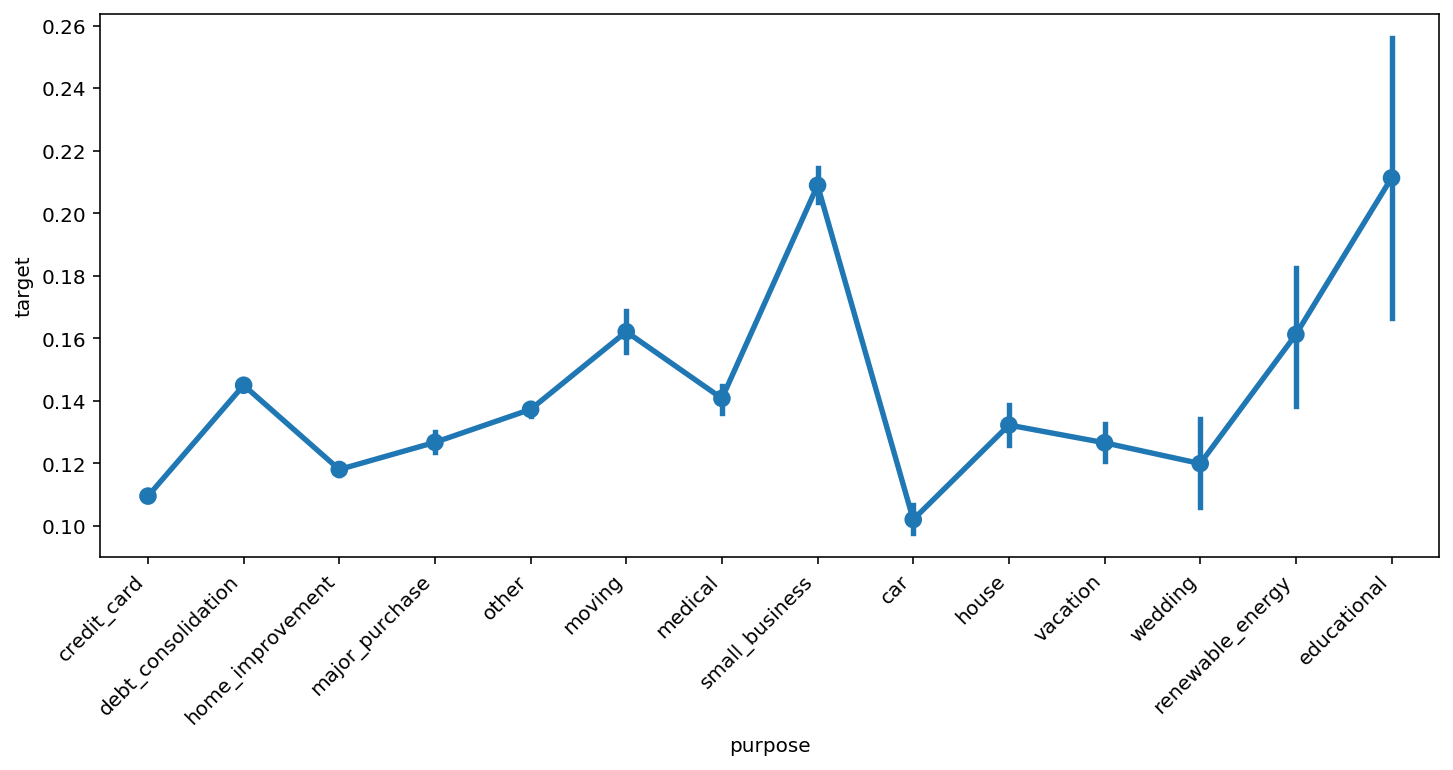

In [122]:
# Check the loan status between different loan purposes
plt.figure(figsize=(12, 5))
chart = sns.pointplot(x = "purpose", y = 'target', data = xtrain)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [123]:
# Inspect column title (the loan title provided by the borrower)
# Noted that column title provides the similar information as column purpose
xtrain[["purpose",'title']].head(10)

,purpose,title
0,credit_card,Credit card refinancing
1,debt_consolidation,100% PAYMENT RECORD
2,credit_card,Credit card refinancing
3,debt_consolidation,Debt consolidation
4,credit_card,Credit card refinancing
5,debt_consolidation,Debt consolidation
6,debt_consolidation,Debt consolidation
7,debt_consolidation,Debt consolidation
8,debt_consolidation,Debt consolidation
9,home_improvement,Home improvement


In [124]:
# Drop xolumn title as it provides similar information of loan purpose. 
xtrain.drop("title",axis=1, inplace=True)

In [125]:
# check missing values for the following columns before converting them to dummy variables
xtrain[["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
        ]].isnull().sum()

application_type          0
initial_list_status       0
term                      0
purpose                   0
home_ownership            0
verification_status    3961
disbursement_method       0
dtype: int64

In [126]:
xtrain.verification_status.value_counts()

Source Verified    709953
Not Verified       605612
Verified           489008
Name: verification_status, dtype: int64

In [127]:
xtrain.loc[xtrain.verification_status.isnull(),"verification_status"]='verified_unknown'

In [128]:
xtrain.verification_status.value_counts()

Source Verified     709953
Not Verified        605612
Verified            489008
verified_unknown      3961
Name: verification_status, dtype: int64

In [129]:
todummy = ["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status",'disbursement_method'
          ]
    
# Convert application_type to dummy variables
for i in todummy:
    dummy = pd.get_dummies(xtrain[i], prefix = i)
    xtrain = pd.concat([xtrain, dummy], axis=1)
    xtrain.drop(i, axis=1, inplace=True)


In [130]:
# combine home ownership other, none and any into one group:Other
xtrain.home_ownership_OTHER = xtrain.home_ownership_OTHER + xtrain.home_ownership_ANY + xtrain.home_ownership_NONE
 
xtrain.drop(["home_ownership_ANY","home_ownership_NONE"], axis=1, inplace=True)

Borrower's Address, state and zip code

In [131]:
address = ["addr_state","zip_code"]

In [132]:
# Calculate the percentage of bad loans of each state
for i in address:
    df= xtrain.loc[:,[i,"target"]].groupby([i]).mean()
    df  = round(df*100,2).to_dict()['target']
    xtrain[i] = xtrain[i].map(df)

In [133]:
# Noted there is one missing value in zip_code, fillna with mode
xtrain.loc[xtrain.zip_code.isnull(), "zip_code"] = xtrain['zip_code'].mode()[0]

In [134]:
col_list2 = ['dti', # borrower’s total monthly debt payments on the total debt obligations
    'revol_util', # Borrowers' revol_utilization rate
     'annual_inc', # annual income
    'tot_coll_amt', # Total collection amounts ever owed
    'revol_bal', # Total credit revolving balance
    'delinq_2yrs'#Number of 30+days past-due incidences of delinquency for the past 2 years
            ]

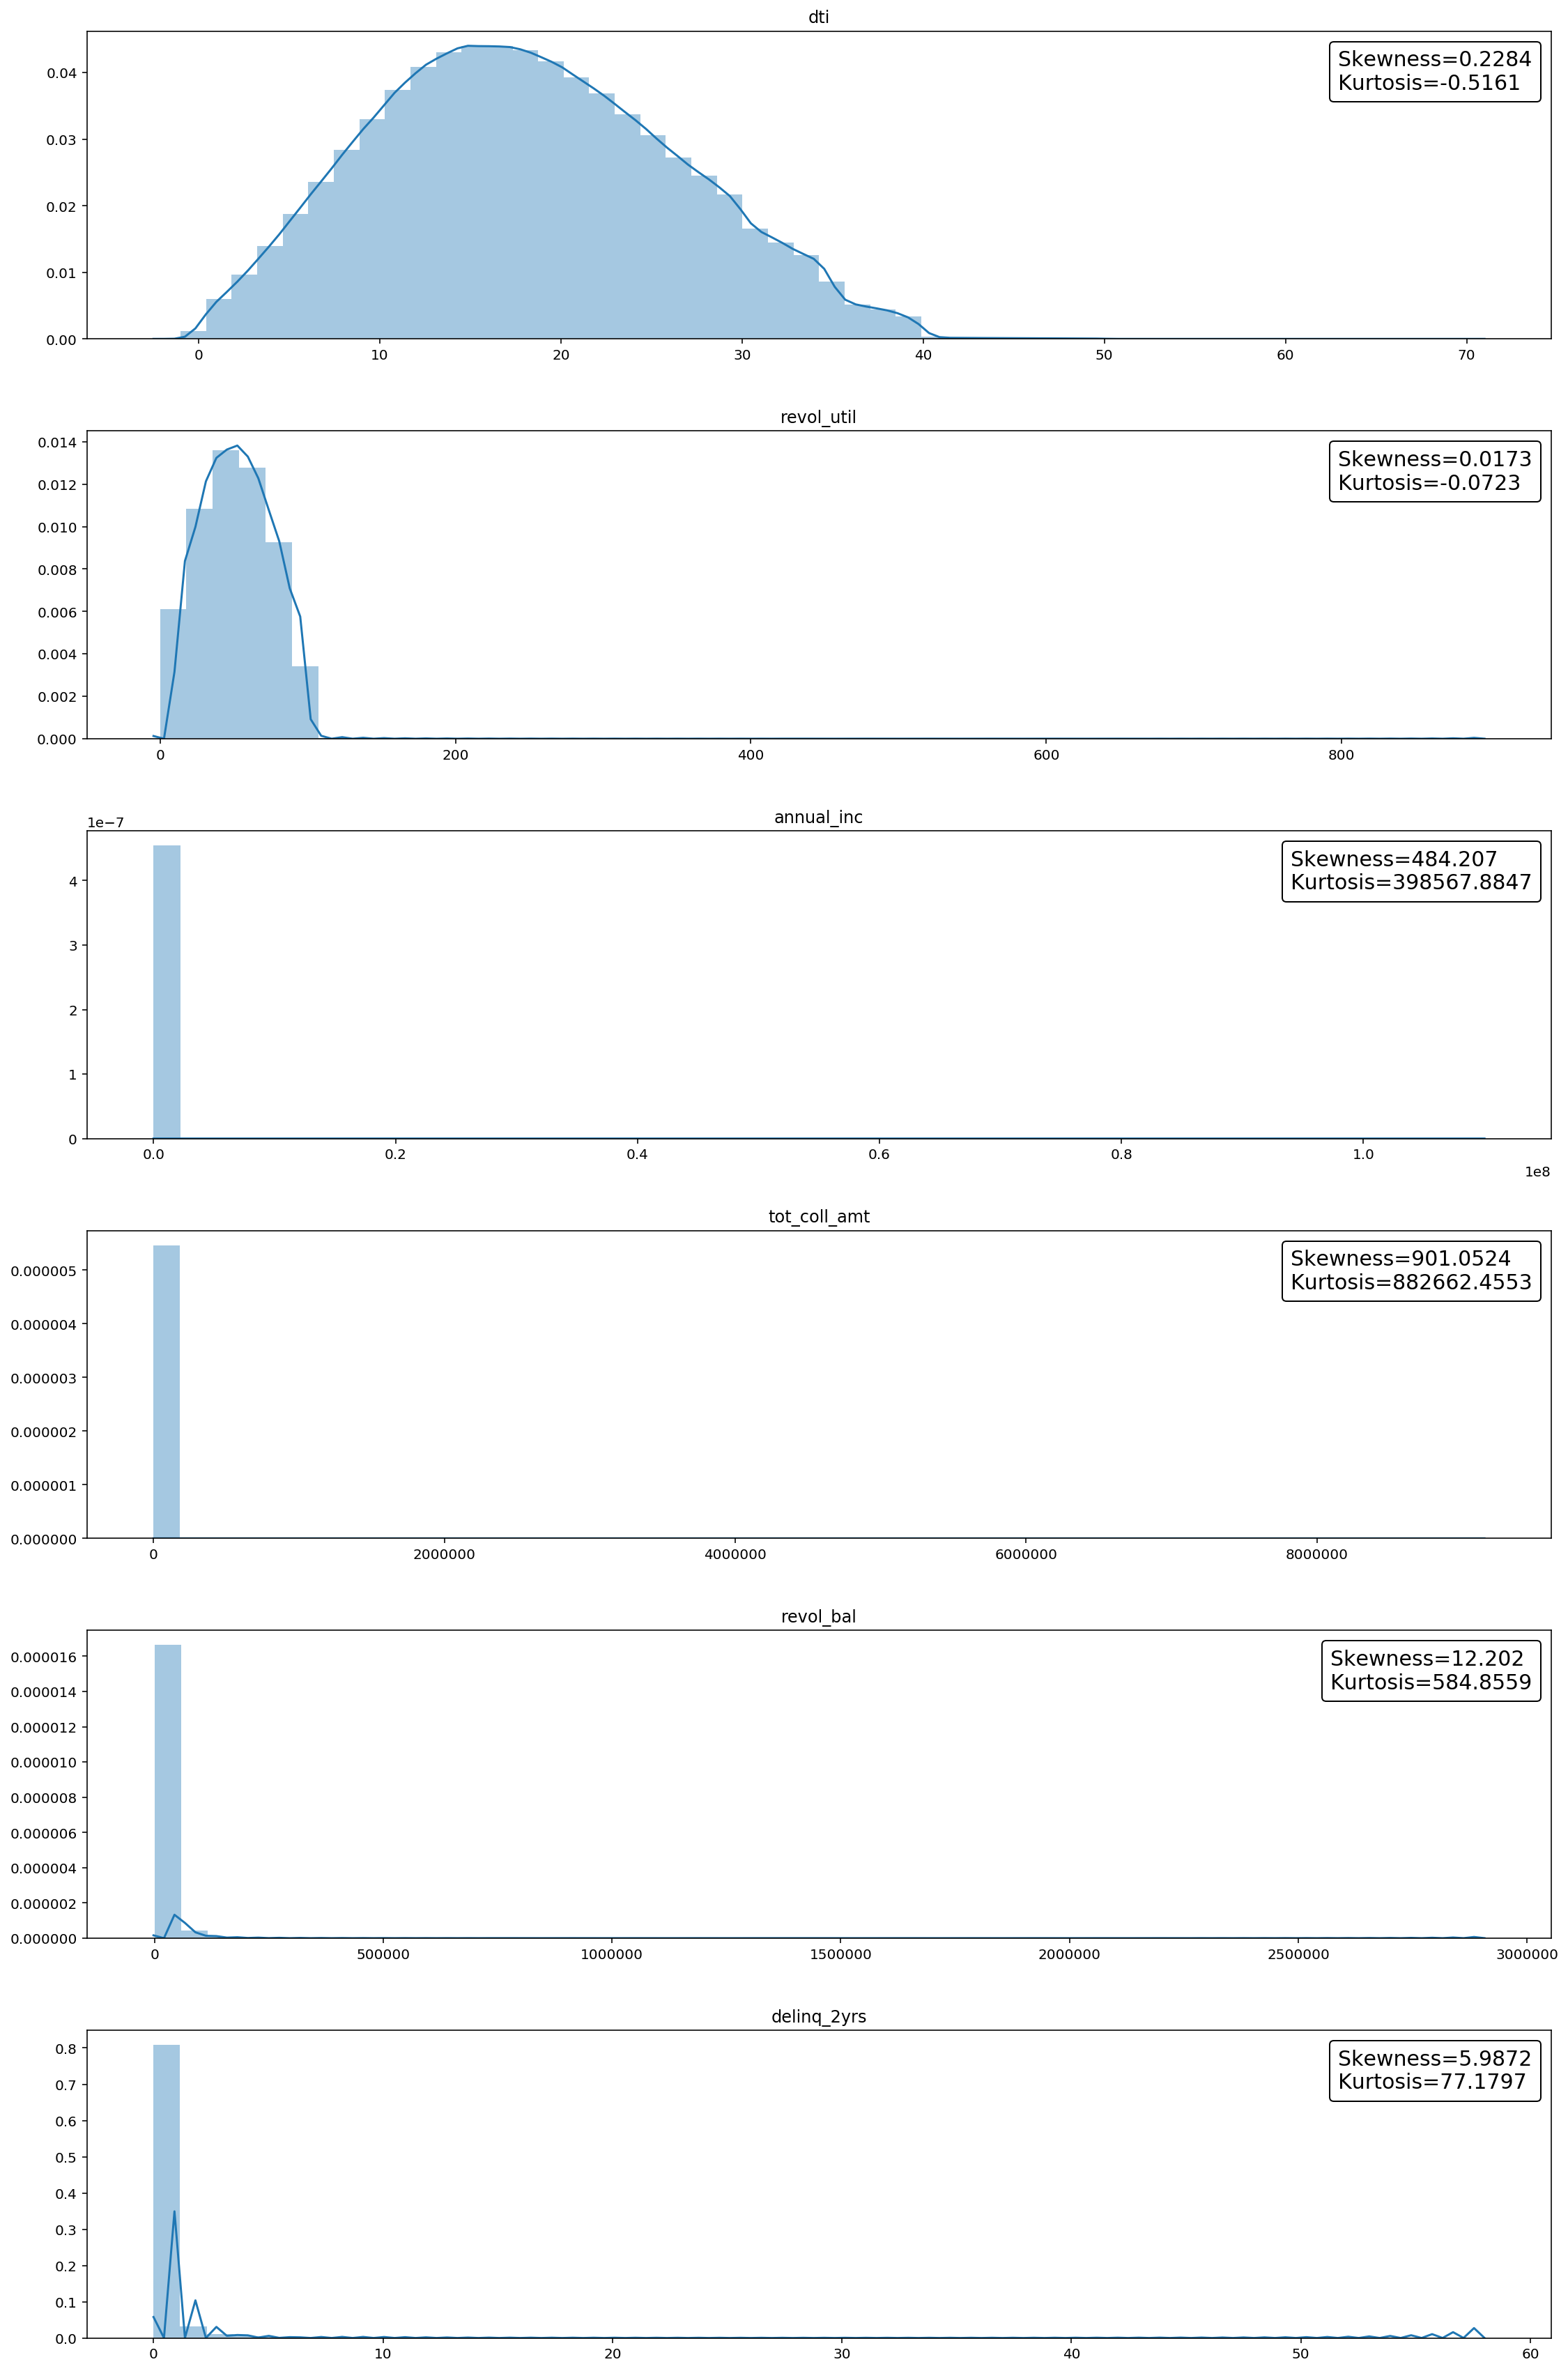

In [135]:
# Check distribution of Borrowers dti ratio (borrower’s total monthly debt payments on the total debt obligations)
f, axes = plt.subplots(len(col_list2), 1, figsize=(16, 24)) 

for i in range(len(col_list2)):
    skewness = round(xtrain[col_list2[i]].skew(),4)
    sns.distplot(xtrain[[col_list2[i]]].dropna(), hist=True, kde=True, ax = axes[i]
                ) 
    axes[i].set_title(col_list2[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[col_list2[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[col_list2[i]].kurt(),4)),
                  prop=dict(size=15), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)
    
    
f.tight_layout(pad=2.0) 
plt.show()

To fill missing values in the numerical variables with mean or median based on each variable's distribution:
- Use median (skewed distribution):
    'annual_inc','tot_coll_amt','revol_bal',
- Use mean (close to normal distribution):
    "dti","revol_util"

In [136]:
cols_median = ['annual_inc','tot_coll_amt','revol_bal',]

In [137]:
# Fill missing values with median for the following columns
for i in cols_median :
    xtrain.loc[xtrain[i].isnull(), i] = xtrain[i].median()

In [138]:
# Fill missing values for the following variables with mean value 
for i in ["dti","revol_util"]:
    xtrain.loc[xtrain[i].isnull(), i ] = xtrain[i].mean()

In [139]:
# Simply fill missing values for following columns with mode since the number of missing values is a small amount

for i in ["earliest_cr_line", "inq_last_6mths",'open_acc','total_acc',"pub_rec",
          "collections_12_mths_ex_med","acc_now_delinq", 'delinq_2yrs',
         ]:
    xtrain.loc[xtrain[i].isnull(), i] =xtrain[i].mode()[0]

In [140]:
# Extract the year in which the borrower has credit line
xtrain['earliest_cr_line'] = xtrain['earliest_cr_line'].str.extract('(\d+)').astype(int)

In [141]:
xtrain.isnull().sum()[xtrain.isnull().sum()!= 0]

tot_cur_bal                    56468
open_acc_6m                   692960
open_act_il                   692959
open_il_12m                   692959
open_il_24m                   692959
mths_since_rcnt_il            727965
total_bal_il                  692959
il_util                       855086
open_rv_12m                   692959
open_rv_24m                   692959
max_bal_bc                    692959
all_util                      693117
total_rev_hi_lim               56468
inq_fi                        692959
total_cu_tl                   692960
inq_last_12m                  692960
acc_open_past_24mths           40220
avg_cur_bal                    56521
bc_open_to_buy                 60202
bc_util                        61088
chargeoff_within_12_mths         118
delinq_amnt                       24
mo_sin_old_il_acct            111507
mo_sin_old_rev_tl_op           56469
mo_sin_rcnt_rev_tl_op          56469
mo_sin_rcnt_tl                 56468
mort_acc                       40220
m

### Handling missing value for attributes by categories|


                
#### Financial Trades related (finance trades, open trades, revolving trade): <br>
open_acc_6m  <br>
open_act_il  <br>
open_rv_12m  <br>
open_rv_24m  <br>
total_cu_tl  <br>
acc_open_past_24mths  <br>
num_actv_rev_tl  <br>
num_rev_tl_bal_gt_0  <br>

#### Bankcard related:
num_bc_tl  <br>
bc_open_to_buy  <br>
num_actv_bc_tl <br>
num_bc_sats <br>

percent_bc_gt_75 <br>
bc_util <br>
total_bc_limit <br>

mths_since_recent_bc <br>

#### Installment related:

num_il_tl <br>
open_il_12m <br>
open_il_24m <br>

total_bal_il <br>
il_util <br>
total_il_high_credit_limit <br>

mths_since_rcnt_il <br>
mo_sin_old_il_acct <br>

#### Revolving account
num_rev_accts <br>
num_op_rev_tl <br>
max_bal_bc   <br>
total_rev_hi_lim <br>


mo_sin_old_rev_tl_op  <br>          
mo_sin_rcnt_rev_tl_op <br>

#### General Account Info : 

num_tl_op_past_12m <br>
num_sats <br>
mort_acc <br>

tot_cur_bal <br>
avg_cur_bal <br>
tot_hi_cred_lim <br>
total_bal_ex_mort <br>

mo_sin_rcnt_tl <br>

#### Delinquency/past due/charge-off:

inq_fi <br>
inq_last_12m <br>
mths_since_recent_inq<br>
chargeoff_within_12_mths <br>
delinq_amnt <br>
num_tl_120dpd_2m     <br>          
num_tl_30dpd    <br>              
num_tl_90g_dpd_24m <br>
pub_rec_bankruptcies <br>
tax_lien<br>
num_accts_ever_120_pd <br>

#### Financial trades related

In [156]:
fin_trade_ind =[ "open_acc_6m"  ,
                    "open_act_il"  ,
                    "open_rv_12m" ,
                    "open_rv_24m"  ,
                    "total_cu_tl"  ,
                    "acc_open_past_24mths" , 
                    "num_actv_rev_tl"  ,
                    "num_rev_tl_bal_gt_0" ] 

'acc_open_past_24mths' measures the number of trades opened in past 24 months.
For rows that are missing value in'acc_open_past_24mths', all the financial trade related columns are NaN

In [162]:
xtrain.loc[xtrain.acc_open_past_24mths.isnull(),fin_trade_ind].sum()

open_acc_6m             0.0
open_act_il             0.0
open_rv_12m             0.0
open_rv_24m             0.0
total_cu_tl             0.0
acc_open_past_24mths    0.0
num_actv_rev_tl         0.0
num_rev_tl_bal_gt_0     0.0
dtype: float64

In [165]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtrain.loc[xtrain['acc_open_past_24mths'].isnull(),fin_trade_ind ] =0

In [173]:
fin_trade_ind.remove('acc_open_past_24mths')

In [174]:
xtrain.loc[xtrain.num_actv_rev_tl.isnull(),fin_trade_ind].sum()

open_acc_6m            0.0
open_act_il            0.0
open_rv_12m            0.0
open_rv_24m            0.0
total_cu_tl            0.0
num_actv_rev_tl        0.0
num_rev_tl_bal_gt_0    0.0
dtype: float64

In [175]:
#Fill missing values with 0 since these borrowers probably has not invovled in financial trades.
xtrain.loc[xtrain['num_actv_rev_tl'].isnull(),fin_trade_ind ] =0

In [176]:
xtrain[fin_trade_ind].isnull().sum()

open_acc_6m            636492
open_act_il            636491
open_rv_12m            636491
open_rv_24m            636491
total_cu_tl            636492
num_actv_rev_tl             0
num_rev_tl_bal_gt_0         0
dtype: int64

In [180]:
for i in xtrain[fin_trade_ind].isnull().sum()[xtrain[fin_trade_ind].isnull().sum() == 0].index.tolist():
    fin_trade_ind.remove(i)

In [181]:
# Random sampling with replacement:
for i in fin_trade_ind:
    isnull = xtrain[i].isnull()
    random_sample = xtrain[i].dropna().sample(isnull.sum(), replace= True).values
    xtrain.loc[isnull,i] = random_sample

In [152]:
# xtrain.isnull().sum()[(xtrain.isnull().sum()== 692959) |(xtrain.isnull().sum()==  692960)]

# print("percentage of missing values: %.4f "%(xtrain.total_cu_tl.isnull().sum()/len(xtrain)))

# # obtain variable names for the missing values above
# fin_trade_ind = xtrain.isnull().sum()[(xtrain.isnull().sum()== 692959)|(xtrain.isnull().sum()== 692960)].index.values

# # Confirm that the missing for the following columns happen to the same instances
# xtrain.loc[xtrain.total_cu_tl.isnull(),fin_trade_ind].isnull().sum()

# fin_trade_ind

In [318]:
# Create a new column indicating this group of borrowers, who are likely not involved in trades
xtrain['is_null_total_cu_tl'] = xtrain.total_cu_tl.isnull().astype(int)

In [320]:
# Since these borrowers' are not involved in the open trades, I assign 0 to following variables.
for i in fin_trade_ind:
    xtrain.loc[xtrain[i].isnull(), i] = 0

#### Missing values at multiple features for the same instances
Noted that the following variables has the same amount of missing values(56468 +- 1) and confirmed that the missing values in these variables happen for the same instances. Looking at these variables as a group, my assumption is missing values in these variables indicate that the borrowers has no borrowings before (first-time borrowers)

In [300]:
 xtrain.isnull().sum()[(xtrain.isnull().sum()== 56468)|(xtrain.isnull().sum()== 56469)]

tot_cur_bal                   56468
total_rev_hi_lim              56468
mo_sin_old_rev_tl_op          56469
mo_sin_rcnt_rev_tl_op         56469
mo_sin_rcnt_tl                56468
num_accts_ever_120_pd         56468
num_actv_bc_tl                56468
num_actv_rev_tl               56468
num_bc_tl                     56468
num_il_tl                     56468
num_op_rev_tl                 56468
num_rev_accts                 56469
num_rev_tl_bal_gt_0           56468
num_tl_30dpd                  56468
num_tl_90g_dpd_24m            56468
num_tl_op_past_12m            56468
tot_hi_cred_lim               56468
total_il_high_credit_limit    56468
dtype: int64

In [301]:
print("percentage of missing values: %.4f "%(xtrain.tot_cur_bal.isnull().sum()/len(xtrain)))

percentage of missing values: 0.0312 


In [307]:
# compare the proportion of bad loans between the missing-value group and with-value group 
print(xtrain.loc[xtrain.tot_cur_bal.isnull(), "target"].mean())
print(xtrain.loc[xtrain.tot_cur_bal.notnull(), "target"].mean())

0.1582843380321598
0.13352921636513693


In [302]:
# obtain variable names for the missing values above
new_app_ind = xtrain.isnull().sum()[(xtrain.isnull().sum()== 56468)|(xtrain.isnull().sum()== 56469)].index.values

In [303]:
# Confirm that the missing for the following columns happen to the same instances
xtrain.loc[xtrain.tot_cur_bal.isnull(),new_app_ind].isnull().sum()

tot_cur_bal                   56468
total_rev_hi_lim              56468
mo_sin_old_rev_tl_op          56468
mo_sin_rcnt_rev_tl_op         56468
mo_sin_rcnt_tl                56468
num_accts_ever_120_pd         56468
num_actv_bc_tl                56468
num_actv_rev_tl               56468
num_bc_tl                     56468
num_il_tl                     56468
num_op_rev_tl                 56468
num_rev_accts                 56468
num_rev_tl_bal_gt_0           56468
num_tl_30dpd                  56468
num_tl_90g_dpd_24m            56468
num_tl_op_past_12m            56468
tot_hi_cred_lim               56468
total_il_high_credit_limit    56468
dtype: int64

Assumption I made her is that for instances that have NaN values in the following variables are very likely new applicants has no any prior activities in the following variables. 

In [309]:
# Create a new column indicating this group of borrowers, who are likely to be new applicants.
xtrain['is_null_tot_cur_bal'] = xtrain.tot_cur_bal.isnull().astype(int)

In [310]:
# Assign 0 value fill missing values
newapp_cols = ['tot_cur_bal' ,                 
                'total_rev_hi_lim' ,              
                'num_accts_ever_120_pd',         
                'num_actv_bc_tl' ,               
                'num_actv_rev_tl',               
                'num_bc_tl' ,                   
                'num_il_tl' ,                    
                'num_op_rev_tl',                 
                'num_rev_accts'  ,               
                'num_rev_tl_bal_gt_0' ,         
                'num_tl_30dpd'   ,               
                'num_tl_90g_dpd_24m' ,           
                'num_tl_op_past_12m'  ,          
                'tot_hi_cred_lim',               
                'total_il_high_credit_limit' ] 
for i in newapp_cols:
    xtrain.loc[xtrain[i].isnull(), i] = 0

The following variables are related to how long since most recent or oldest accounts open.
Based on pattern above, these instances are very likely new borrowers, I decided to assigned the oldest date to them, indicating that they haven't been open new accounts for a while.

In [311]:
newapp_cols2= ["mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl"]
for i in newapp_cols2:
    xtrain.loc[xtrain[i].isnull(), i] = xtrain[i].max()
           

In [323]:
# check missing values again
xtrain.isnull().sum()[xtrain.isnull().sum()!= 0]

mths_since_rcnt_il          727965
il_util                     855086
all_util                    693117
avg_cur_bal                  56521
bc_open_to_buy               60202
bc_util                      61088
chargeoff_within_12_mths       118
delinq_amnt                     24
mo_sin_old_il_acct          111507
mort_acc                     40220
mths_since_recent_bc         58944
mths_since_recent_inq       236524
num_bc_sats                  47042
num_sats                     47042
num_tl_120dpd_2m            123131
pct_tl_nvr_dlq               56592
percent_bc_gt_75             60545
pub_rec_bankruptcies          1070
tax_liens                       83
total_bal_ex_mort            40220
total_bc_limit               40220
dtype: int64

Continue filling missing values

In [324]:
# If number of installment account is 0, assign the oldest date to both 'mths_since_rcnt_il' and 'mo_sin_old_il_acct'
il_list = ['mths_since_rcnt_il','mo_sin_old_il_acct']
for i in il_list:
    xtrain.loc[xtrain.num_il_tl == 0 ,i]=xtrain[i].max()

In [325]:
# Random sample with replacement to fill the remaining missing values
for i in il_list:
    isnull = xtrain[i].isnull()
    random_sample = xtrain[i].dropna().sample(isnull.sum(), replace= True).values
    xtrain.loc[isnull,i] = random_sample
    
    
# Column_Name_avg = dataframe['Column_Name'].mean()
# Column_Name_std = dataframe['Column_Name'].std()
# Column_Name_null_count = dataframe['Column_Name'].isnull().sum()
# Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
# dataframe['Column_Name'][np.isnan(dataframe['Column_Name'])] = Column_Name_null_random_list
# dataframe['Column_Name'] = dataframe['Column_Name'].astype(int)

In [329]:
# Utilization related features
utli_list = ['il_util' ,                    
            'all_util',                    
            'bc_util' ]                 

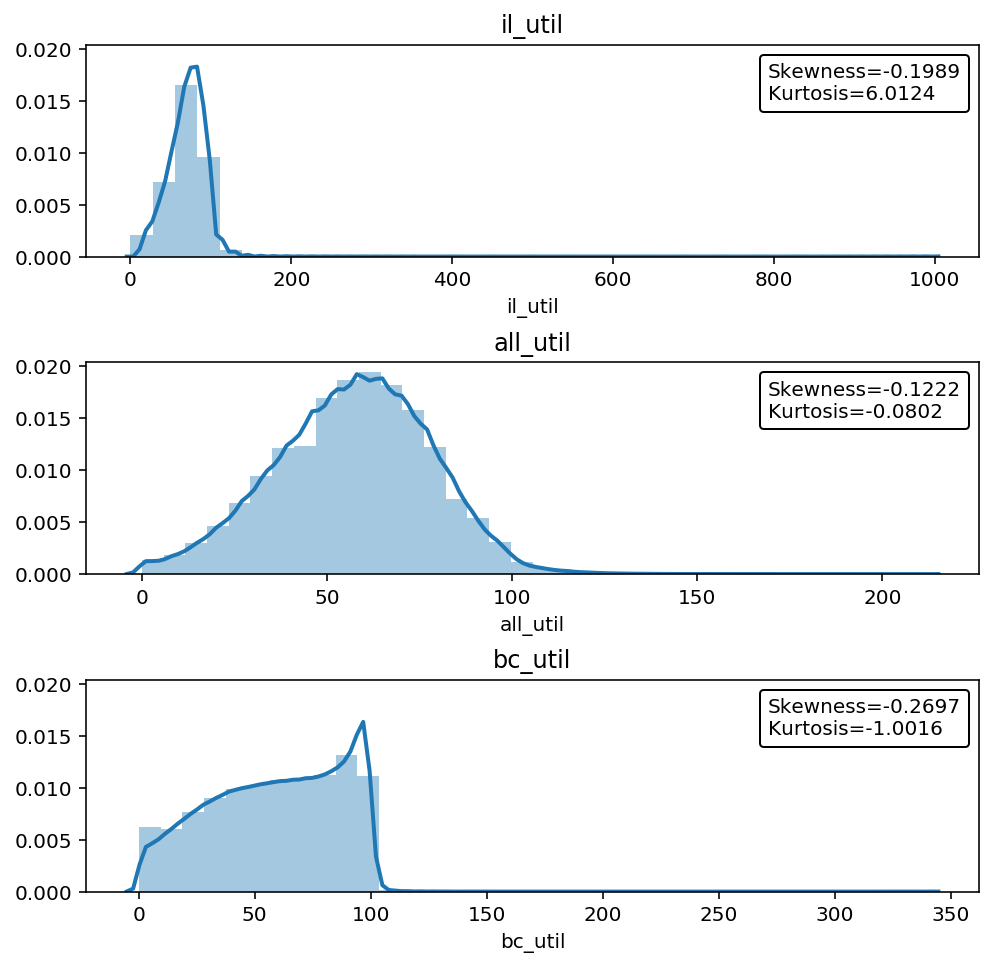

In [332]:
# Check distribution 
f, axes = plt.subplots(3, 1, figsize=(8, 6),  sharey=True)
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(3):
    
    # Histogram 1 - debt-to-income ratio
    sns.distplot(xtrain[utli_list[i]], hist=True, kde=True, 
                 bins=int(180/5), 
                 kde_kws={'linewidth': 2},ax = axes[i])
    axes[i].set_title(utli_list[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[utli_list[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[utli_list[i]].kurt(),4)),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)

plt.show()


In [333]:
# Balances-related features
bal_list = ['total_rev_hi_lim','avg_cur_bal',"tot_hi_cred_lim"]

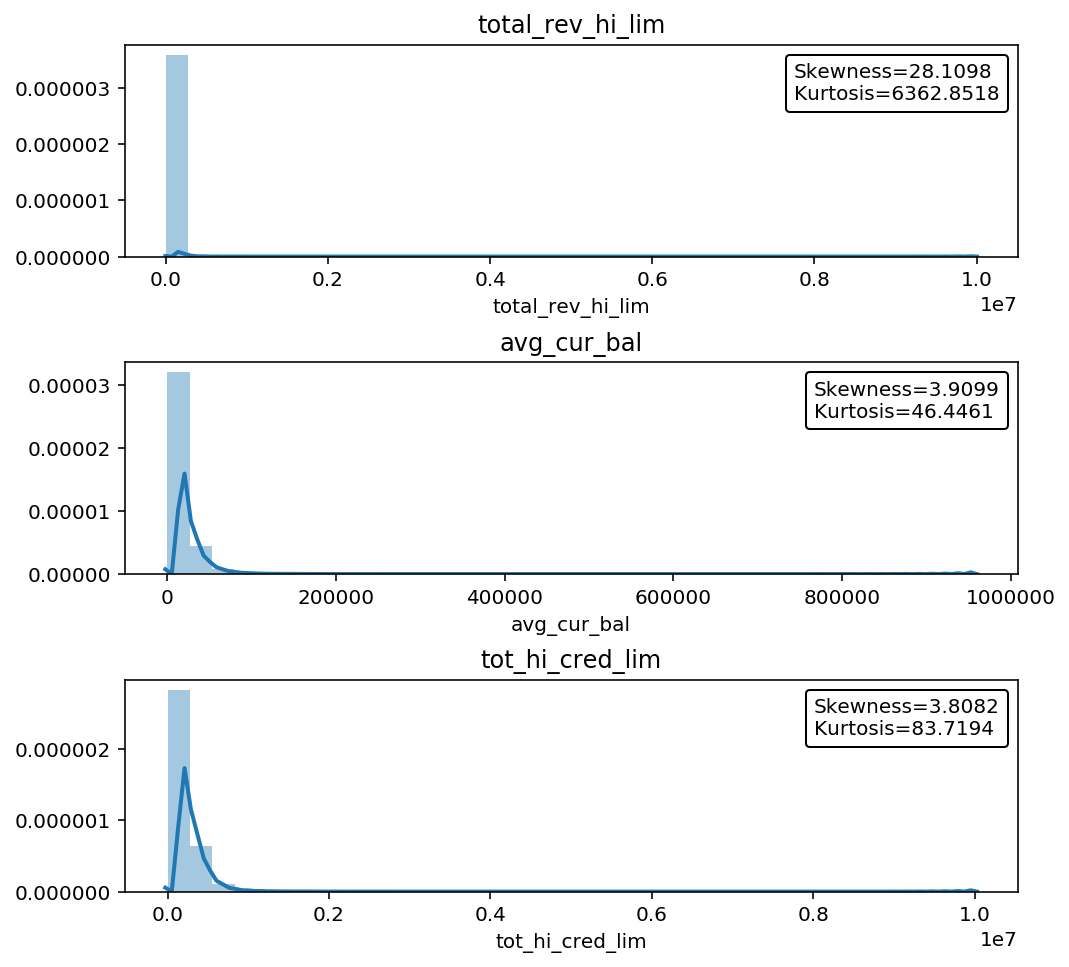

In [334]:
# Check distribution 
f, axes = plt.subplots(3, 1,  figsize=(8, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
for i in range(3):
    
    sns.distplot(xtrain[bal_list[i]].dropna(), hist=True, kde=True, 
                 bins=int(180/5), 
                 kde_kws={'linewidth': 2},ax = axes[i])
    axes[i].set_title(bal_list[i])
    at = AnchoredText("Skewness=" + str(round(xtrain[bal_list[i]].skew(),4)) + "\n" + "Kurtosis=" + str(round(xtrain[bal_list[i]].kurt(),4)),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[i].add_artist(at)
    

plt.show()


Skewness: -2.277774
Kurtosis: 6.829465


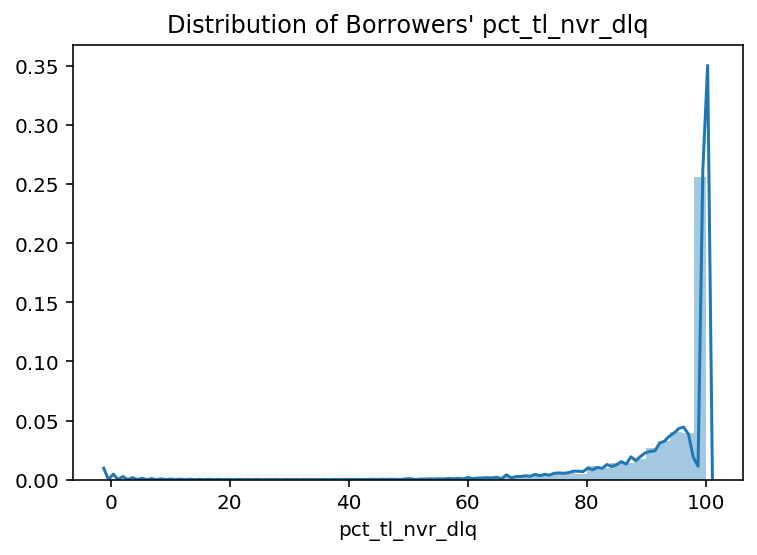

In [335]:
# Check distribution of Borrowers' percentage of trades nerve delinquent. 
#Left skewed distribution, use median to fill missing values
sns.distplot(xtrain["pct_tl_nvr_dlq"].dropna(), hist=True, kde=True,) 
             
plt.title("Distribution of Borrowers' pct_tl_nvr_dlq")
plt.xlabel("pct_tl_nvr_dlq")

print("Skewness: %f" % xtrain["pct_tl_nvr_dlq"].skew())
print("Kurtosis: %f" % xtrain["pct_tl_nvr_dlq"].kurt())


In [337]:
# The following features are all currency-related.
# As the distributions of following features are skewed, I assigned median to fill NaN

curr_var = ["avg_cur_bal",'il_util',"bc_open_to_buy",
            "pct_tl_nvr_dlq","total_bc_limit",'total_bal_ex_mort' ]
for i in curr_var:
    xtrain.loc[xtrain[i].isnull(), i]=xtrain[i].median()

In [338]:
# The distribution of utilization rate features is not skewed, use mean for missing values
util_cols = ["bc_util", 'all_util']
for i in util_cols:
    xtrain.loc[xtrain[i].isnull(), i]=xtrain[i].mean()

In [339]:
# These features are related to how many different accounts open/active, or how many months since last opened. I fill NaN with mode to match the population
acc_cols = ["mo_sin_old_il_acct", 'mths_since_recent_bc',              
             "mort_acc", "num_bc_sats","num_sats"]
      
for i in acc_cols:
    xtrain.loc[xtrain[i].isnull(), i] =xtrain[i].mode()[0]


Skewness: 0.309042
Kurtosis: -1.256349


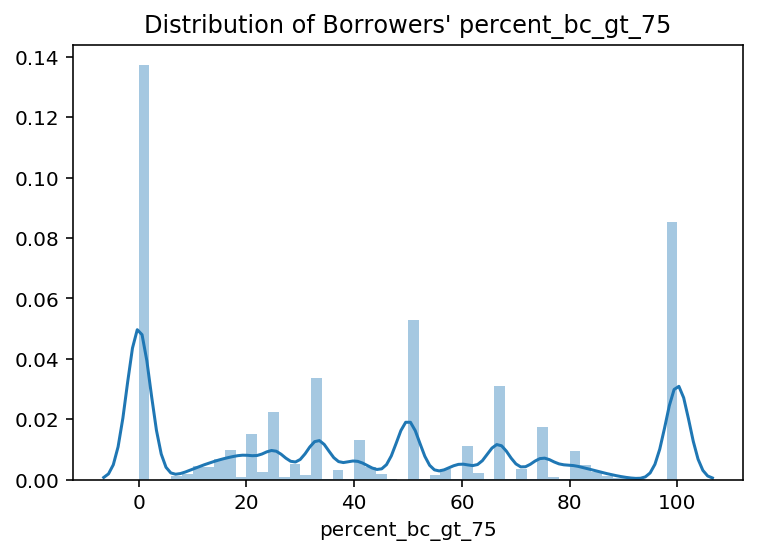

In [341]:
# Check distribution of Borrowers' percentage of all bankcard accounts > 75% of limit.
#Random sampling to fill missing values
sns.distplot(xtrain["percent_bc_gt_75"].dropna(), hist=True, kde=True,) 
             
plt.title("Distribution of Borrowers' percent_bc_gt_75")
plt.xlabel("percent_bc_gt_75")

print("Skewness: %f" % xtrain["percent_bc_gt_75"].skew())
print("Kurtosis: %f" % xtrain["percent_bc_gt_75"].kurt())


In [343]:
# Use random sampling to fill NaN for percent_bc_gt_75
percent_bc_gt_75_isnull = xtrain['percent_bc_gt_75'].isnull()
percent_bc_gt_75_random_sample = xtrain['percent_bc_gt_75'].dropna().sample(percent_bc_gt_75_isnull.sum(), replace= True).values
xtrain.loc[percent_bc_gt_75_isnull,'percent_bc_gt_75'] = percent_bc_gt_75_random_sample
    

In [344]:
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

chargeoff_within_12_mths       118
delinq_amnt                     24
mths_since_recent_inq       236524
num_tl_120dpd_2m            123131
pub_rec_bankruptcies          1070
tax_liens                       83
dtype: int64

#### Days past due and Charge-off
Borrowers' past behaviors measured by day past due and chargeoff are important attributes in predicting borrowers' future loan payment activity, I would like to investigate more if there is more time

In [350]:
# Since the majority of loans (> 90%) falls in the mode value, I am filling NaN with mode. 
pdp_cols = ["chargeoff_within_12_mths" ,"delinq_amnt", "mths_since_recent_inq",
            "num_tl_120dpd_2m","pub_rec_bankruptcies","tax_liens"]

pdict = dict()
pdict['variables'] = []
pdict['mode'] = []
pdict['% of pop'] =[]
    
for i in pdp_cols:
    ratio = round(sum(xtrain[i] == xtrain[i].mode()[0])/len(xtrain),4)
    pdict['variables'].append(i)
    pdict['mode'].append(xtrain[i].mode()[0])
    pdict['% of pop'].append(ratio)

pd.DataFrame(pdict)   

,variables,mode,% of pop
0,chargeoff_within_12_mths,0.0,0.9923
1,delinq_amnt,0.0,0.9968
2,mths_since_recent_inq,1.0,0.0942
3,num_tl_120dpd_2m,0.0,0.9314
4,pub_rec_bankruptcies,0.0,0.8790
5,tax_liens,0.0,0.9714


In [351]:
pdp_cols.remove('mths_since_recent_inq')

In [352]:
pdp_cols

['chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'pub_rec_bankruptcies',
 'tax_liens']

In [353]:
# Filling NaN in dpd features with mode
for i in pdp_cols:
    xtrain.loc[xtrain[i].isnull(),i]= xtrain[i].mode()[0]

 Fill missing values at mths_since_recent_inq if the borrowers' finance inquiries and credit inquires are both zero, otherwise fill missing values with Random sampling with replacements.

In [356]:
xtrain.loc[(sum(xtrain.inq_fi + xtrain.inq_last_12m) ==0) & (xtrain.mths_since_recent_inq.isnull()), "mths_since_recent_inq"] = 0

In [357]:
mths_since_recent_inq_isnull = xtrain['mths_since_recent_inq'].isnull()
mths_since_recent_inq_random_sample = xtrain['mths_since_recent_inq'].dropna().sample(mths_since_recent_inq_isnull.sum(), replace= True).values
xtrain.loc[mths_since_recent_inq_isnull,'mths_since_recent_inq'] = mths_since_recent_inq_random_sample
  

In [359]:
# Check if any columns have missing values. Now all columns have no NaN values
xtrain.isnull().sum()[xtrain.isnull().sum()!=0]

Series([], dtype: int64)

In [368]:
# remove id and url columns as they are not relevant to predicting default rate
for i in ["id", "url"]:
    xtrain.drop(i, axis=1, inplace=True)


In [360]:
xtrain.drop("loan_status", axis=1, inplace=True)
xtrain.drop("target", axis=1, inplace=True)

In [369]:
all_cols = xtrain.columns.tolist()
num_cols = xtrain._get_numeric_data().columns.tolist()
cat_cols = list(set(all_cols) - set(num_cols))

In [380]:
# Make sure all the columns are either numeric or dummies variables
len(all_cols) == len(num_cols)

True

### Prepare data for modeling

#### Assess features' skewness, perform logarithm transformation and normalization

In [371]:
all_cols = xtrain.columns.tolist()

#
skew_dict= dict()
skew_dict["columns"]=[]
skew_dict["skewness"]=[]
for col in all_cols:
    skew_dict["columns"].append(col)
    skew_dict["skewness"].append(xtrain[col].skew())

skew_df = pd.DataFrame(skew_dict)   


In [372]:
# Select features whose skewness is greater than 1 and to use datetype select non-dummy features
skew_list = skew_df.loc[skew_df.skewness > 1, "columns"].values.tolist()
skew_dtype = pd.DataFrame({"skewed columns":skew_list, "dtype": [xtrain[col].dtype for col in skew_list]})
to_tran = skew_dtype.loc[skew_dtype.dtype=="float64", "skewed columns"].tolist()


In [373]:
# #  Apply log transformation on highly skewed features
# log_xtrain= pd.DataFrame()
# for i in all_cols:
#     if i in to_tran:
#         log_xtrain[i]=np.log1p(xtrain[i])
#     else:
#         log_xtrain[i]=xtrain[i]

In [381]:
# Create the Scaler object
scaler = StandardScaler()
# Fit log_transformed data on the scaler object
sca_xtrain = scaler.fit_transform(xtrain)
sca_xtrain = pd.DataFrame(sca_xtrain, columns=all_cols)

#### Create train and validation set

In [382]:
# Create training set and validation set
x_tr, x_val, y_tr, y_val = train_test_split(sca_xtrain, ytrain, test_size=0.2, random_state=1, stratify=ytrain)


### Fit Models
#### Base model : Logistic Regression

In [383]:
logreg = LogisticRegression(random_state = 0)
logreg.fit(x_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [391]:
# Run prediction with the validation dataset
logreg_yp = logreg.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_yproba = logreg.predict_proba(x_val)[:,1]

In [392]:
# Make confusion matrix
logreg_matrix = metrics.confusion_matrix(y_val, logreg_yp )
logreg_matrix

array([[311041,   2088],
       [ 46477,   2101]])

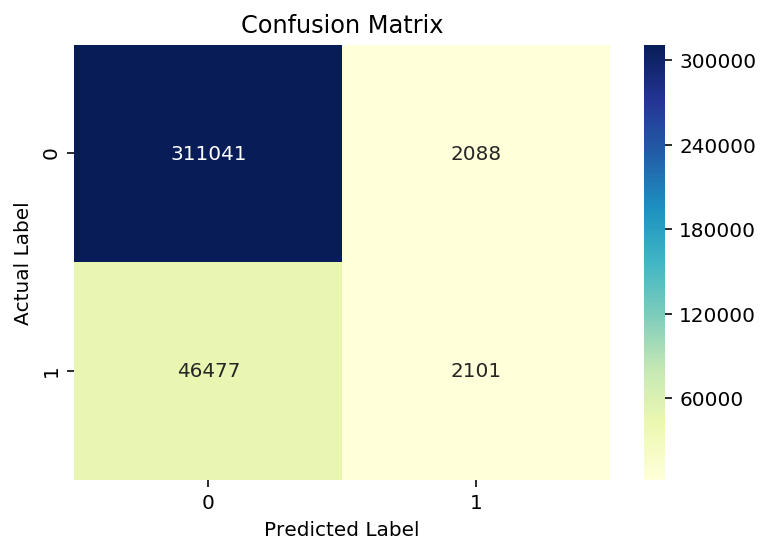

In [393]:
%matplotlib inline

sns.heatmap(logreg_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [394]:
# Calculate the classification report.

print(classification_report(y_val, logreg_yp))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.50      0.04      0.08     48578

    accuracy                           0.87    361707
   macro avg       0.69      0.52      0.50    361707
weighted avg       0.82      0.87      0.81    361707



In [397]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_yproba ))

0.7378416445885851


In [430]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_yp),4))

Accuracy: 0.8657
Precision: 0.5016
Recall/TPR: 0.0433


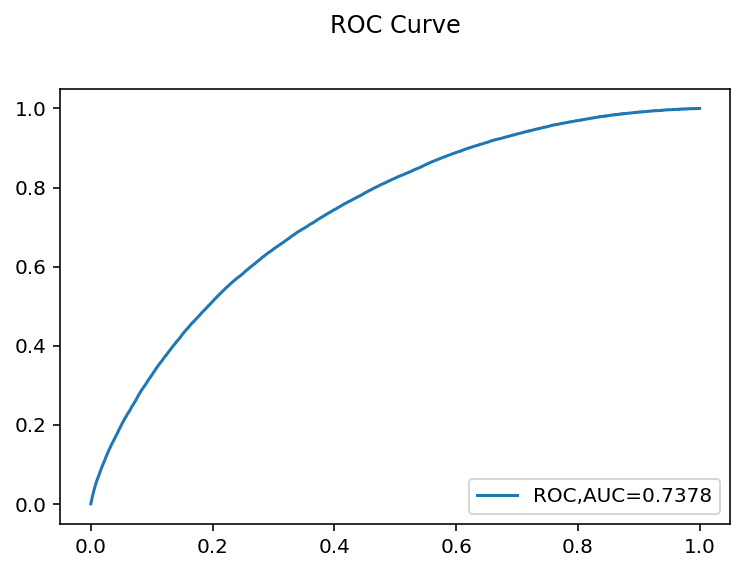

In [401]:

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_yproba)
auc = metrics.roc_auc_score(y_val, logreg_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

#### Logistic Regression with L1 Penalty (Lasso Regularization)

In [404]:
lassomodel = LogisticRegression(penalty ="l1", random_state = 0, solver ="saga")
lassomodel.fit(x_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [405]:
with open('lassomodel.pickle', 'wb') as f:
    pickle.dump(lassomodel, f)

In [406]:
# with open('lassomodel.pickle', 'rb') as f:
#     lassomodel = pickle.load(f)

In [407]:
thetaLasso=lassomodel.coef_[0]
cols_lasso = thetaLasso.round(0) != 0
cols_lasso = cols_lasso.tolist()

In [408]:
# Select features with Logistic regression with L1 penalty
filtered_list = x_tr.columns[cols_lasso].tolist()
filtered_list

['issue_year']

In [409]:
# Run prediction with the validation dataset
lasso_yp = lassomodel.predict(x_val)

In [410]:
# Make confusion matrix
lasso_matrix = metrics.confusion_matrix(y_val, lasso_yp )
lasso_matrix

array([[311245,   1884],
       [ 46664,   1914]])

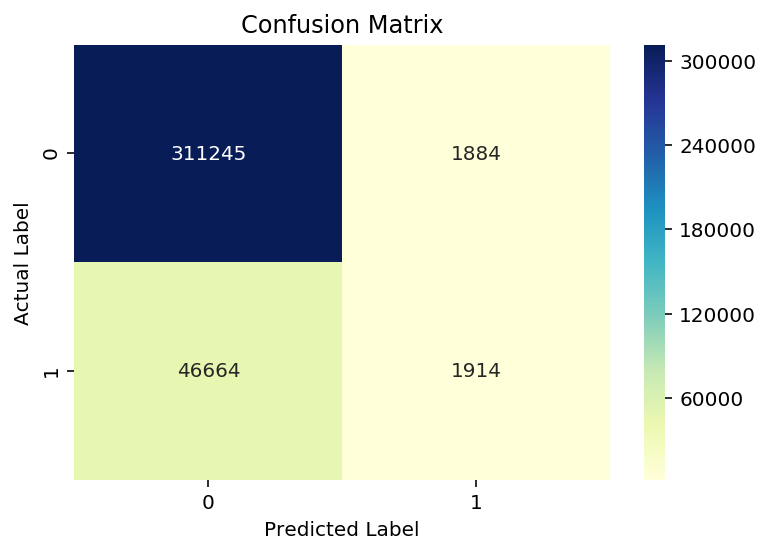

In [411]:
%matplotlib inline

sns.heatmap(lasso_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [412]:
# Calculate the classification report.

print(classification_report(y_val, lasso_yp))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.50      0.04      0.07     48578

    accuracy                           0.87    361707
   macro avg       0.69      0.52      0.50    361707
weighted avg       0.82      0.87      0.81    361707



In [414]:
print("Accuracy:", round(metrics.accuracy_score(y_val, lasso_yp),4))
print("Precision:",round(metrics.precision_score(y_val, lasso_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, lasso_yp),4))

Accuracy: 0.8658
Precision: 0.5039
Recall/TPR: 0.0394


In [415]:
# Get the probability score for observations.
lasso_yproba = lassomodel.predict_proba(x_val)[::,1]

# Calculate the AUC score 
print(roc_auc_score(y_val,lasso_yproba ))

0.7367944254108842


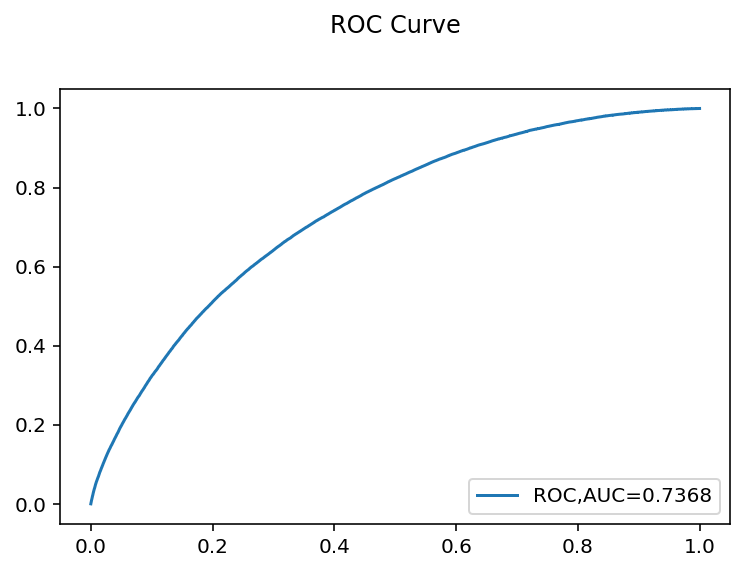

In [416]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  lasso_yproba)
auc = metrics.roc_auc_score(y_val, lasso_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

We noted that the Recall scores on the first two models were pretty low at 0.04, which means that it can only correctly identify 4% of the bad loans out of all the bad loans in the data set. These two models didn't perform very well in predicting on the validation set. Let's start with handling the dataset imbalance issue.

### Handle imbalanced dataset by Upsampling 

In [417]:
# Random over-samples the minority group to handle the imbalanced dataset
ros = RandomOverSampler(sampling_strategy =0.5,random_state=42)
x_res, y_res = ros.fit_resample(x_tr, y_tr)

In [418]:
# Another oversampling method is SMOTE method, upsampling by generating synthetic data
# sm = SMOTE(random_state=42, sampling_strategy =0.5) 
# x_sa, y_sa = sm.fit_resample(x_tr, y_tr)

In [419]:
# Check out the ratio of bad loans vs good loans in our resampled dataset
sum(y_res==1)/len(y_res)

0.33333315591247903

### Logistic Regression with Balanced Training Data

In [420]:
logreg_2 = LogisticRegression(random_state = 0)
logreg_2.fit(x_res, y_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [422]:
# Run prediction with the validation dataset
logreg_2_yp = logreg_2.predict(x_val)

#Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes.
logreg_2_yproba = logreg_2.predict_proba(x_val)[:,1]

In [423]:
# Make confusion matrix
logreg_2_matrix = metrics.confusion_matrix(y_val, logreg_2_yp )
logreg_2_matrix

array([[278440,  34689],
       [ 31591,  16987]])

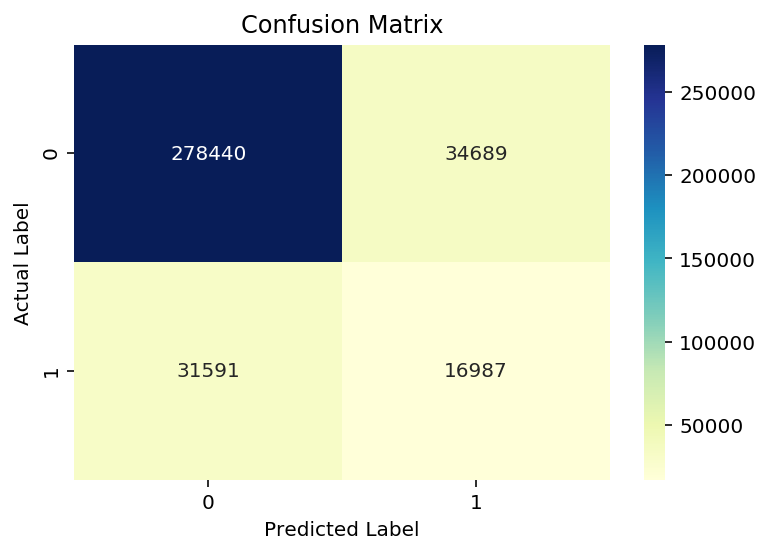

In [424]:
%matplotlib inline

sns.heatmap(logreg_2_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [425]:
# Calculate the classification report.

print(classification_report(y_val, logreg_2_yp))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89    313129
           1       0.33      0.35      0.34     48578

    accuracy                           0.82    361707
   macro avg       0.61      0.62      0.62    361707
weighted avg       0.82      0.82      0.82    361707



In [426]:
#d) Calculate the AUC score 
print(roc_auc_score(y_val,logreg_2_yproba ))

0.738347217313112


In [429]:
print("Accuracy:", round(metrics.accuracy_score(y_val, logreg_2_yp),4))
print("Precision:",round(metrics.precision_score(y_val, logreg_2_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, logreg_2_yp),4))

Accuracy: 0.8168
Precision: 0.3287
Recall/TPR: 0.3497


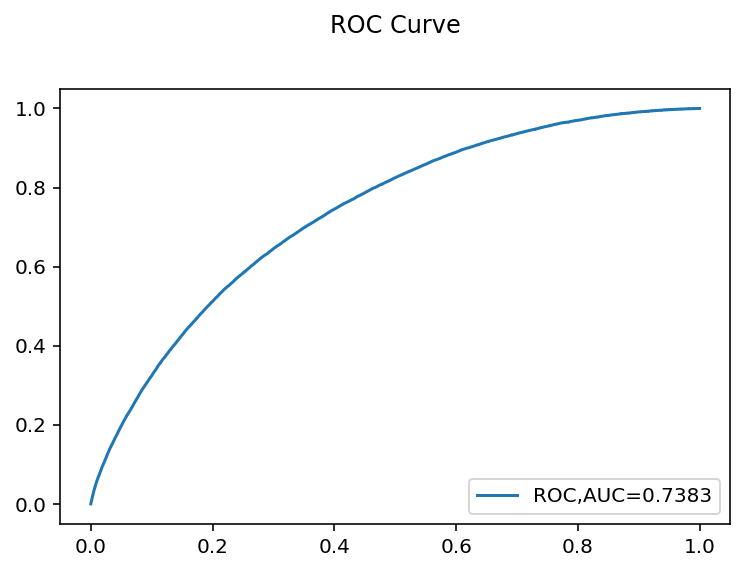

In [428]:

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  logreg_2_yproba)
auc = metrics.roc_auc_score(y_val, logreg_2_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

#### Random Forest Model
We can use the built-in variable importance in RF model for our feature selections. 

In [432]:
# Instantiate a RandomforestClassifier using default Gini method
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit dt to the training set
rf.fit(x_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [433]:
with open('rf_model.pickle', 'wb') as f:
    pickle.dump(rf, f)
# with open('rf_model.pickle', 'rb') as f:
#     rf = pickle.load(f)

In [434]:
# Run prediction with the validation dataset
rf_yp = rf.predict(x_val)

In [435]:
# Make confusion matrix
rf_matrix = metrics.confusion_matrix(y_val,rf_yp)
rf_matrix

array([[310253,   2876],
       [ 46166,   2412]])

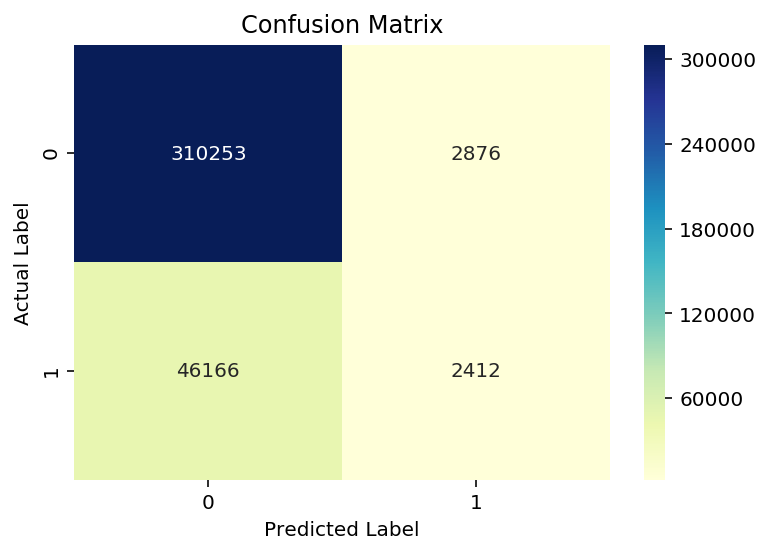

In [436]:
%matplotlib inline

sns.heatmap(rf_matrix,annot=True,cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

class_names=[0,1] # name  of classes
xlocs, xlabels = plt.xticks()
plt.xticks(xlocs,class_names)
ylocs, ylabels = plt.xticks()
plt.yticks(ylocs,class_names)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()


In [437]:
# Calculate the classification report.

print(classification_report(y_val, rf_yp))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93    313129
           1       0.46      0.05      0.09     48578

    accuracy                           0.86    361707
   macro avg       0.66      0.52      0.51    361707
weighted avg       0.81      0.86      0.81    361707



In [438]:
print("Accuracy:", round(metrics.accuracy_score(y_val, rf_yp),4))
print("Precision:",round(metrics.precision_score(y_val, rf_yp),4))
print("Recall/TPR:",round(metrics.recall_score(y_val, rf_yp),4))

Accuracy: 0.8644
Precision: 0.4561
Recall/TPR: 0.0497


In [439]:
# Get the probability score for observations.
rf_yproba = rf.predict_proba(x_val)[::,1]

# Calculate the AUC score 
print(roc_auc_score(y_val,rf_yproba ))

0.7386719664987433


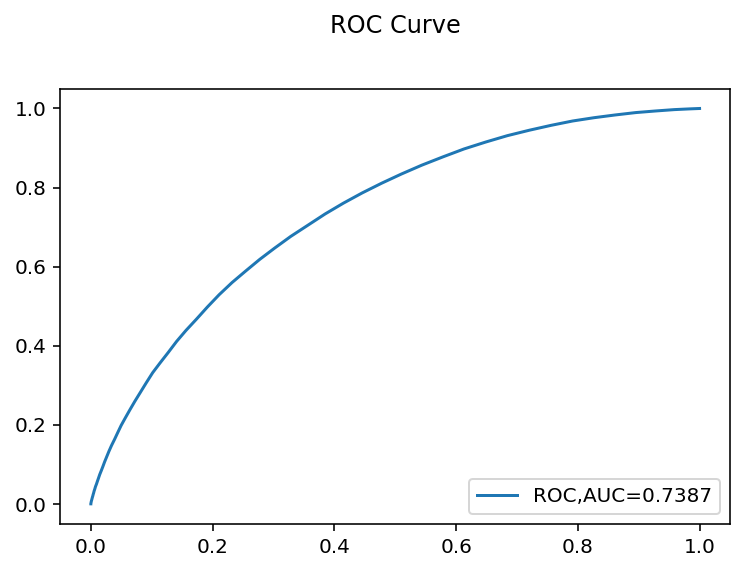

In [440]:
# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  rf_yproba)
auc = metrics.roc_auc_score(y_val, rf_yproba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(round(auc,4)))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

In [441]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
    index = x_tr.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values(ascending=False)
sorted_importances_rf[:20]

int_rate                0.035316
sub_grade               0.030971
issue_year              0.028451
dti                     0.022741
grade                   0.022622
zip_code                0.021522
installment             0.020317
annual_inc              0.020206
revol_util              0.019654
bc_open_to_buy          0.019415
revol_bal               0.019222
avg_cur_bal             0.018932
tot_hi_cred_lim         0.018640
mo_sin_old_rev_tl_op    0.018491
bc_util                 0.018470
total_bc_limit          0.018290
tot_cur_bal             0.017927
mo_sin_old_il_acct      0.017800
total_rev_hi_lim        0.017644
total_bal_ex_mort       0.017579
dtype: float64

In [442]:
print("The first 20 features accounts for " + str(round(sum(sorted_importances_rf[:20]),4)*100)+"%")

The first 20 features accounts for 42.42%


In [443]:
rf_feat = sorted_importances_rf.index[:20].tolist()
print("Top 20 Features selected by random forest:")
print(rf_feat)

Top 20 Features selected by random forest:
['int_rate', 'sub_grade', 'issue_year', 'dti', 'grade', 'zip_code', 'installment', 'annual_inc', 'revol_util', 'bc_open_to_buy', 'revol_bal', 'avg_cur_bal', 'tot_hi_cred_lim', 'mo_sin_old_rev_tl_op', 'bc_util', 'total_bc_limit', 'tot_cur_bal', 'mo_sin_old_il_acct', 'total_rev_hi_lim', 'total_bal_ex_mort']


#### Xgboost model

In [115]:
x_val = np.array(x_val)

In [75]:
#data_dmatrix = xgb.DMatrix(data=x_res ,label=y_res)

xgb1 = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                    scale_pos_weight=1,
                    eval_metric='auc',
                     seed=27)


In [ ]:
# Fit the data into xgboost model-1
xgb1.fit(x_res, y_res)

In [87]:
# Predict on the validation set
xgy_pred = xgb1.predict(x_val)

In [187]:
with open('xgb1_model.pickle', 'wb') as f:
    pickle.dump(xgb1, f)
# with open('xgb1_model.pickle', 'rb') as f:
#     xgb1 = pickle.load(f)

In [109]:
xgb1_matrix = metrics.confusion_matrix(y_val, xgy_pred)
print(xgb1_matrix)

print("Accuracy (Validation set):", round(metrics.accuracy_score(y_val, xgy_pred),4))
print("TestPrecision (Validation set):",round(metrics.precision_score(y_val, xgy_pred),4))
print("Recall/TPR(Validation set):",round(metrics.recall_score(y_val, xgy_pred),4))

[[293934    612]
 [  2635  41920]]
Accuracy (Validation set): 0.9904
TestPrecision (Validation set): 0.9856
Recall/TPR(Validation set): 0.9409


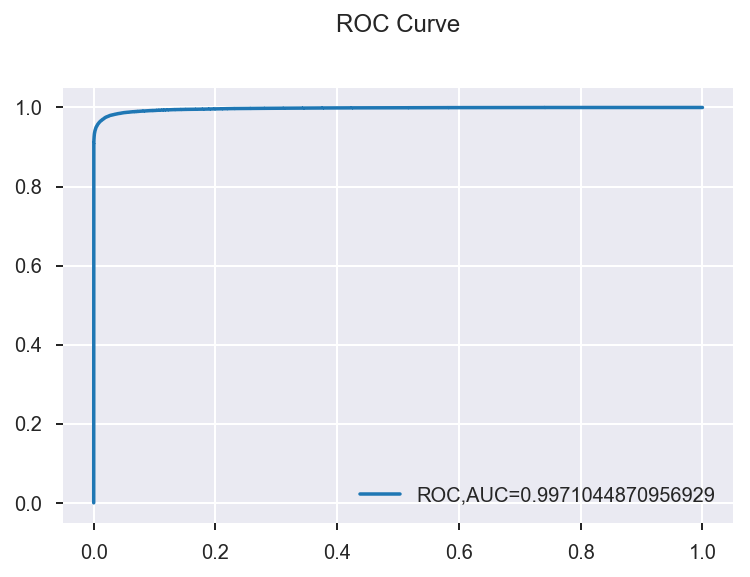

In [116]:
# Get the probability score for observations.
y_pred_proba = xgb1.predict_proba(x_val)[::,1]

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)

auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(auc))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

In [117]:
# Create a pd.Series of features importances
importances_xgb1 = pd.Series(xgb1.feature_importances_,
    index = x_tr.columns)

# Sort importances_rf
sorted_importances_xgb1 = importances_xgb1.sort_values(ascending=False)
sorted_importances_xgb1[:30]

collection_recovery_fee             0.736491
next_pymnt_d_current                0.044138
next_pymnt_d_passed                 0.041765
term_ 60 months                     0.026769
settlement__ACTIVE                  0.019310
debt_settlement_flag_N              0.012488
loan_amnt                           0.012267
debt_settlement_flag_Y              0.009167
no_next_pymnt_d                     0.008150
last_pymnt_amnt                     0.007986
total_rec_late_fee                  0.006968
sub_grade                           0.006849
grade                               0.006662
funded_amnt_inv                     0.004931
total_rec_prncp                     0.004146
hardship_flag_Y                     0.003436
verification_status_Not Verified    0.003335
term_ 36 months                     0.002796
no_hardship                         0.002184
installment                         0.002100
hardship_flag_N                     0.001894
out_prncp                           0.001643
issue_year

#### Tune parameters for xgboost model

In [118]:
x_val = pd.DataFrame(x_val, columns=all_cols)
x_res = pd.DataFrame(x_res, columns=all_cols)

In [121]:
param_tune = {'max_depth':[4,6],
              'min_child_weight':[4,6]}

In [122]:
# def xgbpara(X_train, y_train, X_test, y_test, params_untuned, scoring='roc_auc', n_jobs=4, cv=3):
    
#     model_estimator = xgb.XGBClassifier(learning_rate =0.1, 
#                                 n_estimators=200, 
#                                 max_depth=5,
#                                 min_child_weight=1, 
#                                 gamma=0, 
#                                 subsample=0.8,
#                                 colsample_bytree=0.8,
#                                 objective= 'binary:logistic', 
#                                 nthread=4,
#                                 scale_pos_weight=1,
#                                 seed=27)
    
#     grid_search = GridSearchCV(estimator = model_estimator,
#                              param_grid = params_untuned, 
#                             scoring=scoring,
#                             n_jobs=n_jobs,
#                              cv=cv)
    
#     grid_search.fit(X_train, y_train)
#     y_pred = grid_search.predict(X_test)
        
#     best_estimator = grid_search.best_estimator_
#     print('the best_params : ', grid_search.best_params_)
#     print('the best_score  : ', grid_search.best_score_)
#     print("Accuracy for test data: ", metrics.accuracy_score(y_test, y_pred))
#     print("AUC Score for test data", metrics.roc_auc_score(y_test, y_pred))
        
#
        
#     return best_estimator
   
   

In [123]:
# # Tune highparameters for xgboosting model 
# xgbtune = xgbpara(X_train=x_res, y_train= y_res, X_test= x_val,y_test= y_val ,params_untuned=param_tune)


I used XGBClassifier an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM. We can also use the xgboost package to run the model as follows.

In [124]:
# import xgboost as xgb
# # Loan data into DMatrix
# dtrain = xgb.DMatrix(x_res, label=y_res)
# dtest = xgb.DMatrix(x_val)

# # Set parameters
# param = {'max_depth': 5,  'objective': 'binary:logistic',
#          eval_metric='auc',min_child_weight=1, subsample=0.8,
#         'colsample_bytree' : 0.8,scale_pos_weight=2}

# evallist = [(dtest, 'eval'), (dtrain, 'train')]

# num_round=10

# # Train xgboost model
# bst = xgb.train(param, dtrain, num_round, evallist)

# # Save the model 
# bst.save_model('xgb2.model') 
# # Make predition with xgboost model 
# ypred = bst.predict(dtest)xgb.plot_importance(bst)

### Prepare testset for prediction

In [125]:

xtest.drop(["target","loan_status"],axis=1, inplace=True)
# Remove high correleted variables
xtest.drop(corr9_vars,axis=1, inplace= True)

In [126]:
# Convert issue date to year and month separate variables
xtest["issue_year"]= pd.to_datetime(xtest.issue_d).dt.year
xtest["issue_month"]= pd.to_datetime(xtest.issue_d).dt.month
xtest.drop("issue_d", axis=1,inplace = True)

In [127]:
# Create dummy variables for loans with desc and without
xtest["desc_y"]= np.where(xtest.desc.notnull(), 1, 0)
xtest["desc_n"]= np.where(xtest.desc.isnull(), 1, 0)
xtest.drop("desc", axis=1, inplace=True)

In [128]:
# Noted there are more than 84% loans has no values in mths_since_last_record
print(str(round(xtest.mths_since_last_record.isnull().sum()/len(xtest),4))+ " of total loans have values mths_since_last_record")
#Create dummy variables to indicate a loan with mths_since_last_record and without
xtest["pub_record_y"]= np.where(xtest.mths_since_last_record.notnull(), 1, 0)
xtest["pub_record_n"]= np.where(xtest.mths_since_last_record.isnull(), 1, 0)


0.8416 of total loans have values mths_since_last_record


In [129]:
# Combine these 4 joint borrowers' variables into the their respective variables measuring the single borrowers
joint_ann_inc = xtest.loc[xtest.application_type=="Joint App","annual_inc_joint"].values
join_dti = xtest.loc[xtest.application_type=="Joint App","dti_joint"].values
joint_ver = xtest.loc[xtest.application_type=="Joint App","verification_status_joint"].values
joint_revo_bal = xtest.loc[xtest.application_type=="Joint App","revol_bal_joint"].values

In [130]:
xtest.loc[xtest.application_type=="Joint App","annual_inc"]= joint_ann_inc
xtest.loc[xtest.application_type=="Joint App","dti"]= join_dti 
xtest.loc[xtest.application_type=="Joint App","verification_status"]= joint_ver
xtest.loc[xtest.application_type=="Joint App","revol_bal"]= joint_revo_bal

In [131]:
# Create dummies for loan's sec_app_inq_last_6mths
xtest["no_sec_app"] = np.where(xtest.sec_app_inq_last_6mths.isnull(),1,0)
sec_app_inq= pd.get_dummies(xtest.sec_app_inq_last_6mths, prefix="sec_app_inq_")
xtest = pd.concat([xtest, sec_app_inq], axis=1)


In [132]:
# Create 3 dummy variables: loan without hardship, loan with hardship with no dpd , loan with hardship with dpd 
xtest["no_hardship"] = np.where(xtest.hardship_dpd.isnull(),1,0)
xtest["hardship_dpd_n"] = np.where(xtest.hardship_dpd == 0,1,0)
xtest["hardship_dpd_y"] = np.where(xtest.hardship_dpd != 0,1,0)


In [133]:
# Create dummy variables indicating hardship status : Active, Completed or Broken
settlement = pd.get_dummies(xtest.settlement_status, prefix="settlement_")
xtest = pd.concat([xtest, settlement], axis=1)

In [134]:
# Now we are ready to drop the features with over 80% missing values
xtest.drop(["mths_since_last_record", "annual_inc_joint", "dti_joint", 
           "verification_status_joint", "revol_bal_joint","sec_app_earliest_cr_line",
           "sec_app_inq_last_6mths", "sec_app_mort_acc","sec_app_open_acc",
           "sec_app_revol_util","sec_app_open_act_il","sec_app_num_rev_accts",
           "sec_app_chargeoff_within_12_mths", "sec_app_collections_12_mths_ex_med",
           "sec_app_mths_since_last_major_derog", 
            "hardship_type", "hardship_reason", "hardship_status",                               
            "deferral_term","hardship_amount" ,"hardship_last_payment_amount",                              
            "hardship_start_date" , "hardship_end_date",                          
            "payment_plan_start_date" ,"hardship_length",                            
            "hardship_dpd","hardship_loan_status",
             "orig_projected_additional_accrued_interest",
          "debt_settlement_flag_date", "settlement_status","settlement_date",
           "settlement_percentage","settlement_term"],
          axis=1, inplace=True)
          

In [135]:
#Assign missing values in emp_title as undisclosed 
xtest.loc[xtest.emp_title.isnull(), "emp_title"] ="Undisclosed"

In [136]:
# As the majority of missing values in emp_length are associated with undisclosed emp_title. I will fill NA values in emp_length with random samples from the undisclosed group
emp_len_isnull = xtest.emp_length.isnull()
emp_len_samples = xtest.loc[(xtest.emp_title=="Undisclosed") & (xtest.emp_length.notnull()), 'emp_length'].sample(emp_len_isnull.sum(),replace= True).values
xtest.loc[emp_len_isnull,"emp_length"] = emp_len_samples

In [137]:
# Extract the number of years from emp_length column, convert it to string and fill NaN with the mean.
xtest['emp_length'] = xtest['emp_length'].str.extract('(\d+)')
xtest['emp_length'] = xtest["emp_length"].convert_objects(convert_numeric = True)
# Assumptions: borrowers who has 10 years or more than 10 years of employment are similar in their debt repaymnet 

In [138]:
# Convert loan grade and loan subgrades to numerica value
xtest['grade'] = xtest['grade'].map(dfgrade)
xtest['sub_grade'] = xtest['sub_grade'].map(dfsubgrade)

In [139]:
# Create a dictionary for these employment title variables
title_dict = {}
for key,value in titles.items():
    title_dict[key]=[int(sum([1 if j in value else 0 for j in i.split()]) > 0) for i in xtest['emp_title'].values ]
    

In [140]:
# Concat the employee title dummy variables 
title_df = pd.DataFrame(title_dict)
title_df.reset_index(drop=True, inplace=True)
xtest.reset_index(drop=True, inplace=True)
xtest = pd.concat([xtest, title_df], axis=1)

In [141]:
# Add dummy variable of employment title to the dataset
xtest['emp_undisc'] = np.where(xtest.emp_title=='Undisclosed',1,0)

In [142]:
# Add dummy variable of Other employment title to the dataset
xtest['title_other'] = np.where((xtest.emp_undisc + xtest.mgt_title + xtest.nurse_title + xtest.teacher_title + xtest.owner_title+ xtest.driver_title) == 0,1,0)

In [143]:
xtest.drop("emp_title", axis=1, inplace=True)

In [144]:
# drop column title as it provides details explanation of loan purpose. Could do more text analysis if loan purpose is an important feature after performing feature selection 
xtest.drop("title",axis=1, inplace=True)

In [145]:
todummy = ["application_type","initial_list_status","term","purpose","home_ownership",
           "verification_status","pymnt_plan",'debt_settlement_flag','disbursement_method',
           'hardship_flag']
    
# Convert application_type to dummy variables
for i in todummy:
    dummy = pd.get_dummies(xtest[i], prefix = i)
    xtest = pd.concat([xtest, dummy], axis=1)
    xtest.drop(i, axis=1, inplace=True)

In [146]:
# combine home ownership other, none and any into one group:Other
xtest.home_ownership_OTHER = xtest.home_ownership_OTHER + xtest.home_ownership_ANY + xtest.home_ownership_NONE
 
xtest.drop(["home_ownership_ANY","home_ownership_NONE"], axis=1, inplace=True)

In [147]:
# # Calculate the percentage of bad loans of each state
# dfstate = xtrain.loc[:,["addr_state","target"]].groupby(["addr_state"]).mean()
# dfstate  = round(dfstate*100,2).to_dict()['target']

In [148]:
# # Calculate the percentage of bad loans per each zip_code
# dfzipc = xtrain.loc[:,["zip_code","target"]].groupby(["zip_code"]).mean()
# dfzipc  = round(dfzipc*100,2).to_dict()['target']

In [149]:
# Convert zip_code and addr_state to numerica value
xtest['zip_code'] = xtest['zip_code'].map(dfzipc)
xtest['addr_state'] = xtest['addr_state'].map(dfstate)

In [150]:
# Noted there is one missing value in zip_code, fillna with mode
xtest.loc[xtest.zip_code.isnull(), "zip_code"] = xtrain['zip_code'].mode()[0]

In [151]:
# Fill missing values with median
for i in ['annual_inc','tot_coll_amt','revol_bal','open_acc','total_acc','delinq_2yrs']:
    xtest.loc[xtest[i].isnull(), i] = xtrain[i].median()

In [152]:
# Fill missing values for the following variables with mean value since the distribution is close to normal
for i in ["dti","revol_util"]:
    xtest.loc[xtest[i].isnull(), i ] = xtrain[i].mean()

In [153]:
# Create a new column from last_credit_pull_d by calculating the number of months since last LC pulled credit
for i in ['last_credit_pull_d','last_pymnt_d']:
    xtest[i] = pd.to_datetime(xtest[i])
    # The lastest date in the dataset is 2019 Feb, which is also the mode
    xtest[i] = ((xtest[i].mode()[0] - xtest[i])/np.timedelta64(1, 'M'))

    # Fill Nan for mth_last_credit_pull with mean
    xtest.loc[xtest[i].isnull(), i]=xtest[i].mean()
    xtest.drop(i, axis=1, inplace=True)
    


In [154]:
# Simply fill missing values for following columns with mode value in the existing data bution since the number of missing values is a small amount

for i in ["earliest_cr_line", "inq_last_6mths","open_acc","pub_rec",
          "collections_12_mths_ex_med","acc_now_delinq"]:
    xtest.loc[xtest[i].isnull(), i] =xtrain[i].mode()[0]

In [161]:
# Extract the year in which the borrower has credit line
xtest['earliest_cr_line'] = xtest['earliest_cr_line'].str.extract('(\d+)')
#.astype(int)

In [163]:
xtest.loc[xtest['earliest_cr_line'].isnull(),'earliest_cr_line'] = xtrain['earliest_cr_line'].mode()[0]

In [164]:
# Create dummy variables to convert next payment date to three dummy variables : no next payment date, next payment date up-to-date, next payment date passed
xtest["no_next_pymnt_d"] = np.where(xtest.next_pymnt_d.isnull(),1,0)
xtest["next_pymnt_d_current"] = np.where(xtest.next_pymnt_d == xtest.next_pymnt_d.mode()[0],1,0)
xtest["next_pymnt_d_passed"] = np.where(xtest.next_pymnt_d != xtest.next_pymnt_d.mode()[0],1,0)
xtest.drop('next_pymnt_d', axis=1, inplace=True)

In [165]:
# Since these borrowers' are not involved in the open trades, I assign 0 to following variables.
finstrades = ["open_acc_6m","open_il_12m","open_il_24m","open_act_il","total_bal_il",
              "open_rv_12m","open_rv_24m","max_bal_bc","inq_fi","total_cu_tl","inq_last_12m"]
for i in finstrades:
    xtest.loc[xtest[i].isnull(), i] = 0

In [166]:
# Since these customers are not involved in finance trades, I assigned the largest value in the mths_since_rcnt_il to indicate they are not involving the activity
xtest.loc[xtest["mths_since_rcnt_il"].isnull(), "mths_since_rcnt_il"]=xtrain["mths_since_rcnt_il"].max()

In [167]:
# The following features are all currency related, I ploted density plots to see their distributions.
# Based on the skewed distributions of following features, I assigned median to fill NaN

curr_var = ['tot_hi_cred_lim','il_util','total_rev_hi_lim','total_il_high_credit_limit',
           "avg_cur_bal", "pct_tl_nvr_dlq","total_bc_limit"]
for i in curr_var:
    xtest.loc[xtest[i].isnull(), i]=xtrain[i].median()

In [168]:
# The distribution of utilization rate features is not skewed, use mean for missing values
util_cols = ["bc_util", 'all_util']
for i in util_cols:
    xtest.loc[xtest[i].isnull(), i]=xtrain[i].mean()


In [169]:
# Use Weighted Average method for delinquent related missing values
# Assumption: a consistent pattern is presented in all deliquent related features: as the number of months since last deliquent gets bigger, the ratio of bad loans decrease. This is reasonable in business sense as we can assume that borrowers who have been consistently paying their loan repayment for a period of time are more likely to continue paying, which indicating good loans. 

def fill_delinq(col, a):
    # Summary ratio of bad loans by variable of interest
    df = xtrain.loc[:,[col,"target"]].groupby([col]).agg(['mean', 'count'])
    
    # The ratio of bad loans in the missing value group
    mean = xtrain.loc[xtrain[col].isnull(),"target"].mean()
    
    # Use the ratio of bad loans of the missing value group to find the existing data range that has similar bad loan ratio within +/-a range
    df= df.loc[(df['target']['mean'].values >= (mean - a)) & (df['target']['mean'].values <= (mean + a)),:]
    df["weighted_avg"] = df['target']['count']/sum(df['target']['count'])

    # Calculate the weighted average mths_since_last_delinq of loans
    w_avg =0
    for i in range(len(df)):
        w_avg += df.index[i] * df.weighted_avg.tolist()[i]
        
    return w_avg
    

In [175]:
# Bring back the target variables for the fill_deling function
xtrain = pd.concat([xtrain, ytrain], axis=1)

# Fill NaN for delinquence related features.
# Based on the point plot of delinquent-related features vs target, the ratio of bad loans decreases as the number of months since last/recent delinquent increases.

del_cols = ["mths_since_recent_bc_dlq", "mths_since_recent_revol_delinq",
            "mths_since_recent_inq", "mths_since_last_delinq", "mths_since_last_major_derog"]

for i in del_cols:
    w_avg =fill_delinq(i, 0.005)
    xtest.loc[xtest[i].isnull(), i ] = w_avg

In [176]:
# These features are related to how many different accounts open/active, or how many months since last opened. I fill NaN with mode to match the population
acc_cols = ["acc_open_past_24mths", "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op",
            "mo_sin_rcnt_rev_tl_op","num_il_tl",               
            "mo_sin_rcnt_tl", "mort_acc", "bc_open_to_buy",
            "num_actv_bc_tl", "num_bc_tl",
            "num_rev_accts","num_rev_tl_bal_gt_0",
           "mths_since_recent_bc", "num_tl_op_past_12m",
           "num_op_rev_tl","num_bc_sats","num_sats"]

for i in acc_cols:
    xtest.loc[xtest[i].isnull(), i] =xtest[i].mode()[0]


In [177]:
# Since the majority of loans (> 90%) falls in the mode value, I am filling NaN with mode. 
pdp_cols = ["chargeoff_within_12_mths" ,"delinq_amnt", "num_accts_ever_120_pd","num_tl_30dpd",
            "num_tl_90g_dpd_24m","num_tl_120dpd_2m","pub_rec_bankruptcies","tax_liens"]

# Filling NaN in dpd features with mode
for i in pdp_cols:
    xtest.loc[xtest[i].isnull(),i]= xtrain[i].mode()[0]
     

In [178]:
# Percentage of all bankcard accounts > 75% of limit
# Fill missing values in percent_bc_gt_75 by sampling from existing income values with replacement  
perc_isnull = xtest.percent_bc_gt_75.isnull()
perc_sample = xtrain["percent_bc_gt_75"].dropna().sample(perc_isnull.sum(), replace= True).values
xtest.loc[perc_isnull,"percent_bc_gt_75"] = perc_sample

In [179]:
# Check if any columns have missing values
xtest.isnull().sum()[xtest.isnull().sum()!=0]

Series([], dtype: int64)

In [181]:
text_cols = xtest.columns.tolist()
num_cols = xtest._get_numeric_data().columns.tolist()
cat_cols = list(set(text_cols) - set(num_cols))

In [182]:
# # Select features whose skewness is greater than 1 and to use datetype select non-dummy features
# skew_list = skew_df.loc[skew_df.skewness > 1, "columns"].values.tolist()
# skew_dtype = pd.DataFrame({"skewed columns":skew_list, "dtype": [xtrain[col].dtype for col in skew_list]})
# to_tran = skew_dtype.loc[skew_dtype.dtype=="float64", "skewed columns"].tolist()

In [183]:
#  Apply log transformation on highly skewed features
X_test= pd.DataFrame()
for i in all_cols:
    if i in to_tran:
        X_test[i]=np.log1p(xtest[i])
    else:
        X_test[i]=xtest[i]

In [184]:
# # Create the Scaler object
# scaler = StandardScaler()
# Fit log_transformed data on the scaler object
X_test= scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=text_cols)

### Run model on test dataset

In [186]:
# Convert the xtest to numpy array since the training dataset used in xgboost model was removed accidentally, but it won't affecting our prediction.
x_test = np.array(X_test)

In [188]:
# Perform Prediction on the test set
ytest_pred = xgb1.predict(x_test)

In [190]:
xgb_matrix = metrics.confusion_matrix(ytest, ytest_pred)
print(xgb_matrix)

print("Accuracy (Test set):", round(metrics.accuracy_score(ytest, ytest_pred),4))
print("TestPrecision (Test set):",round(metrics.precision_score(ytest, ytest_pred),4))
print("Recall/TPR(Test set):",round(metrics.recall_score(ytest, ytest_pred),4))

[[489879   1030]
 [  4288  69970]]
Accuracy (Test set): 0.9906
TestPrecision (Test set): 0.9855
Recall/TPR(Test set): 0.9423


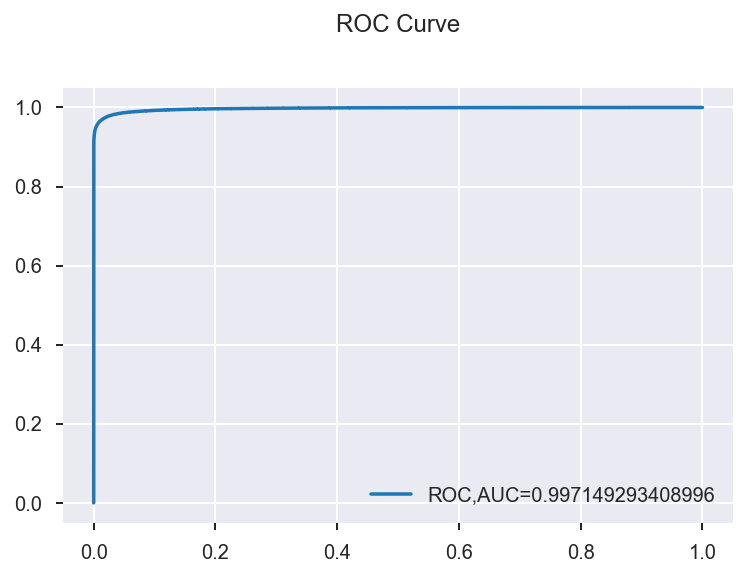

In [191]:
# Get the probability score for observations.
y_pred_proba = xgb1.predict_proba(x_test)[::,1]

# Graph Receiver Operating Characteristic(ROC) curve and compute AUC (Area Under the Receiver Operating Characteristic Curve) from prediction scores.
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)

auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="ROC,AUC="+str(auc))
plt.title('ROC Curve', y=1.1)
plt.legend(loc=4)
plt.show()

#### Evaluate Model Performance on Test Set

Since this is an imbalanced dataset (minority group/bad loans 13% of population), we need to use AUC ROC and True Positive Ratio in addition to the Accuracy score when evaluating the model prediction performance. The True Positive Rate for test dataset using Xgboost model is 94%, indicating that the xgboost model can predict a "bad" loans 94% of time. 

#### Areas of improvements

To improve this project, I would like to test xgboost models with the features selected by Lasso regression and random forest. Also, I would like to perform hyperparameters tuning for Xgboost model.

In [410]:
# import dill
# dill.dump_session('notebook_env.db')

TypeError: no default __reduce__ due to non-trivial __cinit__

In [ ]:
# import dill
# dill.load_session('notebook_env.db')